*This notebook contains an analysis of Rep-seq data for Cohort I*


In [1]:
import os
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.stats.multitest import multipletests

In [2]:
warnings.filterwarnings('ignore')

# Functions

## Visualisation

In [3]:
def plot_hist_usage(gene_names: list, usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - usage_matrix: matrix with gene usage value
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(10,15))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 
    
    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=usage_matrix[column], bins=100)
        plt.title(f'{column}') 
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [4]:
def plot_hist_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise joint distributions of only functional and nonfunctional sequences gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(20,30))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 

    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=of_usage_matrix[column], bins=50, alpha=0.9, label='of')#blue
        plt.hist(x=nf_usage_matrix[column], bins=50, alpha=0.3, label='nf')#yellow
        plt.title(f'{column}')
        plt.legend(fontsize="9")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [5]:
def plot_scatter_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, file_name = None, clonotype_counts = None):
    """Visualise and calculate regression coefficients of scatterplots for only functional and nonfunctional sequences gene usage
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - file_name: file name for saving pictures
        - clonotype_counts: file name for saving clonotype counts dict
    return:
        - regression coefficients 
    """
    
    tr_fit_koef = pd.DataFrame(columns=['gene', 'koef'])

    plt.figure(figsize=(20,30))

    for i, column in enumerate(gene_names):
        x = of_usage_matrix[column]
        y = nf_usage_matrix[column]
        plt.subplot(len(gene_names) // 5 + 1, 5, i+1)

        plt.scatter(x=x, y=y, s=1)
        lim = max(plt.ylim()[1], plt.xlim()[1])
        xy_lim = (0, lim)
        plt.plot(xy_lim, xy_lim, color = 'r', label='y=x')

        x = np.array(x)
        y = np.array(y)
        x = np.append(x, [0])
        y = np.append(y, [0])
        x = np.array(x)[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)
        plt.plot(x, a*x, 'blue', label='regression')
        tr_fit_koef.loc[i] = [column, a[0]] 

        plt.text(xy_lim[1]-0.8*xy_lim[1], 0, f'k={float(a):.2f}', fontsize=10)
        if clonotype_counts is not None:
            clonotype_count_dict = np.load(clonotype_counts,allow_pickle='TRUE').item()
            plt.text(xy_lim[1]-0.8*xy_lim[1], 0.15*xy_lim[1], f'%={float(clonotype_count_dict[column]):.2f}', fontsize=10)
        
        plt.title(f'{column}') 
        plt.xlabel("of usage")
        plt.ylabel("nf usage")
        plt.legend(fontsize="8")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();
    
    return tr_fit_koef

## Statistics

In [6]:
def get_correlations(usage_matrix, multiple_correction: bool = False):
    """Calculation of p-value for gene-usage correlation coefficients
    arguments:
        - usage_matrix: matrix with gene usage value
        - multiple_correction: flag if it is necessary to perform multiple p-value correction
    return:
        - dataframe with correlation coefficients
        - dataframe with p-value for gene-usage correlation coefficients
    """
    
    usage_matrix = usage_matrix.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=usage_matrix.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    
    for ix, r in enumerate(usage_matrix.columns):
        for jx, c in enumerate(usage_matrix.columns):
            sp = pearsonr(usage_matrix[r], usage_matrix[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan
    correlations = correlations.astype("float")
    pvalues = pvalues.astype("float")
            
    if multiple_correction:
        shape = pvalues.values.shape
        pvalues = multipletests(pvalues.values.flatten())[0].reshape(shape)
    return correlations, pvalues

In [7]:
def calculate_p_value_ks_test(gene_names: list, of_usage_matrix, nf_usage_matrix, adj_bonf: bool = False)->dict:
    """Kolmogorov-Smirnov test calculation for gene-usage of nonfunctional and only functional sequences
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - adj_bonf: if bonferrony adjastment for p-value is necessary
    return:
        - dictionary with p-value for each gene
    """
    
    p_value_dict = {}
    
    for gene in gene_names:
        p_value_dict[gene] = stats.ks_2samp(nf_usage_matrix[gene], of_usage_matrix[gene]).pvalue
        
    if adj_bonf:
        adj = len(p_value_dict)
        for k, v in p_value_dict.items():
            p_value_dict[k] = v * adj
            if p_value_dict[k] > 1:
                p_value_dict[k] = 1
        
    return p_value_dict

# Data for Cohort-I

In [8]:
#TRA-V
trav_matrix = pd.read_csv('../data/cohort_I/data_corrected/v_clonotypes_TRA.csv')
trav_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
trav_matrix.head(3)

TRAV35   TRAV8-6   TRAV9-2   TRAV1-1    TRAV22  TRAV36DV7  TRAV13-1  \
0  0.029609  0.026249  0.044248  0.008666  0.019777   0.015027  0.042525   
1  0.025396  0.025968  0.051465  0.010778  0.016908   0.012563  0.047592   
2  0.029483  0.026573  0.043362  0.009783  0.019215   0.013691  0.045653   

      TRAV6   TRAV8-4    TRAV21  ...  TRAV12-2    TRAV25  TRAV26-2     TRAV2  \
0  0.015916  0.023332  0.034970  ...  0.030526  0.023193  0.028221  0.015027   
1  0.017413  0.031762  0.043617  ...  0.024385  0.019838  0.021994  0.022701   
2  0.016547  0.028486  0.039886  ...  0.032717  0.020212  0.027085  0.022800   

     TRAV17    TRAV19    TRAV18  TRAV12-1   TRAV9-1  TRAV26-1  
0  0.039498  0.037276  0.000028  0.035609  0.000417  0.041359  
1  0.041260  0.030482  0.000034  0.037218  0.000236  0.039340  
2  0.039994  0.031774  0.000027  0.038484  0.000404  0.033499  

[3 rows x 48 columns]

In [9]:
#TRA-J
traj_matrix = pd.read_csv('../data/cohort_I/data_corrected/j_clonotypes_TRA.csv')
traj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
traj_matrix.head(3)

TRAJ43     TRAJ8    TRAJ26    TRAJ25    TRAJ27  TRAJ19    TRAJ29  \
0  0.033915  0.005055  0.000750  0.000389  0.015110     0.0  0.024582   
1  0.016807  0.008690  0.000808  0.000337  0.015999     0.0  0.028461   
2  0.023339  0.005713  0.000647  0.000189  0.015254     0.0  0.030831   

     TRAJ28    TRAJ38    TRAJ18  ...    TRAJ14    TRAJ40    TRAJ15    TRAJ41  \
0  0.024804  0.010638  0.009111  ...  0.000028  0.031332  0.018110  0.016971   
1  0.023206  0.009296  0.009700  ...  0.000168  0.027854  0.016908  0.013675   
2  0.023500  0.007681  0.009756  ...  0.000027  0.030534  0.017652  0.016817   

     TRAJ13    TRAJ57     TRAJ6  TRAJ21     TRAJ9    TRAJ61  
0  0.017055  0.021693  0.016777     0.0  0.015249  0.014221  
1  0.019434  0.022465  0.019906     0.0  0.019299  0.008454  
2  0.018730  0.009405  0.021344     0.0  0.020428  0.012181  

[3 rows x 61 columns]

In [10]:
#TRB-V
trbv_matrix = pd.read_csv('../data/cohort_I/data_corrected/v_clonotypes_TRB.csv').drop(['Unnamed: 0'], axis=1)
trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
trbv_matrix.head(3)

TRBV6-4  TRBV12-4   TRBV6-6    TRBV30   TRBV3-1  TRBV6-3  TRBV10-3  \
0  0.013509  0.000799  0.016995  0.034788  0.028324      0.0  0.017939   
1  0.008890  0.001014  0.020120  0.037043  0.020822      0.0  0.011698   
2  0.014107  0.000564  0.017944  0.014107  0.019242      0.0  0.014502   

    TRBV5-8   TRBV7-1    TRBV18  ...  TRBV23-1  TRBV11-3   TRBV5-7  TRBV20-1  \
0  0.007117  0.000000  0.022950  ...  0.005229  0.007117  0.000799  0.064856   
1  0.004913  0.000078  0.035327  ...  0.005381  0.014739  0.001248  0.091866   
2  0.007731  0.000000  0.030471  ...  0.007787  0.012301  0.000677  0.075951   

   TRBV10-1   TRBV7-9  TRBV21-1   TRBV5-6    TRBV14  TRBV25-1  
0  0.007989  0.039582  0.017358  0.020917  0.009078  0.005810  
1  0.008968  0.038447  0.019496  0.019028  0.012322  0.008656  
2  0.007223  0.040345  0.015912  0.018057  0.011003  0.006151  

[3 rows x 58 columns]

In [11]:
#TRB-J
trbj_matrix = pd.read_csv('../data/cohort_I/data_corrected/j_clonotypes_TRB.csv').drop(['Unnamed: 0'], axis=1)
trbj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
trbj_matrix.head(3)

TRBJ2-7   TRBJ2-1   TRBJ1-1   TRBJ2-5   TRBJ1-6   TRBJ2-3  TRBJ2-2P  \
0  0.185199  0.054688  0.209456  0.025855  0.059264  0.037475       0.0   
1  0.227794  0.073852  0.164314  0.020120  0.063714  0.027061       0.0   
2  0.153369  0.101794  0.139939  0.069800  0.053211  0.086221       0.0   

    TRBJ1-3   TRBJ2-6   TRBJ1-2   TRBJ1-4   TRBJ1-5   TRBJ2-4   TRBJ2-2  
0  0.048006  0.022224  0.163556  0.058973  0.097102  0.003704  0.034498  
1  0.052874  0.022772  0.155736  0.060048  0.100678  0.004211  0.026827  
2  0.037806  0.020370  0.135368  0.048076  0.086616  0.011680  0.055750

In [12]:
a_v_gene_names = list(trav_matrix.columns)
a_v_gene_names.sort()
a_j_gene_names = list(traj_matrix.columns)
a_j_gene_names.sort()

b_v_gene_names = list(trbv_matrix.columns)
b_v_gene_names.sort()
b_j_gene_names = list(trbj_matrix.columns)
b_j_gene_names.sort()

## Gene usage on population scale histograms

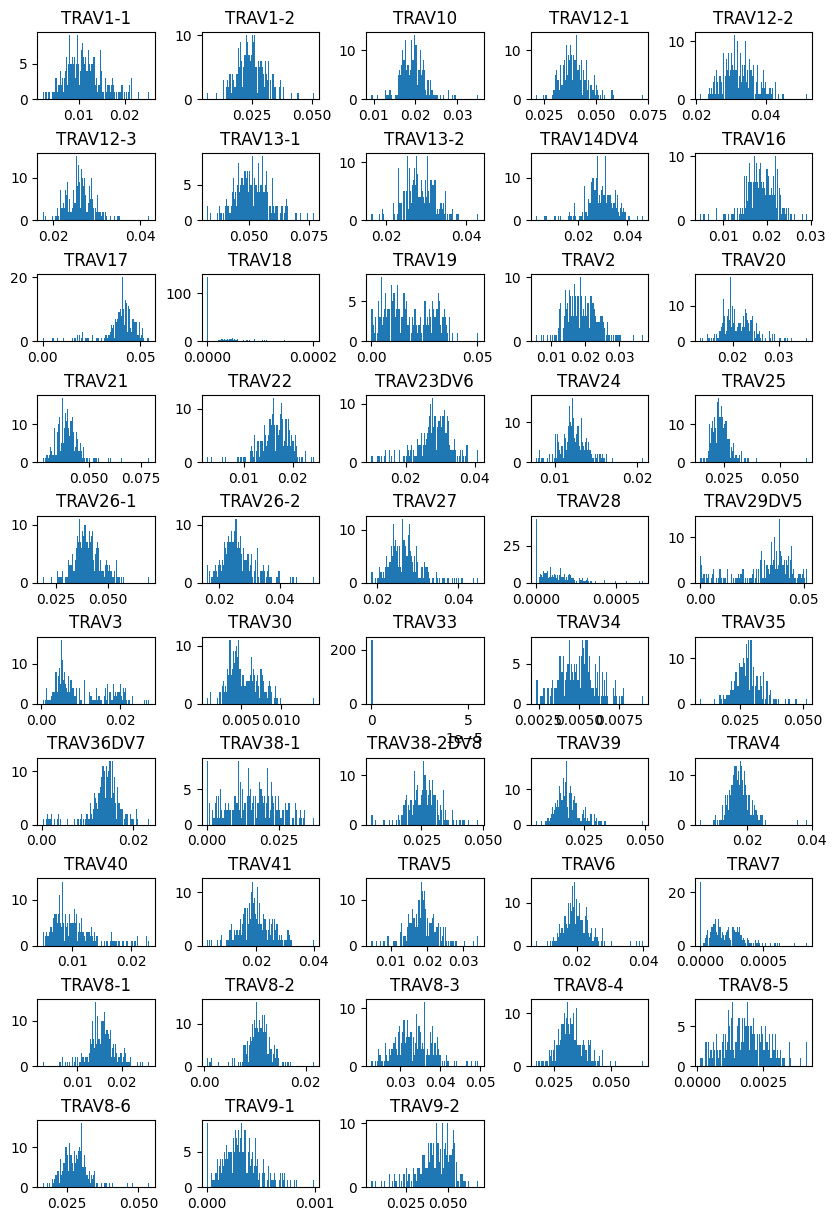

In [13]:
#TRA-V
plot_hist_usage(a_v_gene_names, trav_matrix, file_name='../pictures/TRAV_hist_gene_usage.png')

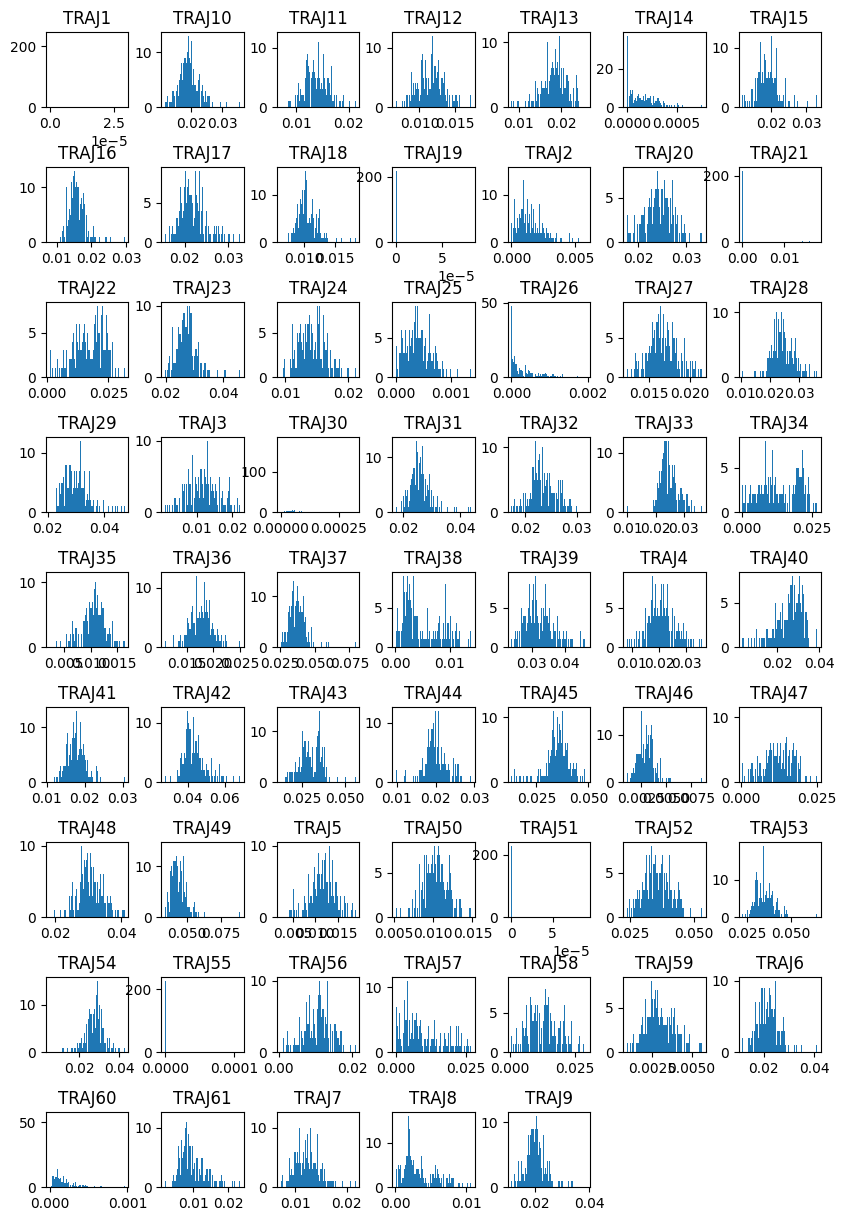

In [14]:
#TRA-J
plot_hist_usage(a_j_gene_names, traj_matrix, 7, file_name='../pictures/TRAJ_hist_gene_usage.png')

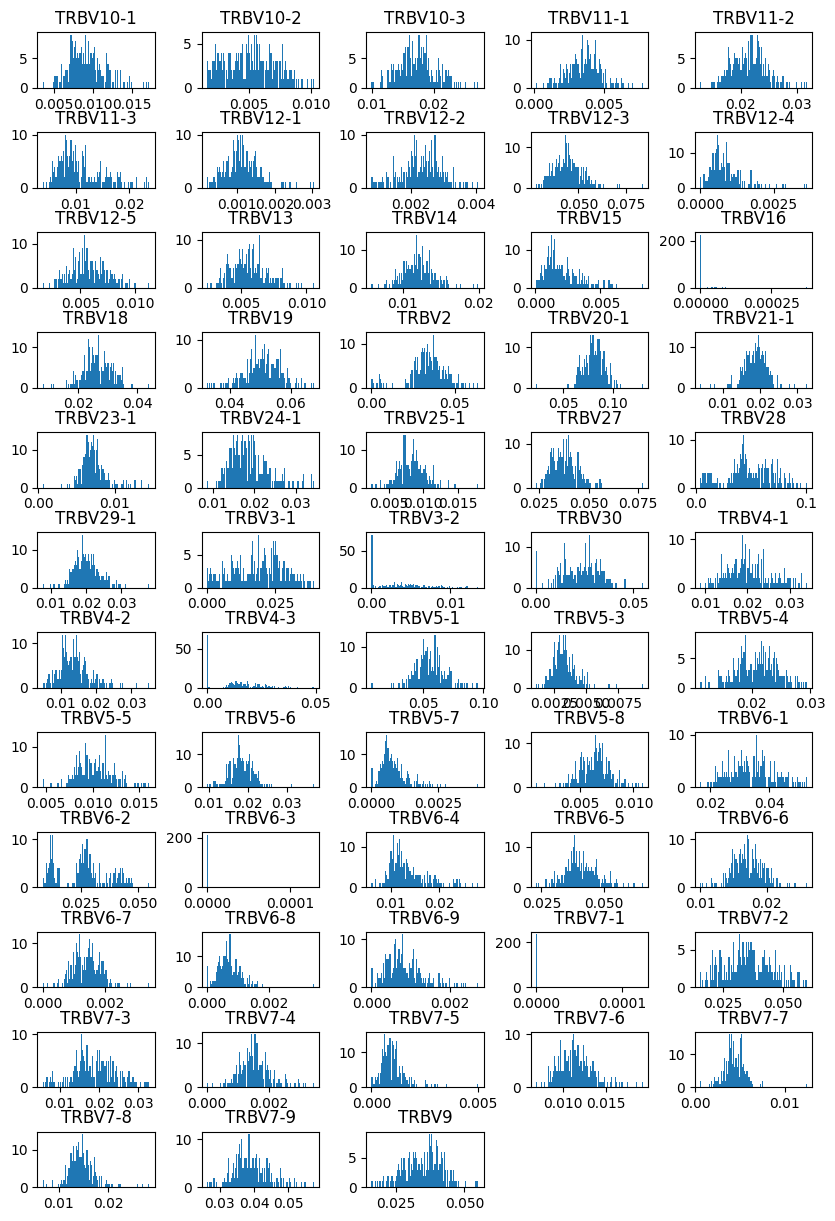

In [15]:
#TRB-V
plot_hist_usage(b_v_gene_names, trbv_matrix, file_name='../pictures/TRBV_hist_gene_usage.png')

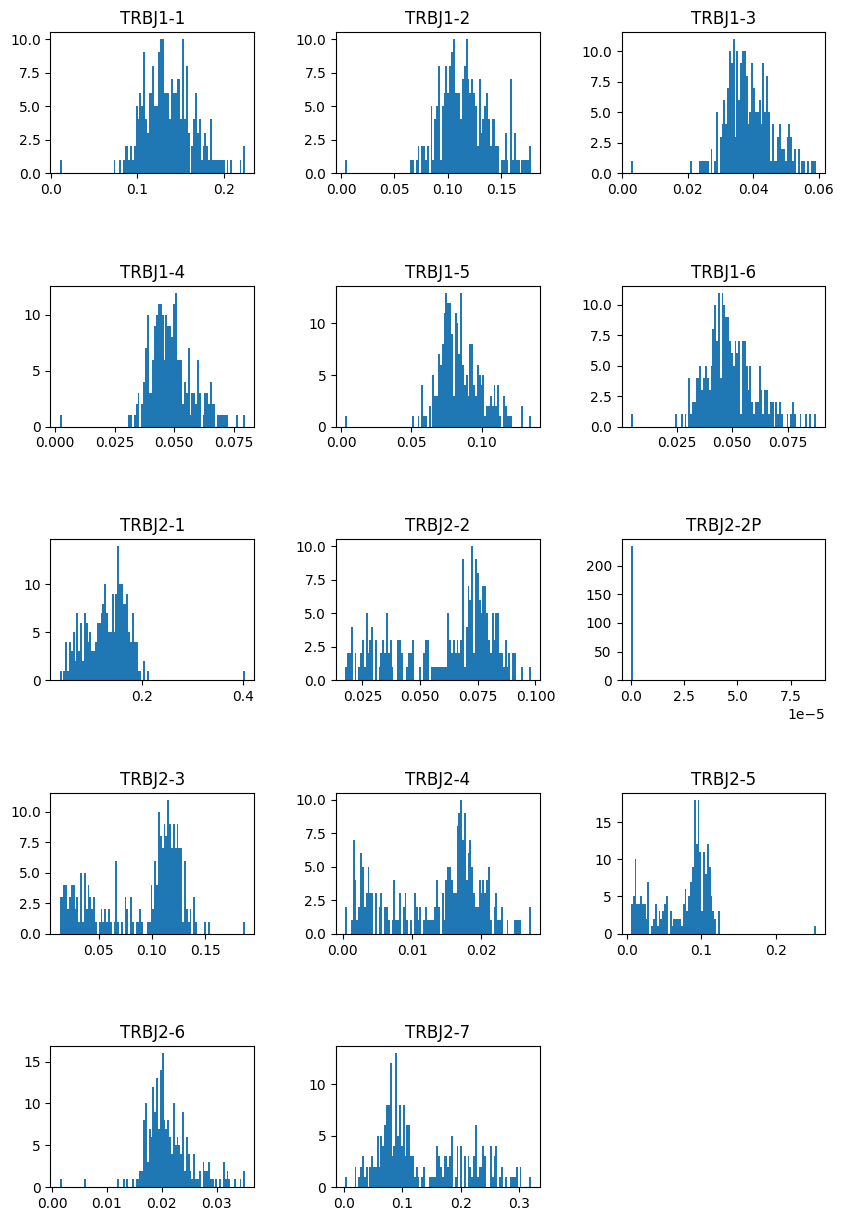

In [16]:
#TRB-J
plot_hist_usage(b_j_gene_names, trbj_matrix, 3, file_name='../pictures/TRBJ_hist_gene_usage.png')

## Gene-usage on population scale clustermaps

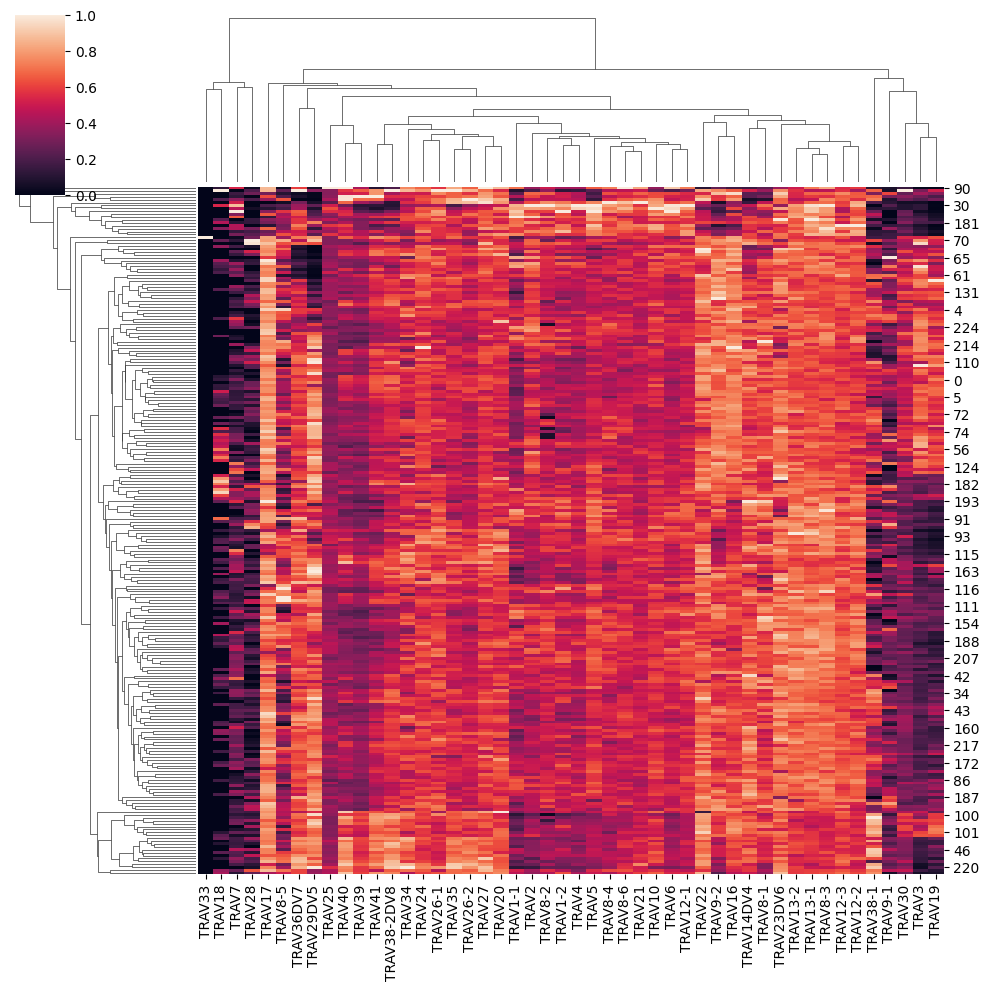

In [17]:
#TRA-V
sns.clustermap(trav_matrix.apply(lambda x: x / x.max()), xticklabels=True, vmin=0, vmax=1);
plt.savefig('../pictures/TRAV_clustermap_maxnorm.png', bbox_inches='tight')
plt.show();

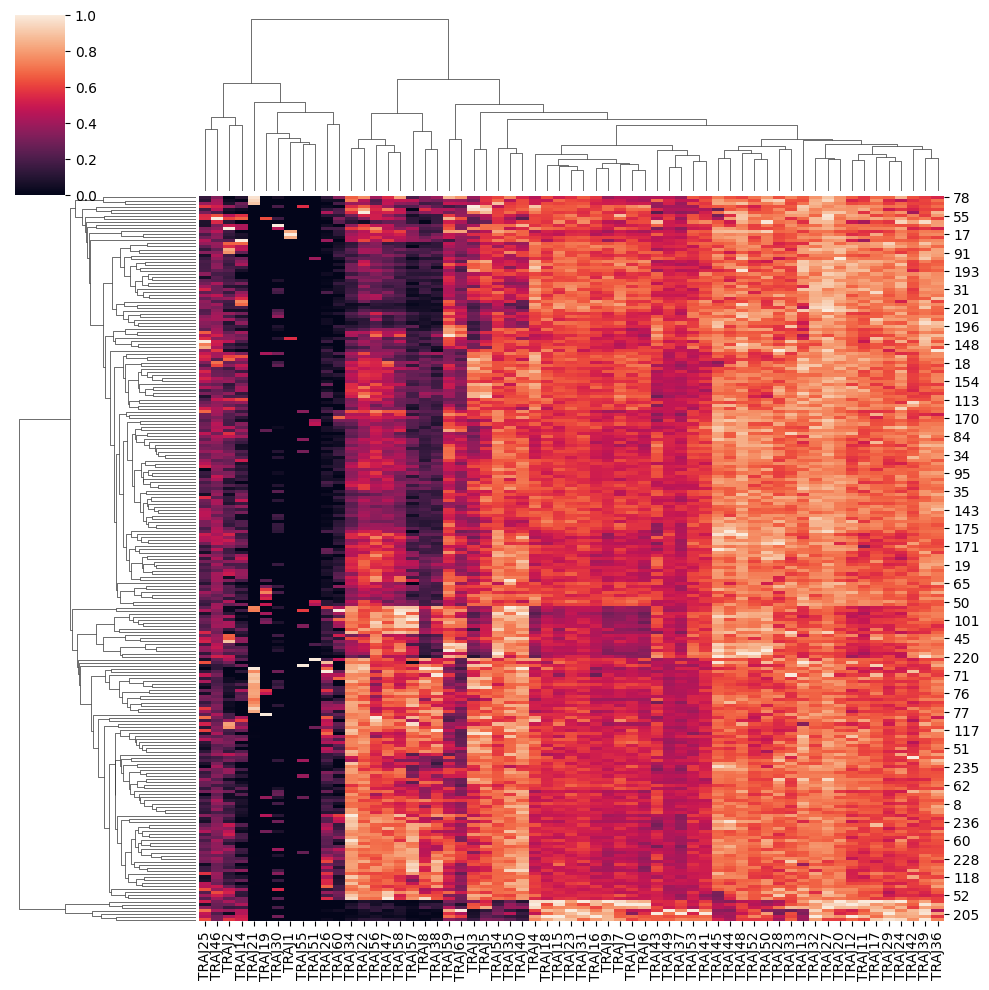

In [18]:
#TRA-J
sns.clustermap(traj_matrix.apply(lambda x: x / x.max()), xticklabels=True, vmin=0, vmax=1);
plt.savefig('../pictures/TRAJ_clustermap_maxnorm.png', bbox_inches='tight')
plt.show();

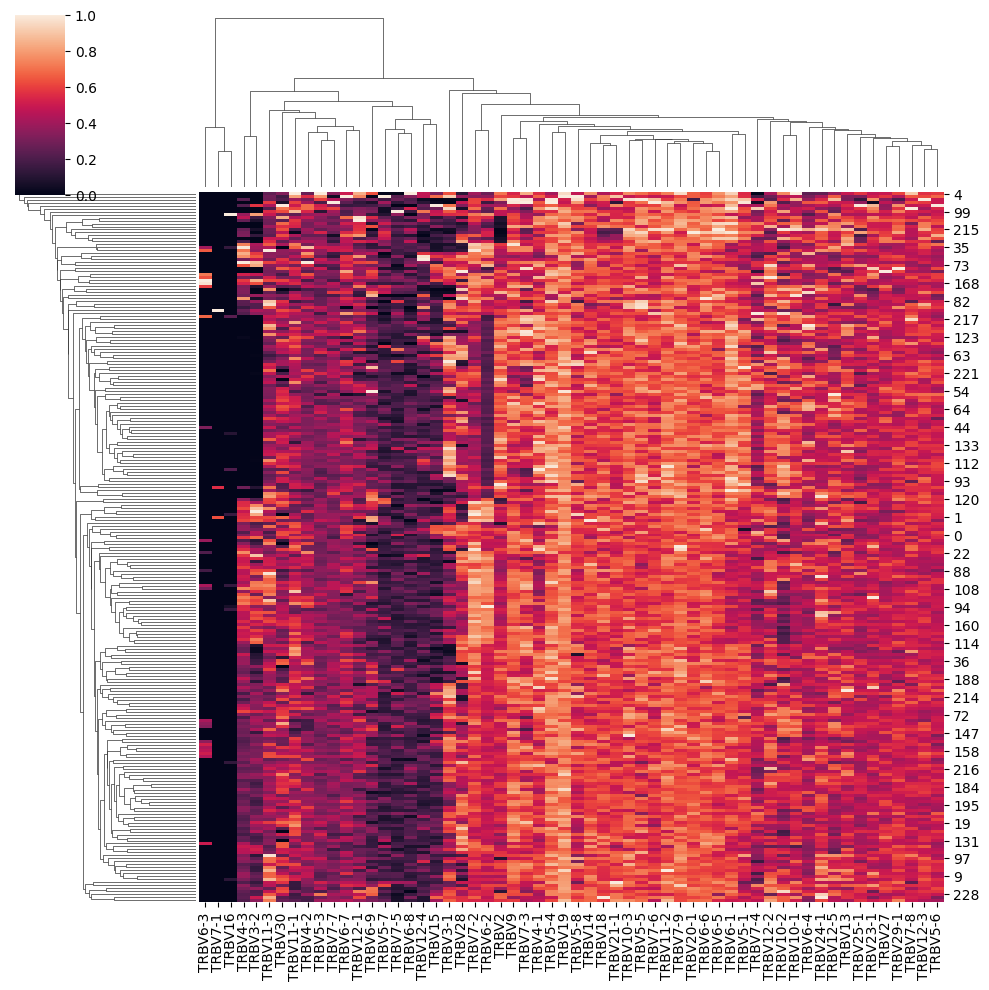

In [19]:
#TRB-V
sns.clustermap(trbv_matrix.apply(lambda x: x / x.max()), xticklabels=True, vmin=0, vmax=1);
plt.savefig('../pictures/TRBV_clustermap_maxnorm.png', bbox_inches='tight')
plt.show();

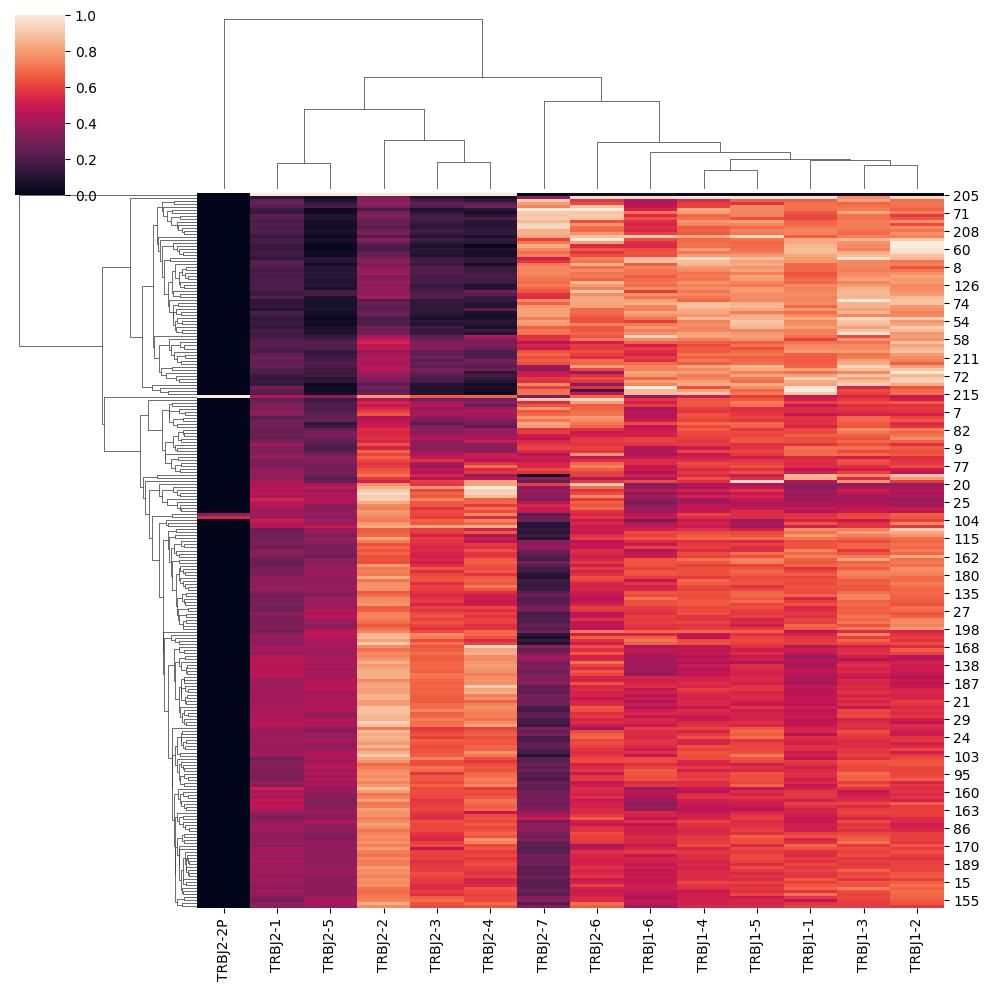

In [20]:
#TRB-J
sns.clustermap(trbj_matrix.apply(lambda x: x / x.max()), xticklabels=True, vmin=0, vmax=1);
plt.savefig('../pictures/TRBJ_clustermap_maxnorm.png', bbox_inches='tight')
plt.show();

## Correlations within TRα/β

<Figure size 1500x1500 with 0 Axes>

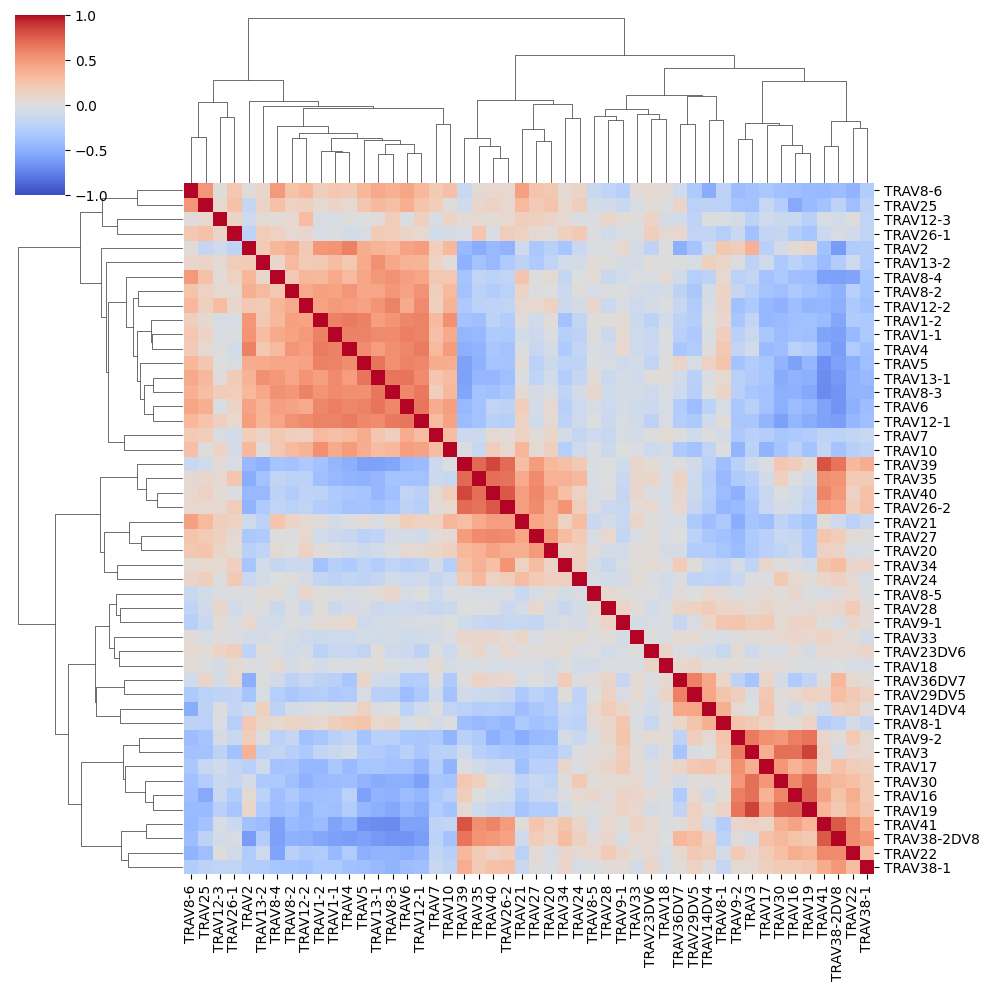

In [21]:
#TRA-V
plt.figure(figsize=(15,15))

corr_v_matrix = trav_matrix.corr() 
sns.clustermap(corr_v_matrix, cmap= 'coolwarm', yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 

plt.savefig('../pictures/TRAV_corr.png', bbox_inches='tight')
plt.show();

<Figure size 1500x1500 with 0 Axes>

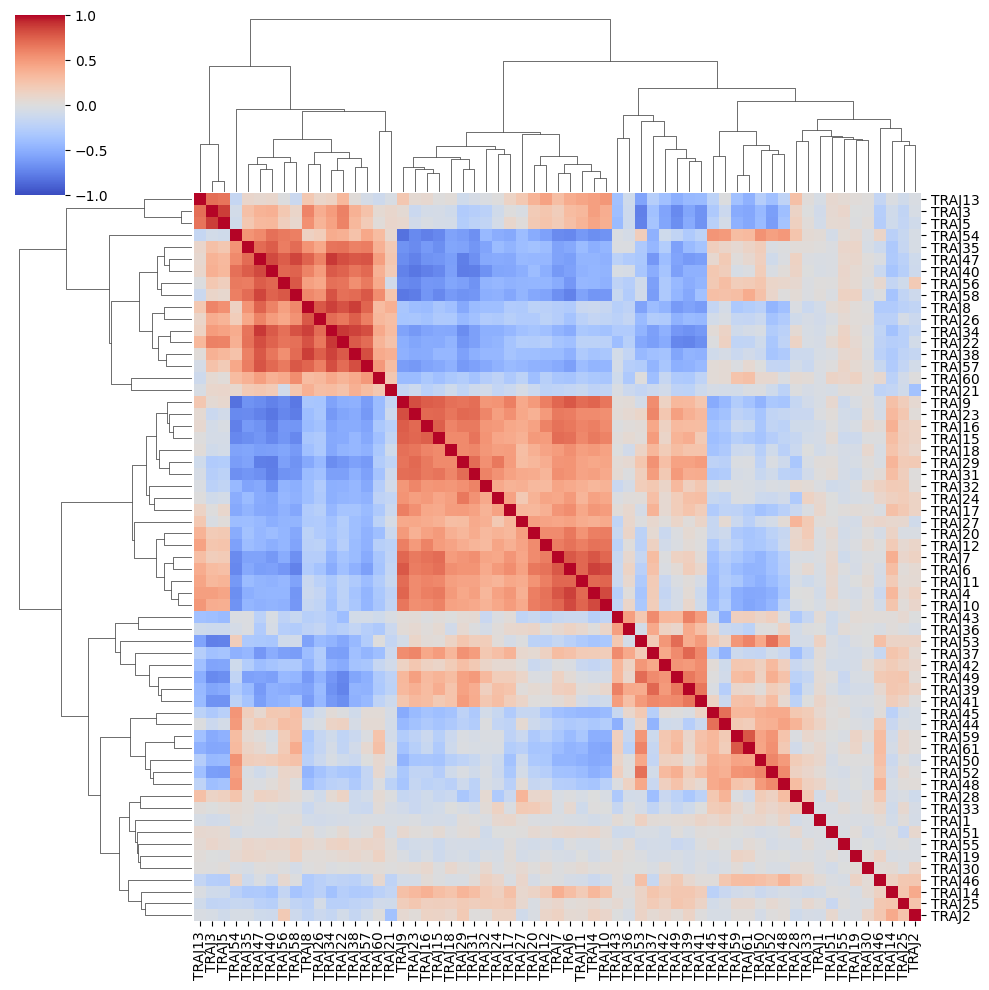

In [22]:
#TRA-J
plt.figure(figsize=(15,15))

corr_j_matrix = traj_matrix.corr() 
sns.clustermap(corr_j_matrix, cmap= 'coolwarm', yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 

plt.savefig('../pictures/TRAJ_corr.png', bbox_inches='tight')
plt.show();

<Figure size 1500x1500 with 0 Axes>

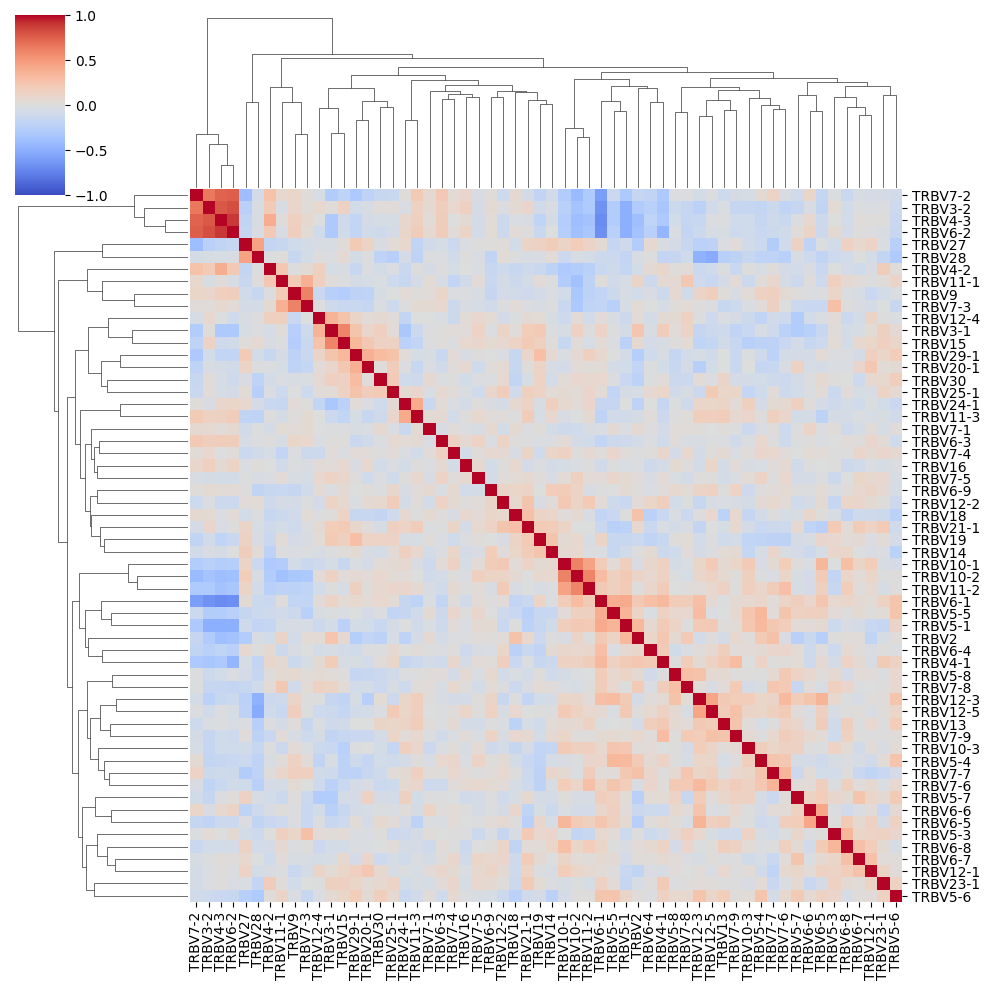

In [23]:
#TRB-V
plt.figure(figsize=(15,15))

corr_v_matrix = trbv_matrix.corr() 
sns.clustermap(corr_v_matrix, cmap= 'coolwarm', yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 

plt.savefig('../pictures/TRBV_corr.png', bbox_inches='tight')
plt.show();

<Figure size 1500x1500 with 0 Axes>

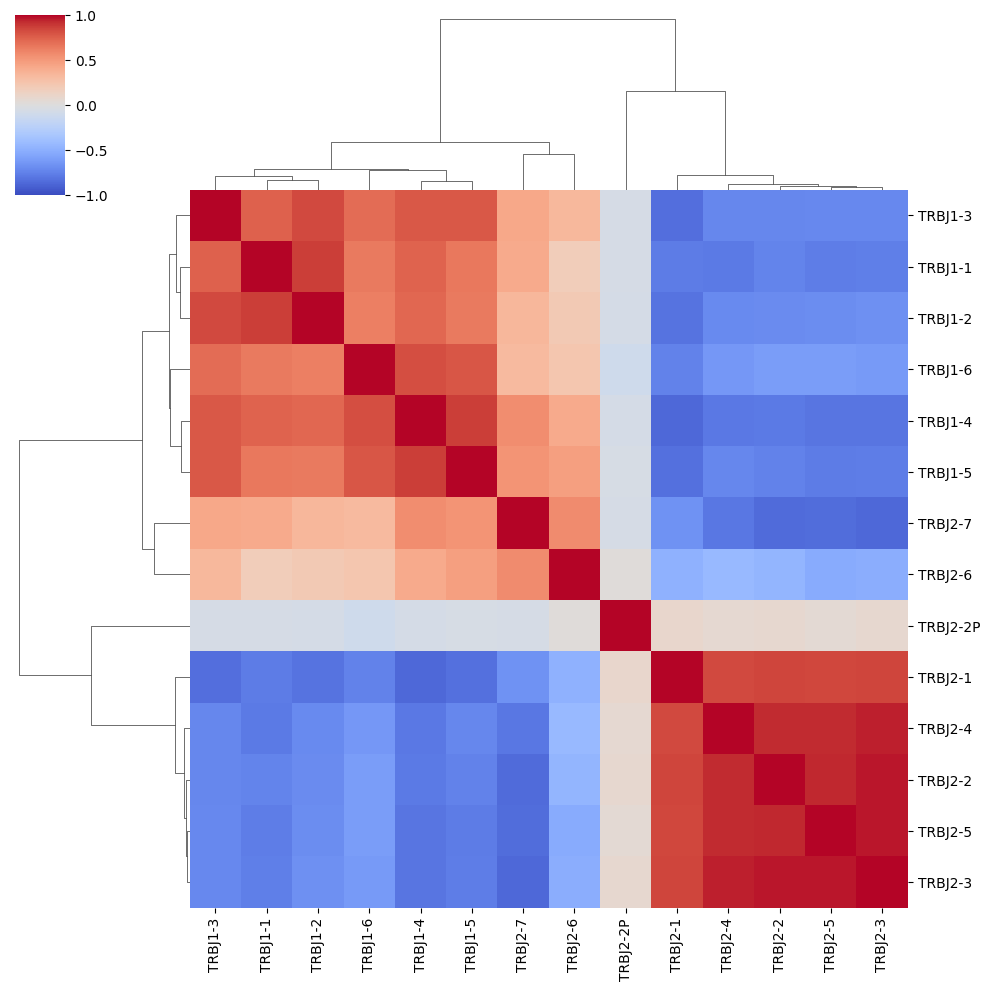

In [24]:
#TRB-J
plt.figure(figsize=(15,15))

corr_j_matrix = trbj_matrix.corr() 
sns.clustermap(corr_j_matrix, cmap= 'coolwarm', yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 

plt.savefig('../pictures/TRBJ_corr.png', bbox_inches='tight')
plt.show();

### correlation with p-value

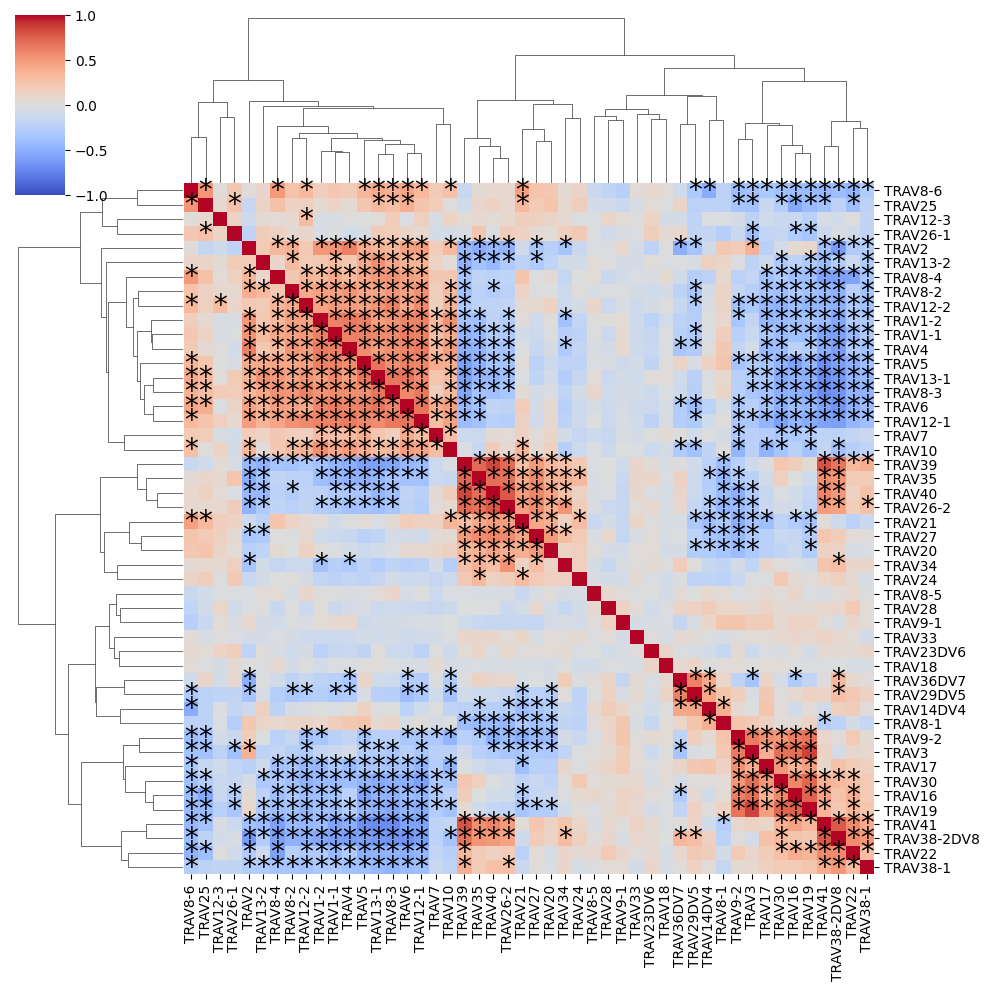

In [25]:
#TRA-V
correlations, p_values = get_correlations(trav_matrix, True)
g = sns.clustermap(correlations, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=True, xticklabels=True)

for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if p_values[ix, jx] or p_values[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

plt.savefig('../pictures/TRAV_corr_with_p.png', bbox_inches='tight')
plt.show();

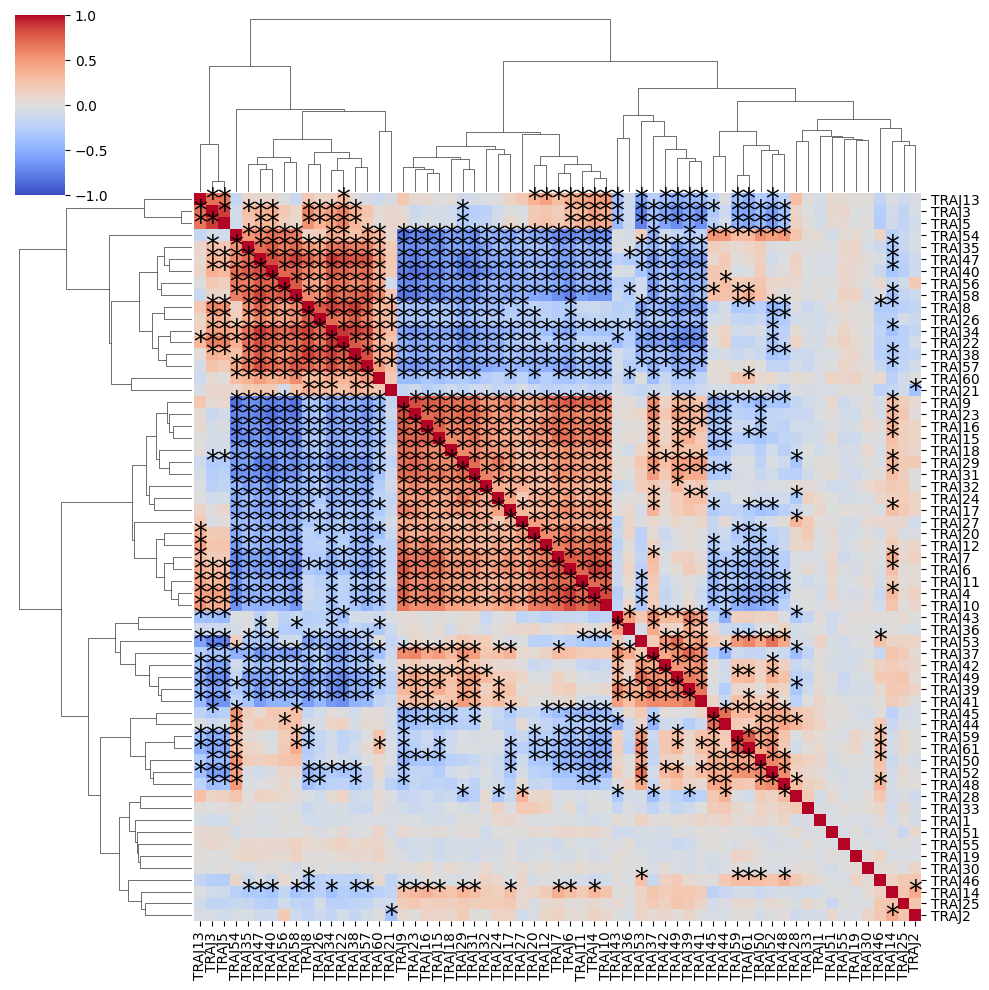

In [26]:
#TRA-J
correlations, p_values = get_correlations(traj_matrix, True)
g = sns.clustermap(correlations, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=True, xticklabels=True)

for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if p_values[ix, jx] or p_values[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

plt.savefig('../pictures/TRAJ_corr_with_p.png', bbox_inches='tight')
plt.show();

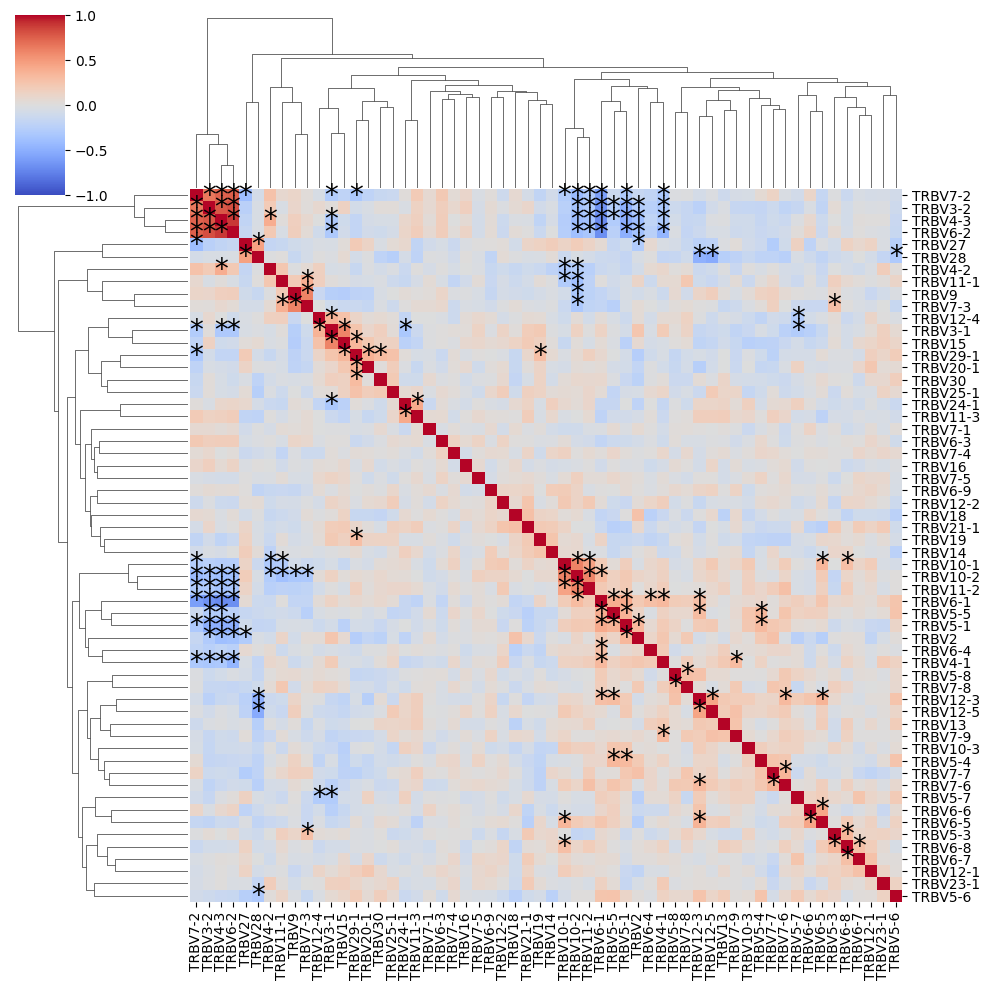

In [27]:
#TRB-V
correlations, p_values = get_correlations(trbv_matrix, True)
g = sns.clustermap(correlations, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=True, xticklabels=True)

for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if p_values[ix, jx] or p_values[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

plt.savefig('../pictures/TRBV_corr_with_p.png', bbox_inches='tight')
plt.show();

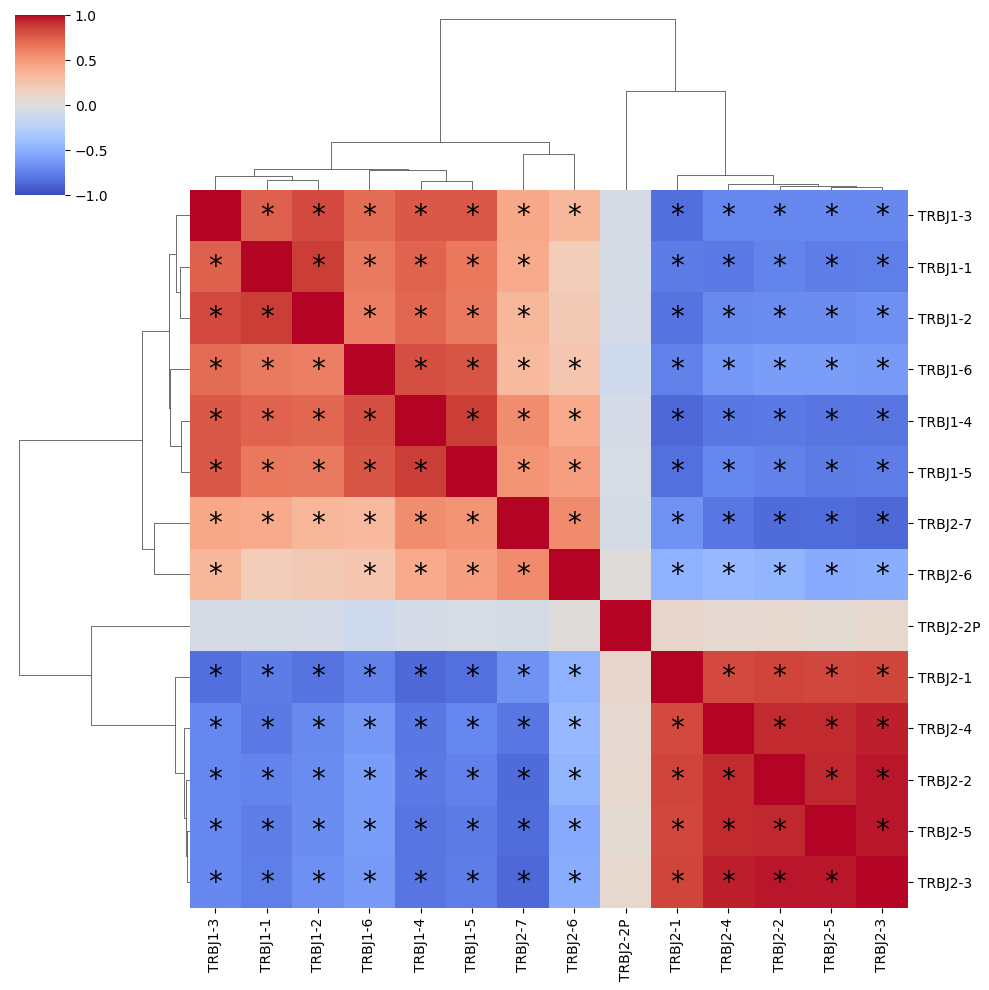

In [28]:
#TRB-J
correlations, p_values = get_correlations(trbj_matrix, True)
g = sns.clustermap(correlations, cmap='coolwarm', vmin=-1, vmax=1, yticklabels=True, xticklabels=True)

for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if p_values[ix, jx] or p_values[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

plt.savefig('../pictures/TRBJ_corr_with_p.png', bbox_inches='tight')
plt.show();

## Correlations between TRα/β

<Figure size 1500x1500 with 0 Axes>

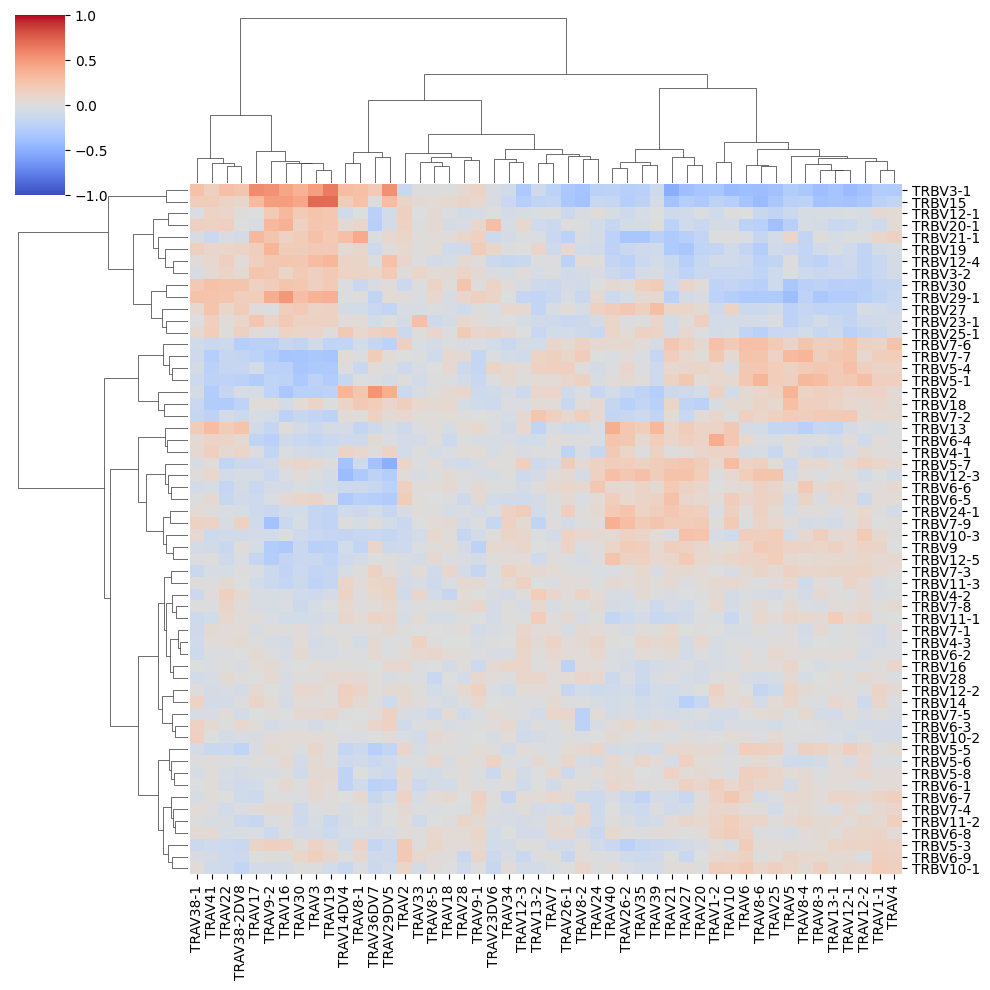

In [29]:
#TRA/B - V
cor_table_v = trav_matrix.apply(trbv_matrix.corrwith)
plt.figure(figsize=(15,15))

sns.clustermap(cor_table_v, cmap='coolwarm', method = "ward", yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 
plt.savefig('../pictures/TR_AB_v_corr.png', bbox_inches='tight')
plt.show();

<Figure size 1500x1500 with 0 Axes>

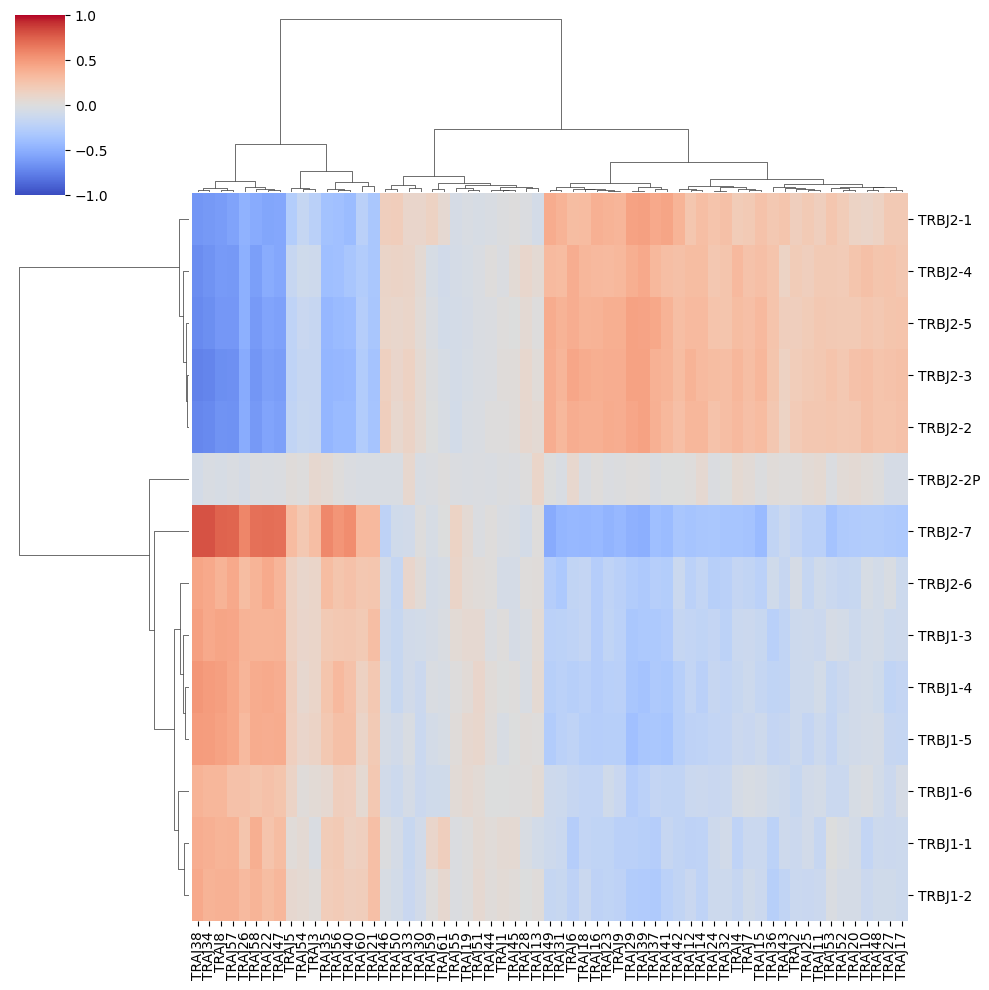

In [30]:
#TRA/B - J
cor_table_j = traj_matrix.apply(trbj_matrix.corrwith)
plt.figure(figsize=(15,15))

sns.clustermap(cor_table_j, cmap='coolwarm', method = "ward", yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 
plt.savefig('../pictures/TR_AB_j_corr.png', bbox_inches='tight')
plt.show();

<Figure size 1500x1500 with 0 Axes>

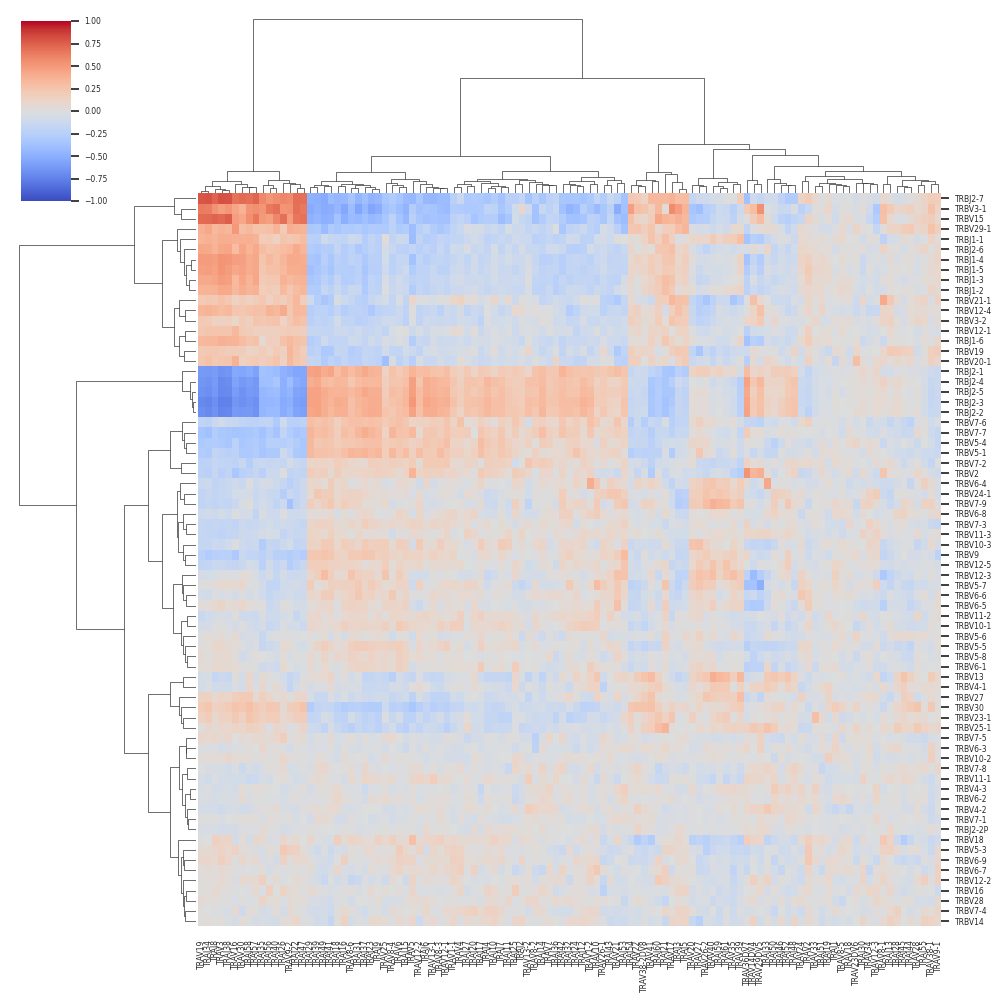

In [31]:
#TRA/B - V+J 
tra_matrix = pd.merge(trav_matrix, traj_matrix, left_index=True, right_index=True)
trb_matrix = pd.merge(trbv_matrix, trbj_matrix, left_index=True, right_index=True)

cor_table = tra_matrix.apply(trb_matrix.corrwith)

plt.figure(figsize=(15,15))
sns.set(font_scale=0.5)
sns.clustermap(cor_table, cmap= 'coolwarm', method = "ward", yticklabels=True, xticklabels=True, vmin=-1, vmax=1) 
plt.savefig('../pictures/TR_AB_vj_corr.png', bbox_inches='tight')
plt.show();

# Alpha chain: Nonfunctional vs Onlyfunctional sequences

In [23]:
#nonfunc TRA-V
nf_trav_matrix = pd.read_csv('../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRA.csv')
nf_trav_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trav_matrix.head(3)

TRAV10    TRAV20    TRAV17    TRAV39    TRAV28   TRAV8-3    TRAV30  \
0  0.026279  0.021812  0.043741  0.034053  0.000058  0.020942  0.007077   
1  0.022796  0.021001  0.039660  0.023421  0.000312  0.024826  0.007261   
2  0.028721  0.019497  0.044518  0.027451  0.000276  0.025904  0.008119   

   TRAV14DV4    TRAV40     TRAV2  ...    TRAV35  TRAV13-1  TRAV38-1    TRAV16  \
0   0.028310  0.019782  0.015373  ...  0.035213  0.042290  0.021812  0.027033   
1   0.036381  0.013975  0.020532  ...  0.027246  0.044032  0.015302  0.026700   
2   0.032477  0.016680  0.020768  ...  0.031207  0.043524  0.016846  0.026291   

    TRAV1-2     TRAV4    TRAV24   TRAV8-6    TRAV19    TRAV25  
0  0.011950  0.012763  0.009688  0.020652  0.034981  0.022392  
1  0.017175  0.017410  0.010071  0.020689  0.039972  0.018815  
2  0.021983  0.015742  0.009887  0.020436  0.033306  0.021154  

[3 rows x 48 columns]

In [24]:
#nonfunc TRA-J
nf_traj_matrix = pd.read_csv('../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRA.csv')
nf_traj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_traj_matrix.head(3)

TRAJ5    TRAJ30    TRAJ17    TRAJ26    TRAJ58    TRAJ41    TRAJ24  \
0  0.012066  0.000058  0.019956  0.000638  0.033008  0.015431  0.011312   
1  0.013975  0.000000  0.040284  0.000703  0.024046  0.013740  0.014599   
2  0.011544  0.000000  0.020436  0.000331  0.028556  0.016570  0.015244   

     TRAJ56     TRAJ2    TRAJ52  ...    TRAJ32    TRAJ61    TRAJ14    TRAJ18  \
0  0.015663  0.002669  0.036025  ...  0.023263  0.020362  0.000000  0.008992   
1  0.014599  0.005933  0.035210  ...  0.020689  0.013428  0.000468  0.008666   
2  0.016736  0.004032  0.033858  ...  0.022922  0.015742  0.000000  0.008893   

     TRAJ59    TRAJ20    TRAJ57    TRAJ12    TRAJ46     TRAJ7  
0  0.005337  0.017055  0.024249  0.007193  0.003191  0.009920  
1  0.004528  0.018659  0.022875  0.008197  0.002654  0.013038  
2  0.005081  0.016018  0.010218  0.009721  0.002983  0.011875  

[3 rows x 61 columns]

In [25]:
#onlyfunc TRA-V
of_trav_matrix = pd.read_csv('../data/cohort_I/onlyfunctional_corrected/of_v_clonotypes_TRA.csv')
of_trav_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trav_matrix.head(3)

TRAV1-2   TRAV8-2    TRAV17    TRAV41    TRAV20    TRAV24    TRAV30  \
0  0.023730  0.010883  0.035462  0.020704  0.022403  0.014333  0.006636   
1  0.019746  0.014457  0.042724  0.017337  0.019041  0.015162  0.006876   
2  0.026838  0.010294  0.036082  0.020221  0.018960  0.013498  0.007773   

     TRAV10    TRAV18  TRAV12-3  ...   TRAV1-1  TRAV12-2     TRAV2  TRAV12-1  \
0  0.017625  0.000053  0.030472  ...  0.007804  0.036895  0.014758  0.035303   
1  0.014868  0.000059  0.029560  ...  0.009520  0.022802  0.025094  0.035437   
2  0.019433  0.000000  0.026996  ...  0.007878  0.039706  0.025053  0.040074   

      TRAV3  TRAV13-1   TRAV8-3  TRAV23DV6  TRAV29DV5    TRAV34  
0  0.017094  0.042204  0.031321   0.020226   0.033976  0.005415  
1  0.018512  0.050188  0.036142   0.027739   0.038963  0.004173  
2  0.019275  0.046849  0.035767   0.026103   0.021586  0.004622  

[3 rows x 47 columns]

In [26]:
#nonfunc TRA-J
of_traj_matrix = pd.read_csv('../data/cohort_I/onlyfunctional_corrected/of_j_clonotypes_TRA.csv')
of_traj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_traj_matrix.head(3)

TRAJ45    TRAJ14    TRAJ26    TRAJ53    TRAJ10    TRAJ16  TRAJ1  \
0  0.034400  0.000000  0.000690  0.029251  0.018740  0.013378    0.0   
1  0.035085  0.000059  0.000882  0.032205  0.021098  0.012811    0.0   
2  0.030357  0.000053  0.000840  0.026681  0.019905  0.014023    0.0   

     TRAJ31    TRAJ15    TRAJ37  ...  TRAJ55    TRAJ49    TRAJ46    TRAJ39  \
0  0.024898  0.020757  0.033976  ...     0.0  0.038860  0.001646  0.031852   
1  0.028444  0.018630  0.028620  ...     0.0  0.038728  0.003232  0.026152   
2  0.025525  0.018908  0.032931  ...     0.0  0.038813  0.002048  0.029307   

     TRAJ21    TRAJ18    TRAJ11    TRAJ52  TRAJ60    TRAJ28  
0  0.000000  0.009184  0.014493  0.033657     0.0  0.024102  
1  0.000059  0.010872  0.014810  0.031147     0.0  0.022743  
2  0.000000  0.010557  0.015966  0.031775     0.0  0.023057  

[3 rows x 61 columns]

In [27]:
v_gene_names_set_a = set(nf_trav_matrix.columns).intersection(set(of_trav_matrix.columns)) 
j_gene_names_set_a = set(nf_traj_matrix.columns).intersection(set(of_traj_matrix.columns))

v_gene_names_set_a = list(v_gene_names_set_a)
v_gene_names_set_a.sort()
j_gene_names_set_a = list(j_gene_names_set_a)
j_gene_names_set_a.sort()

## Gene usage on population scale histograms

### Nonfunctional

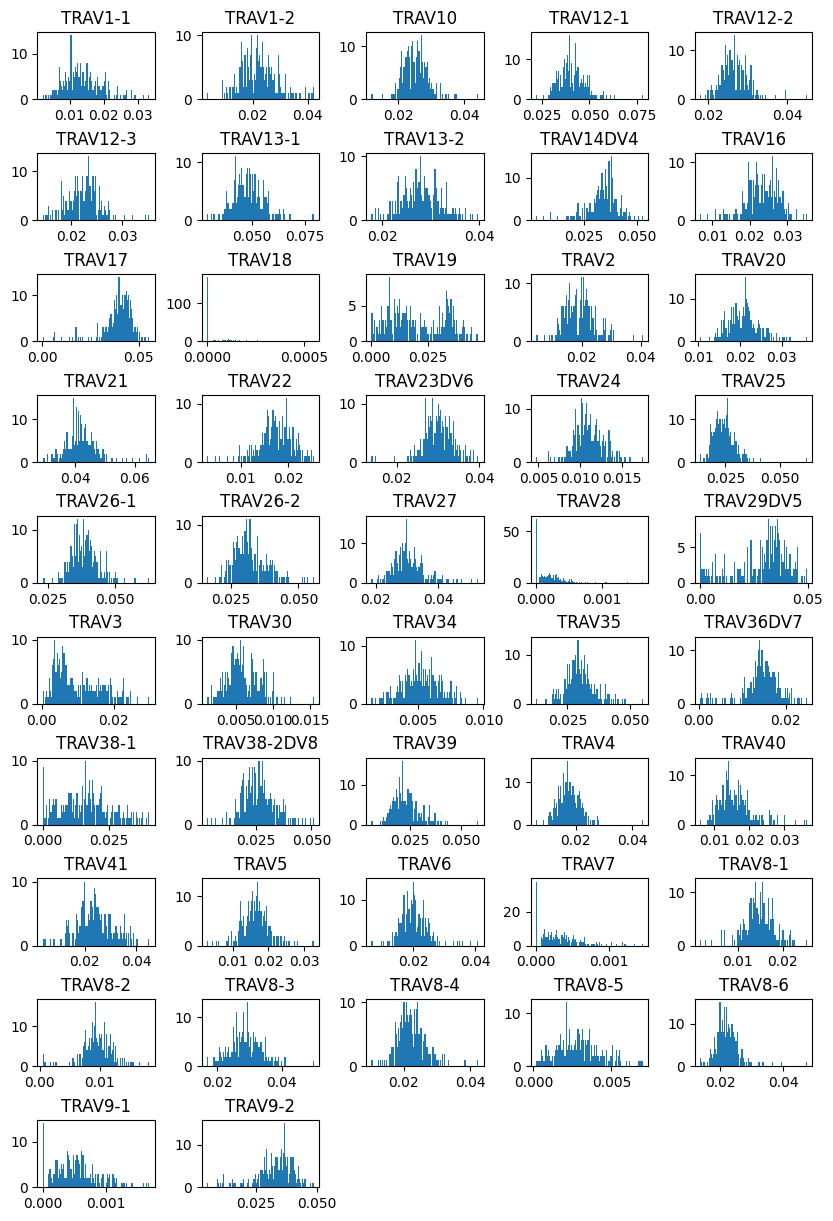

In [30]:
#nonfunc TRA-V
plot_hist_usage(v_gene_names_set_a, nf_trav_matrix)

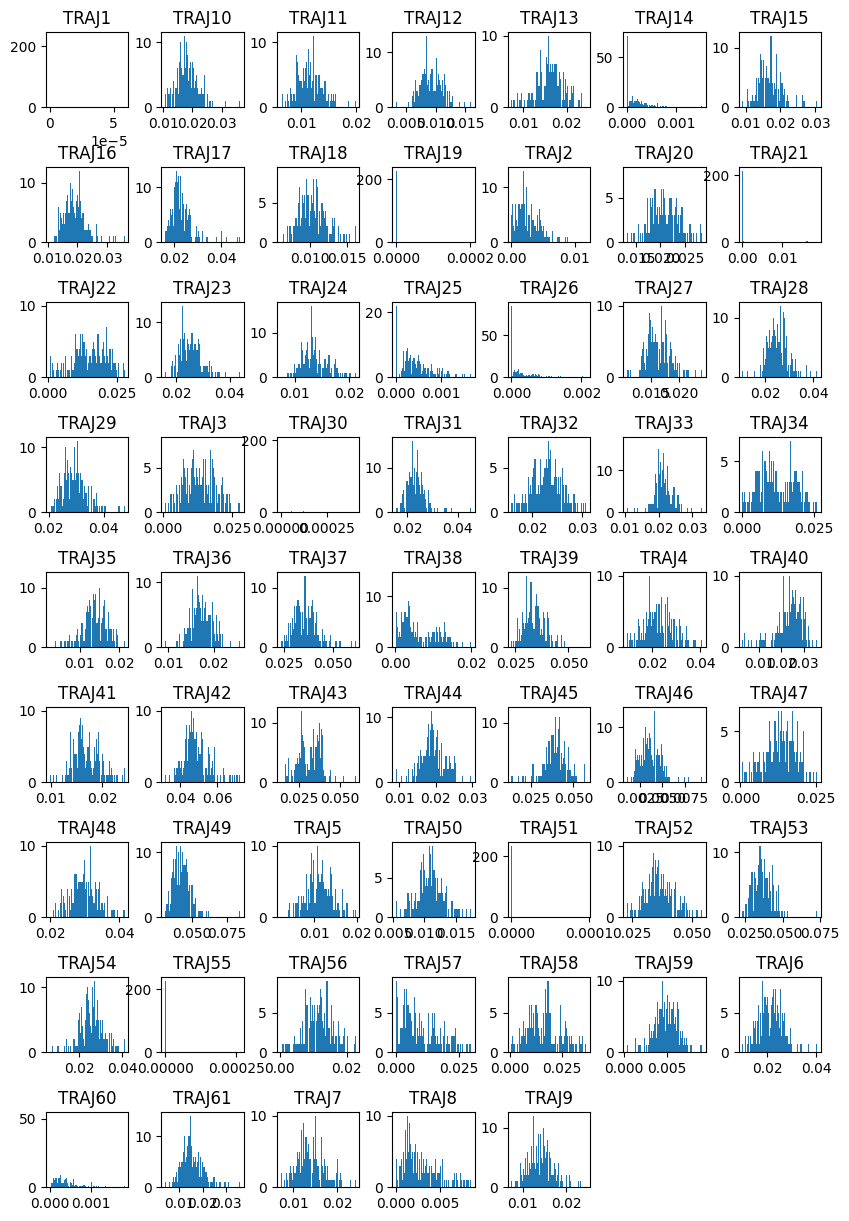

In [31]:
#nonfunc TRA-J
plot_hist_usage(j_gene_names_set_a, nf_traj_matrix, 7)

### Onlyfunctional

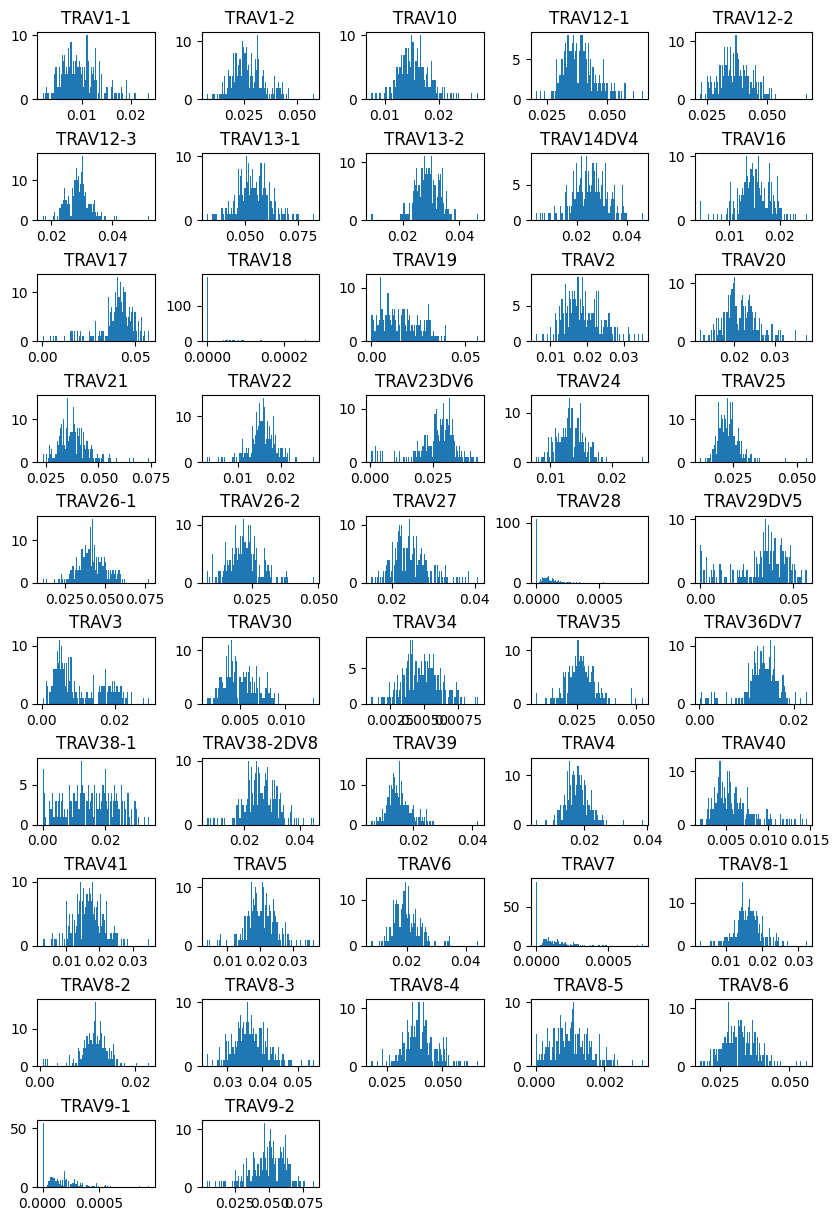

In [32]:
#onlyfunc TRA-V
plot_hist_usage(v_gene_names_set_a, of_trav_matrix)

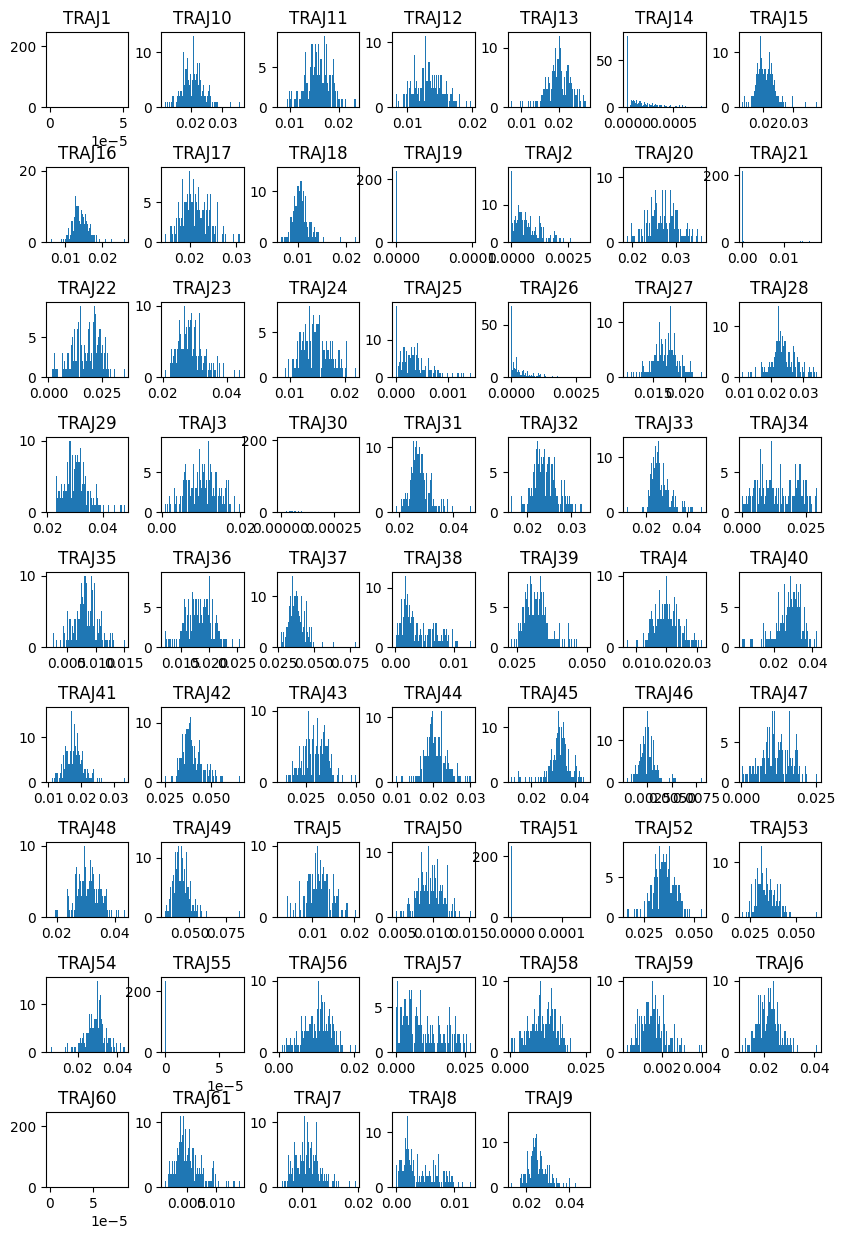

In [33]:
#onlyfunc TRA-J
plot_hist_usage(j_gene_names_set_a, of_traj_matrix, 7)

## Joint histograms (Nonfunctional vs Onlyfunctional)

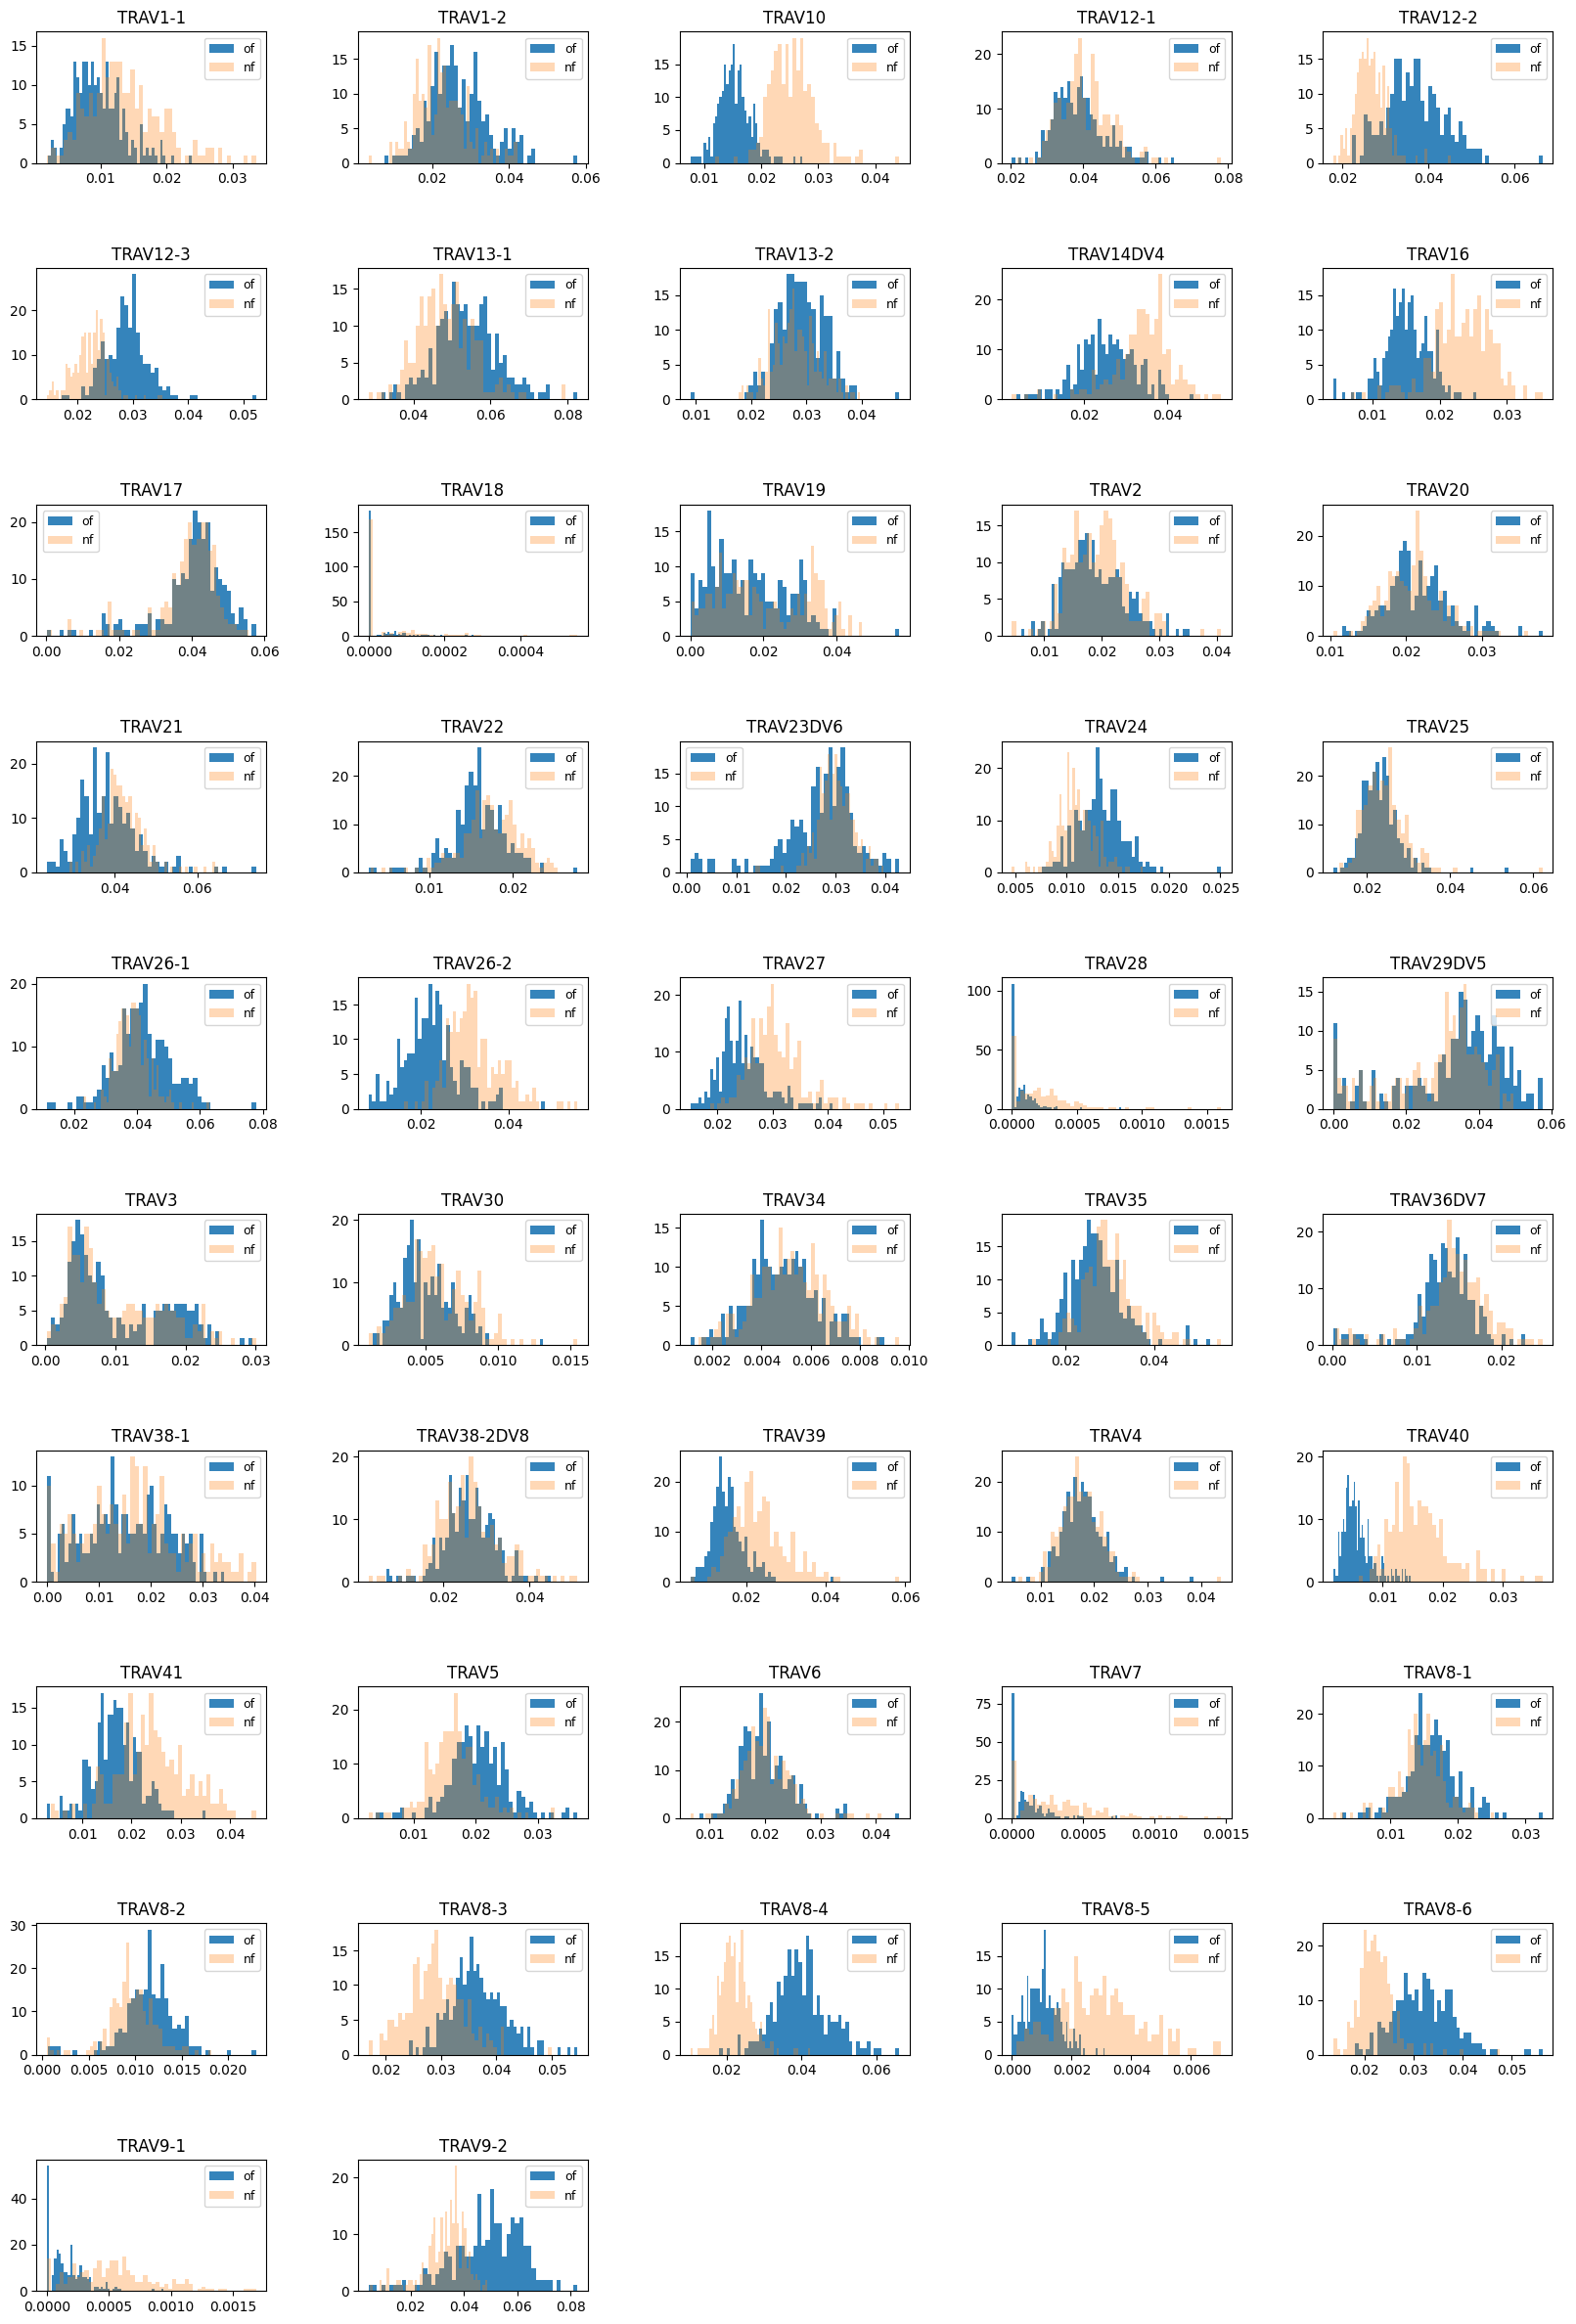

In [34]:
#onlyfunc & nonfunc TRA-V
plot_hist_of_vs_nf(v_gene_names_set_a, of_trav_matrix, nf_trav_matrix, file_name='../pictures/TRAV_hist_of_nf.png')

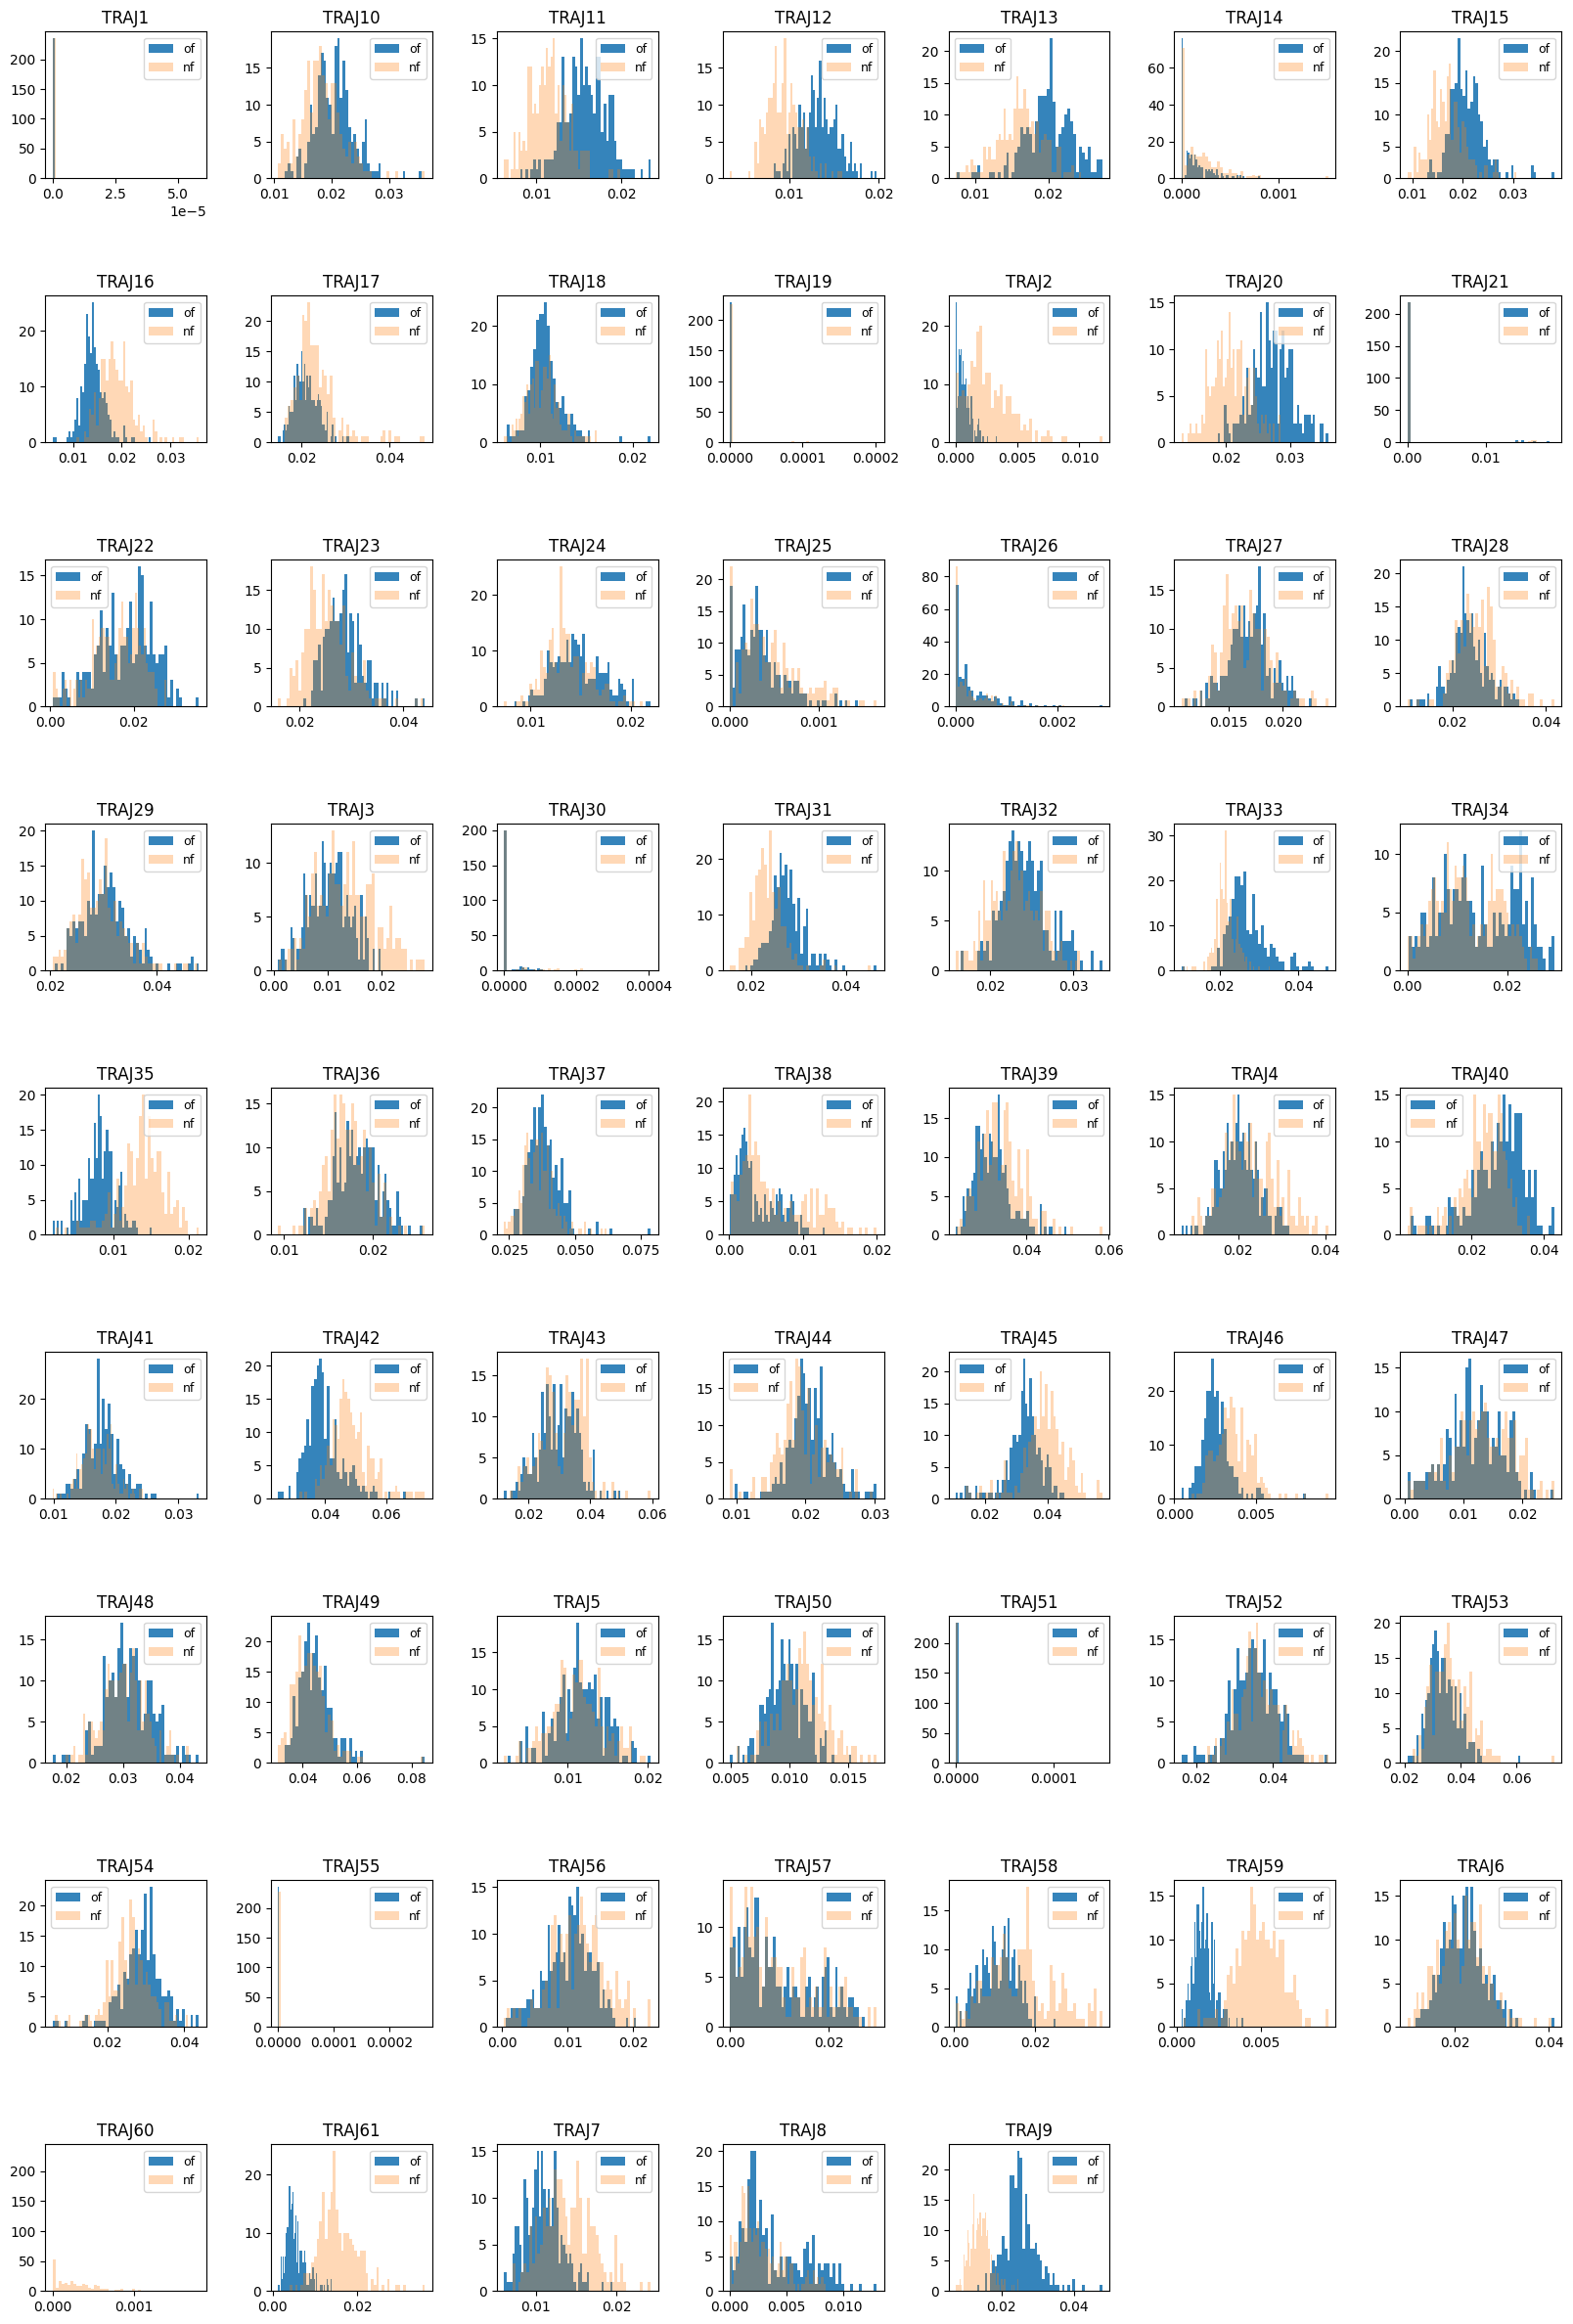

In [35]:
#onlyfunc & nonfunc TRA-J
plot_hist_of_vs_nf(j_gene_names_set_a, of_traj_matrix, nf_traj_matrix, 7, file_name='../pictures/TRAJ_hist_of_nf.png')

### Kolmogorov-Smirnov test for nf vs of

In [43]:
#TRA-V
trav_ks_test_p_values = calculate_p_value_ks_test(v_gene_names_set_a, of_trav_matrix, nf_trav_matrix, True)
trav_sign = {key: val for key, val in trav_ks_test_p_values.items() if val <= 0.05}
trav_sign

{'TRAV1-1': 1.2765272599273322e-11,
 'TRAV1-2': 1.381442256476327e-07,
 'TRAV10': 4.129820129128306e-101,
 'TRAV12-2': 4.502098337338974e-63,
 'TRAV12-3': 3.9402921826445546e-52,
 'TRAV13-1': 8.568891239962269e-10,
 'TRAV14DV4': 2.0180227468543693e-31,
 'TRAV16': 3.064465434988109e-68,
 'TRAV19': 0.0009734096906111982,
 'TRAV21': 6.381963907292425e-13,
 'TRAV22': 2.4534141788760786e-06,
 'TRAV23DV6': 7.559684009381855e-08,
 'TRAV24': 2.2102945236008307e-25,
 'TRAV26-1': 9.410170240478069e-05,
 'TRAV26-2': 3.494307461605536e-47,
 'TRAV27': 6.8575402601440136e-31,
 'TRAV28': 7.506402043916501e-17,
 'TRAV29DV5': 0.00039263971878664773,
 'TRAV30': 0.002329332280172239,
 'TRAV35': 4.098919576515486e-08,
 'TRAV36DV7': 0.001512448390250731,
 'TRAV39': 7.311267075454899e-36,
 'TRAV40': 9.827488345942415e-94,
 'TRAV41': 2.4420857095964234e-26,
 'TRAV5': 8.210213645932778e-19,
 'TRAV7': 1.2554835760937445e-22,
 'TRAV8-1': 0.0035559487468586285,
 'TRAV8-2': 2.7307903780090023e-14,
 'TRAV8-3': 1.2

In [44]:
#TRA-J
traj_ks_test_p_values = calculate_p_value_ks_test(j_gene_names_set_a, of_traj_matrix, nf_traj_matrix, True)
traj_sign = {key: val for key, val in traj_ks_test_p_values.items() if val <= 0.05}
traj_sign

{'TRAJ10': 5.319874343988184e-08,
 'TRAJ11': 9.916857393392903e-44,
 'TRAJ12': 7.401347281256829e-50,
 'TRAJ13': 3.3763871916549065e-28,
 'TRAJ15': 1.0691892773573872e-27,
 'TRAJ16': 4.535165003360377e-47,
 'TRAJ17': 4.506519623112934e-05,
 'TRAJ2': 4.778342070114172e-45,
 'TRAJ20': 9.300194022264246e-56,
 'TRAJ22': 0.033546323962477524,
 'TRAJ23': 8.282974432868892e-13,
 'TRAJ24': 0.00019838014939782962,
 'TRAJ25': 0.004615167522518645,
 'TRAJ28': 0.0030231759380958847,
 'TRAJ3': 1.8240721311595925e-06,
 'TRAJ31': 7.615422333902908e-32,
 'TRAJ32': 0.015576430102579733,
 'TRAJ33': 6.33915149262999e-40,
 'TRAJ34': 0.004615167522518645,
 'TRAJ35': 6.407104197273163e-70,
 'TRAJ36': 0.015576430102579733,
 'TRAJ37': 0.010475697709841124,
 'TRAJ38': 5.508331833986754e-06,
 'TRAJ39': 0.00012213199673811963,
 'TRAJ4': 0.010475697709841124,
 'TRAJ40': 3.420427194753812e-11,
 'TRAJ42': 6.33915149262999e-40,
 'TRAJ44': 7.452121834868316e-05,
 'TRAJ45': 1.0691892773573872e-27,
 'TRAJ46': 9.5891273

## Scatterplots (Nonfunctional vs Onlyfunctional)

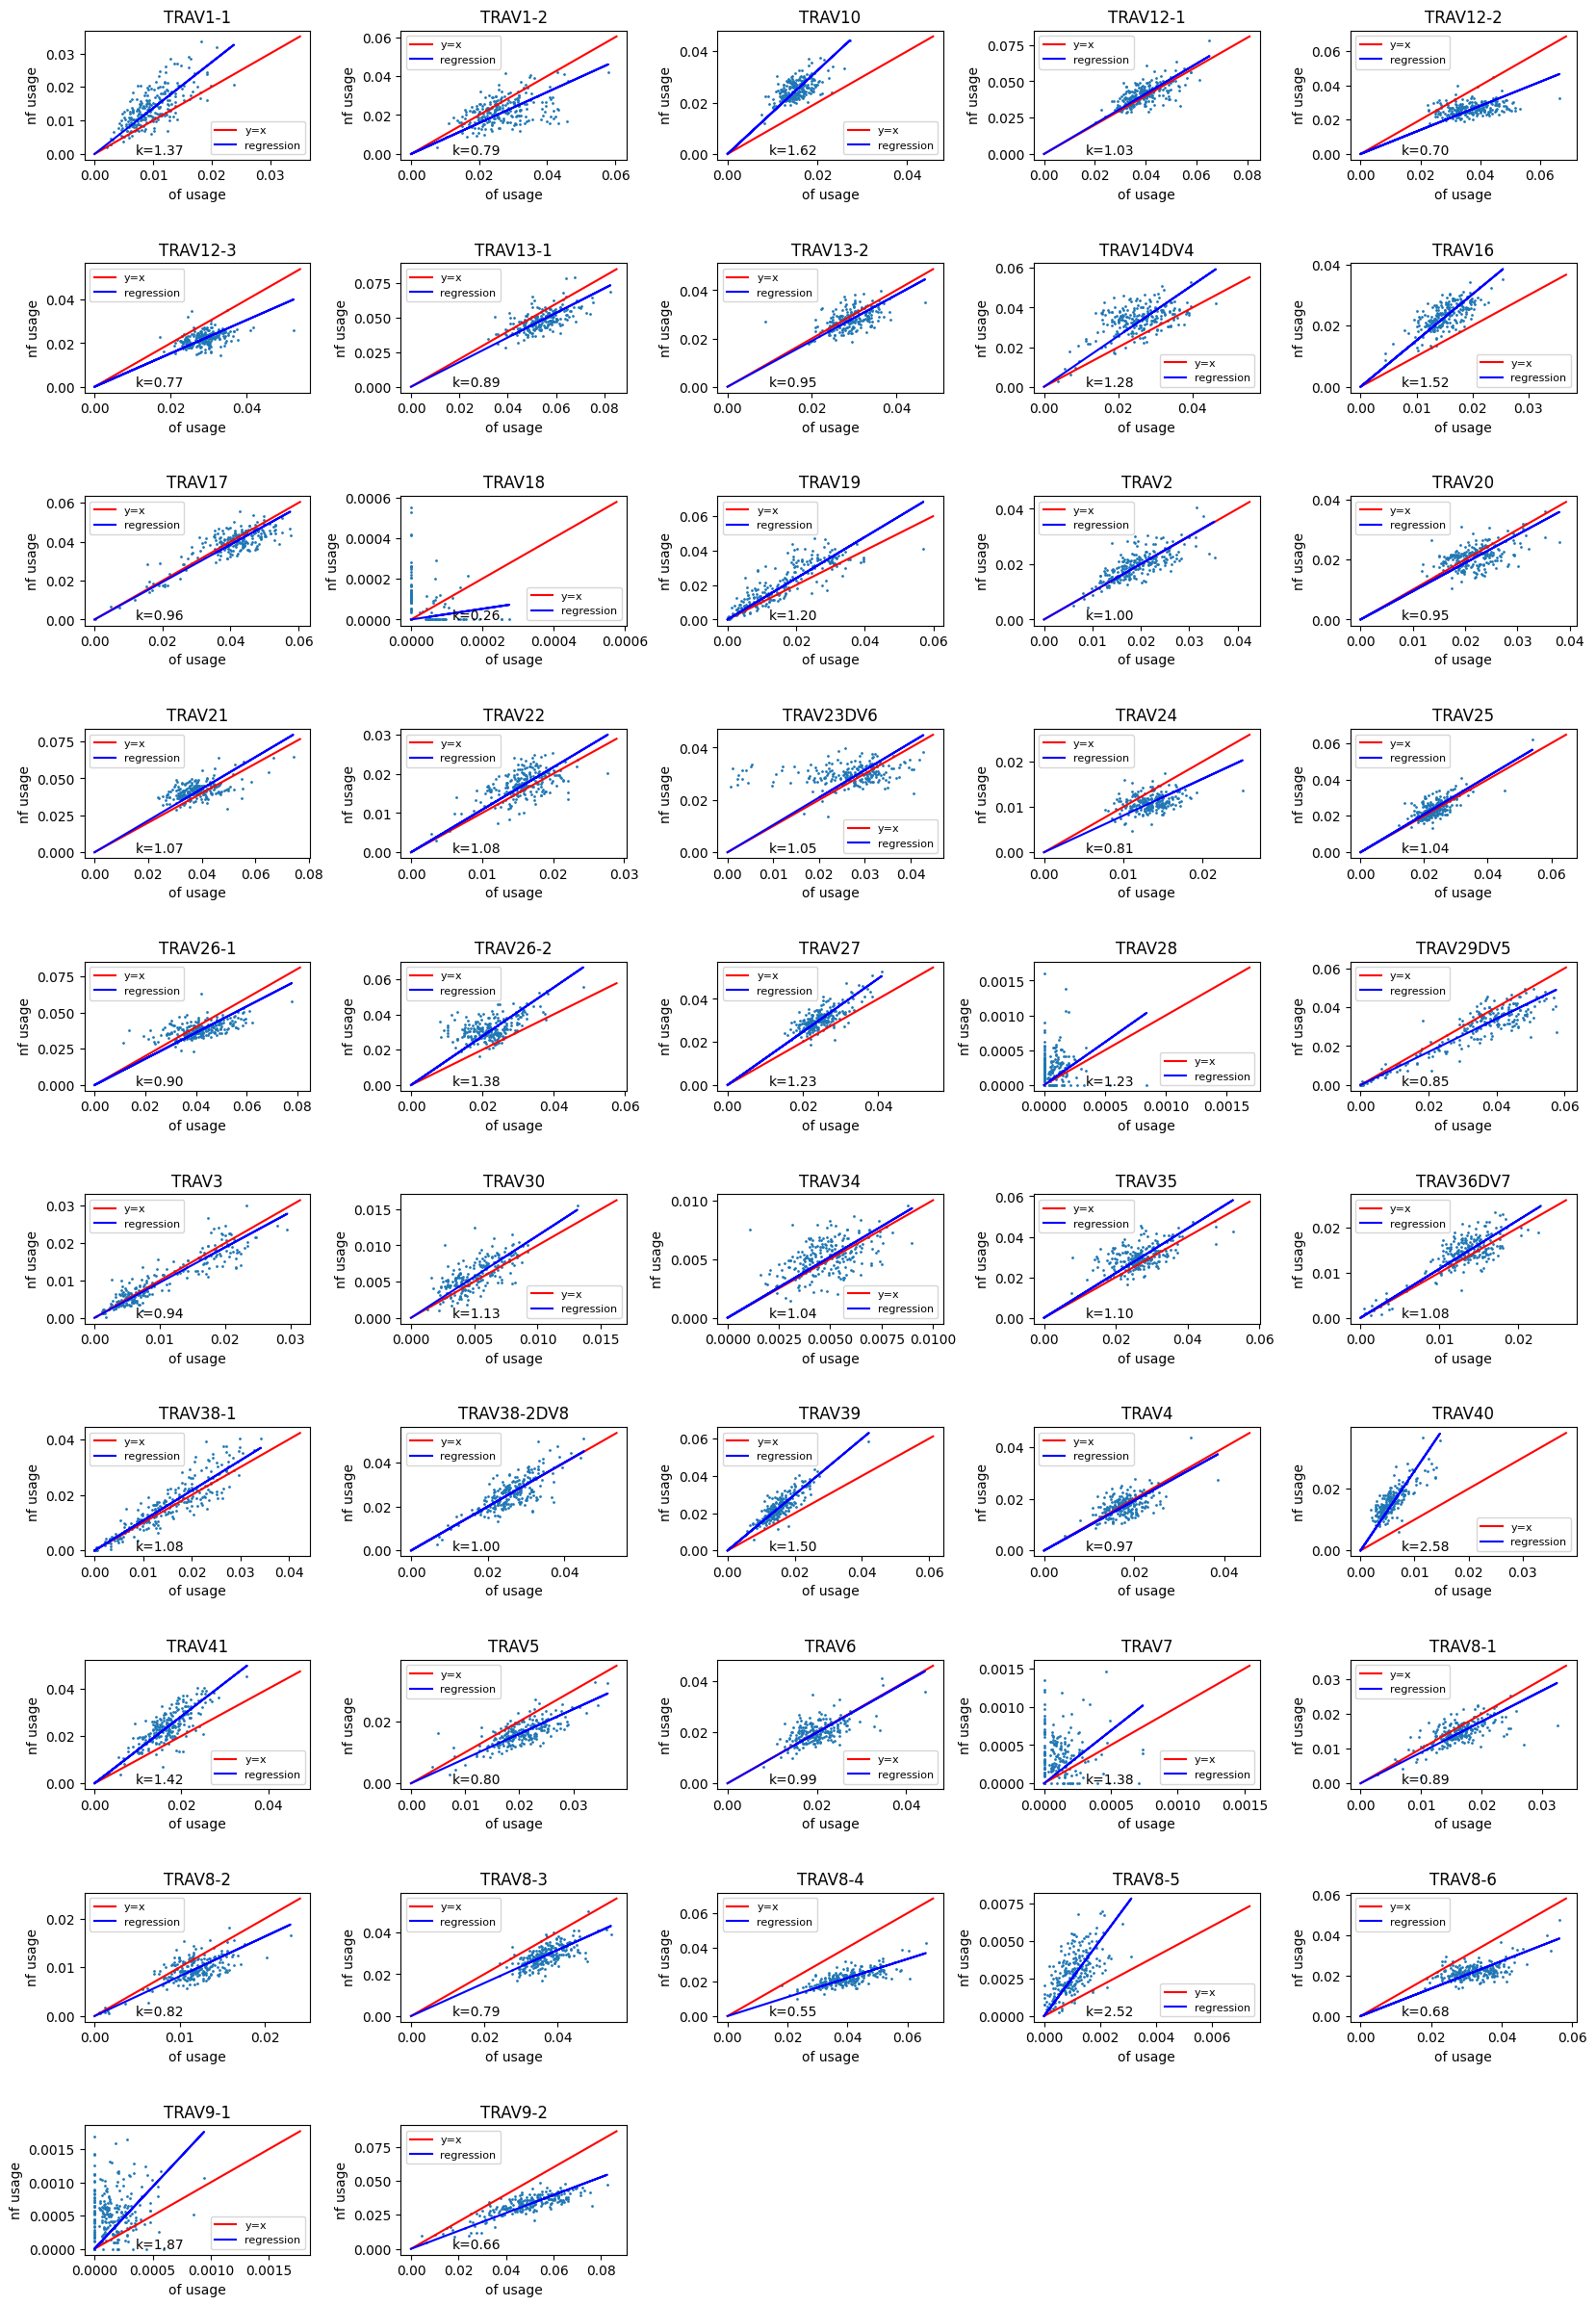

In [36]:
#TRA-V
trav_fit_koef = plot_scatter_of_vs_nf(v_gene_names_set_a, of_trav_matrix, nf_trav_matrix, '../pictures/TRAV_scatter_of_nf.png')

In [46]:
trav_fit_koef

gene      koef
0       TRAV1-1  1.369531
1       TRAV1-2  0.794678
2        TRAV10  1.623255
3      TRAV12-1  1.034559
4      TRAV12-2  0.702276
5      TRAV12-3  0.766624
6      TRAV13-1  0.889911
7      TRAV13-2  0.950743
8     TRAV14DV4  1.284369
9        TRAV16  1.515442
10       TRAV17  0.963209
11       TRAV18  0.261934
12       TRAV19  1.195319
13        TRAV2  1.003701
14       TRAV20  0.945387
15       TRAV21  1.074013
16       TRAV22  1.082417
17    TRAV23DV6  1.046001
18       TRAV24  0.809651
19       TRAV25  1.042582
20     TRAV26-1  0.903048
21     TRAV26-2  1.379946
22       TRAV27  1.234980
23       TRAV28  1.229126
24    TRAV29DV5  0.850631
25        TRAV3  0.943652
26       TRAV30  1.134930
27       TRAV34  1.037548
28       TRAV35  1.102176
29    TRAV36DV7  1.082945
30     TRAV38-1  1.079929
31  TRAV38-2DV8  1.003585
32       TRAV39  1.498650
33        TRAV4  0.968071
34       TRAV40  2.575317
35       TRAV41  1.417133
36        TRAV5  0.798452
37        TRAV6  0.992459
38        TRAV7  1.376540
39      TRAV8-1  0.891937
40      TRAV8-2  0.816434
41      TRAV8-3  0.787826
42      TRAV8-4  0.554633
43      TRAV8-5  2.520748
44      TRAV8-6  0.681481
45      TRAV9-1  1.866962
46      TRAV9-2  0.659694

[pseudo genes](https://www.imgt.org/IMGTrepertoire/index.php?section=LocusGenes&repertoire=genetable&species=human&group=TRAV): TRAV28, TRAV8-5

In [47]:
trav_pseudo = ['TRAV28', 'TRAV8-5']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trav_fit_koef)} genes)  \t{round(np.mean(trav_fit_koef.koef), 2)} \u00B1 {round(np.std(trav_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trav_fit_koef[~trav_fit_koef["gene"].isin(trav_pseudo)])} genes) \t\t {round(np.mean(trav_fit_koef[~trav_fit_koef["gene"].isin(trav_pseudo)].koef), 2)} \u00B1 {round(np.std(trav_fit_koef[~trav_fit_koef["gene"].isin(trav_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(trav_fit_koef[trav_fit_koef["gene"].isin(trav_pseudo)])} genes) \t\t {round(np.mean(trav_fit_koef[trav_fit_koef["gene"].isin(trav_pseudo)].koef), 2)} \u00B1 {round(np.std(trav_fit_koef[trav_fit_koef["gene"].isin(trav_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 47 genes)  	1.1 ± 0.42
Without preudogenes (total 45 genes) 		 1.07 ± 0.37
Only pseudogenes (total 2 genes) 		 1.87 ± 0.65


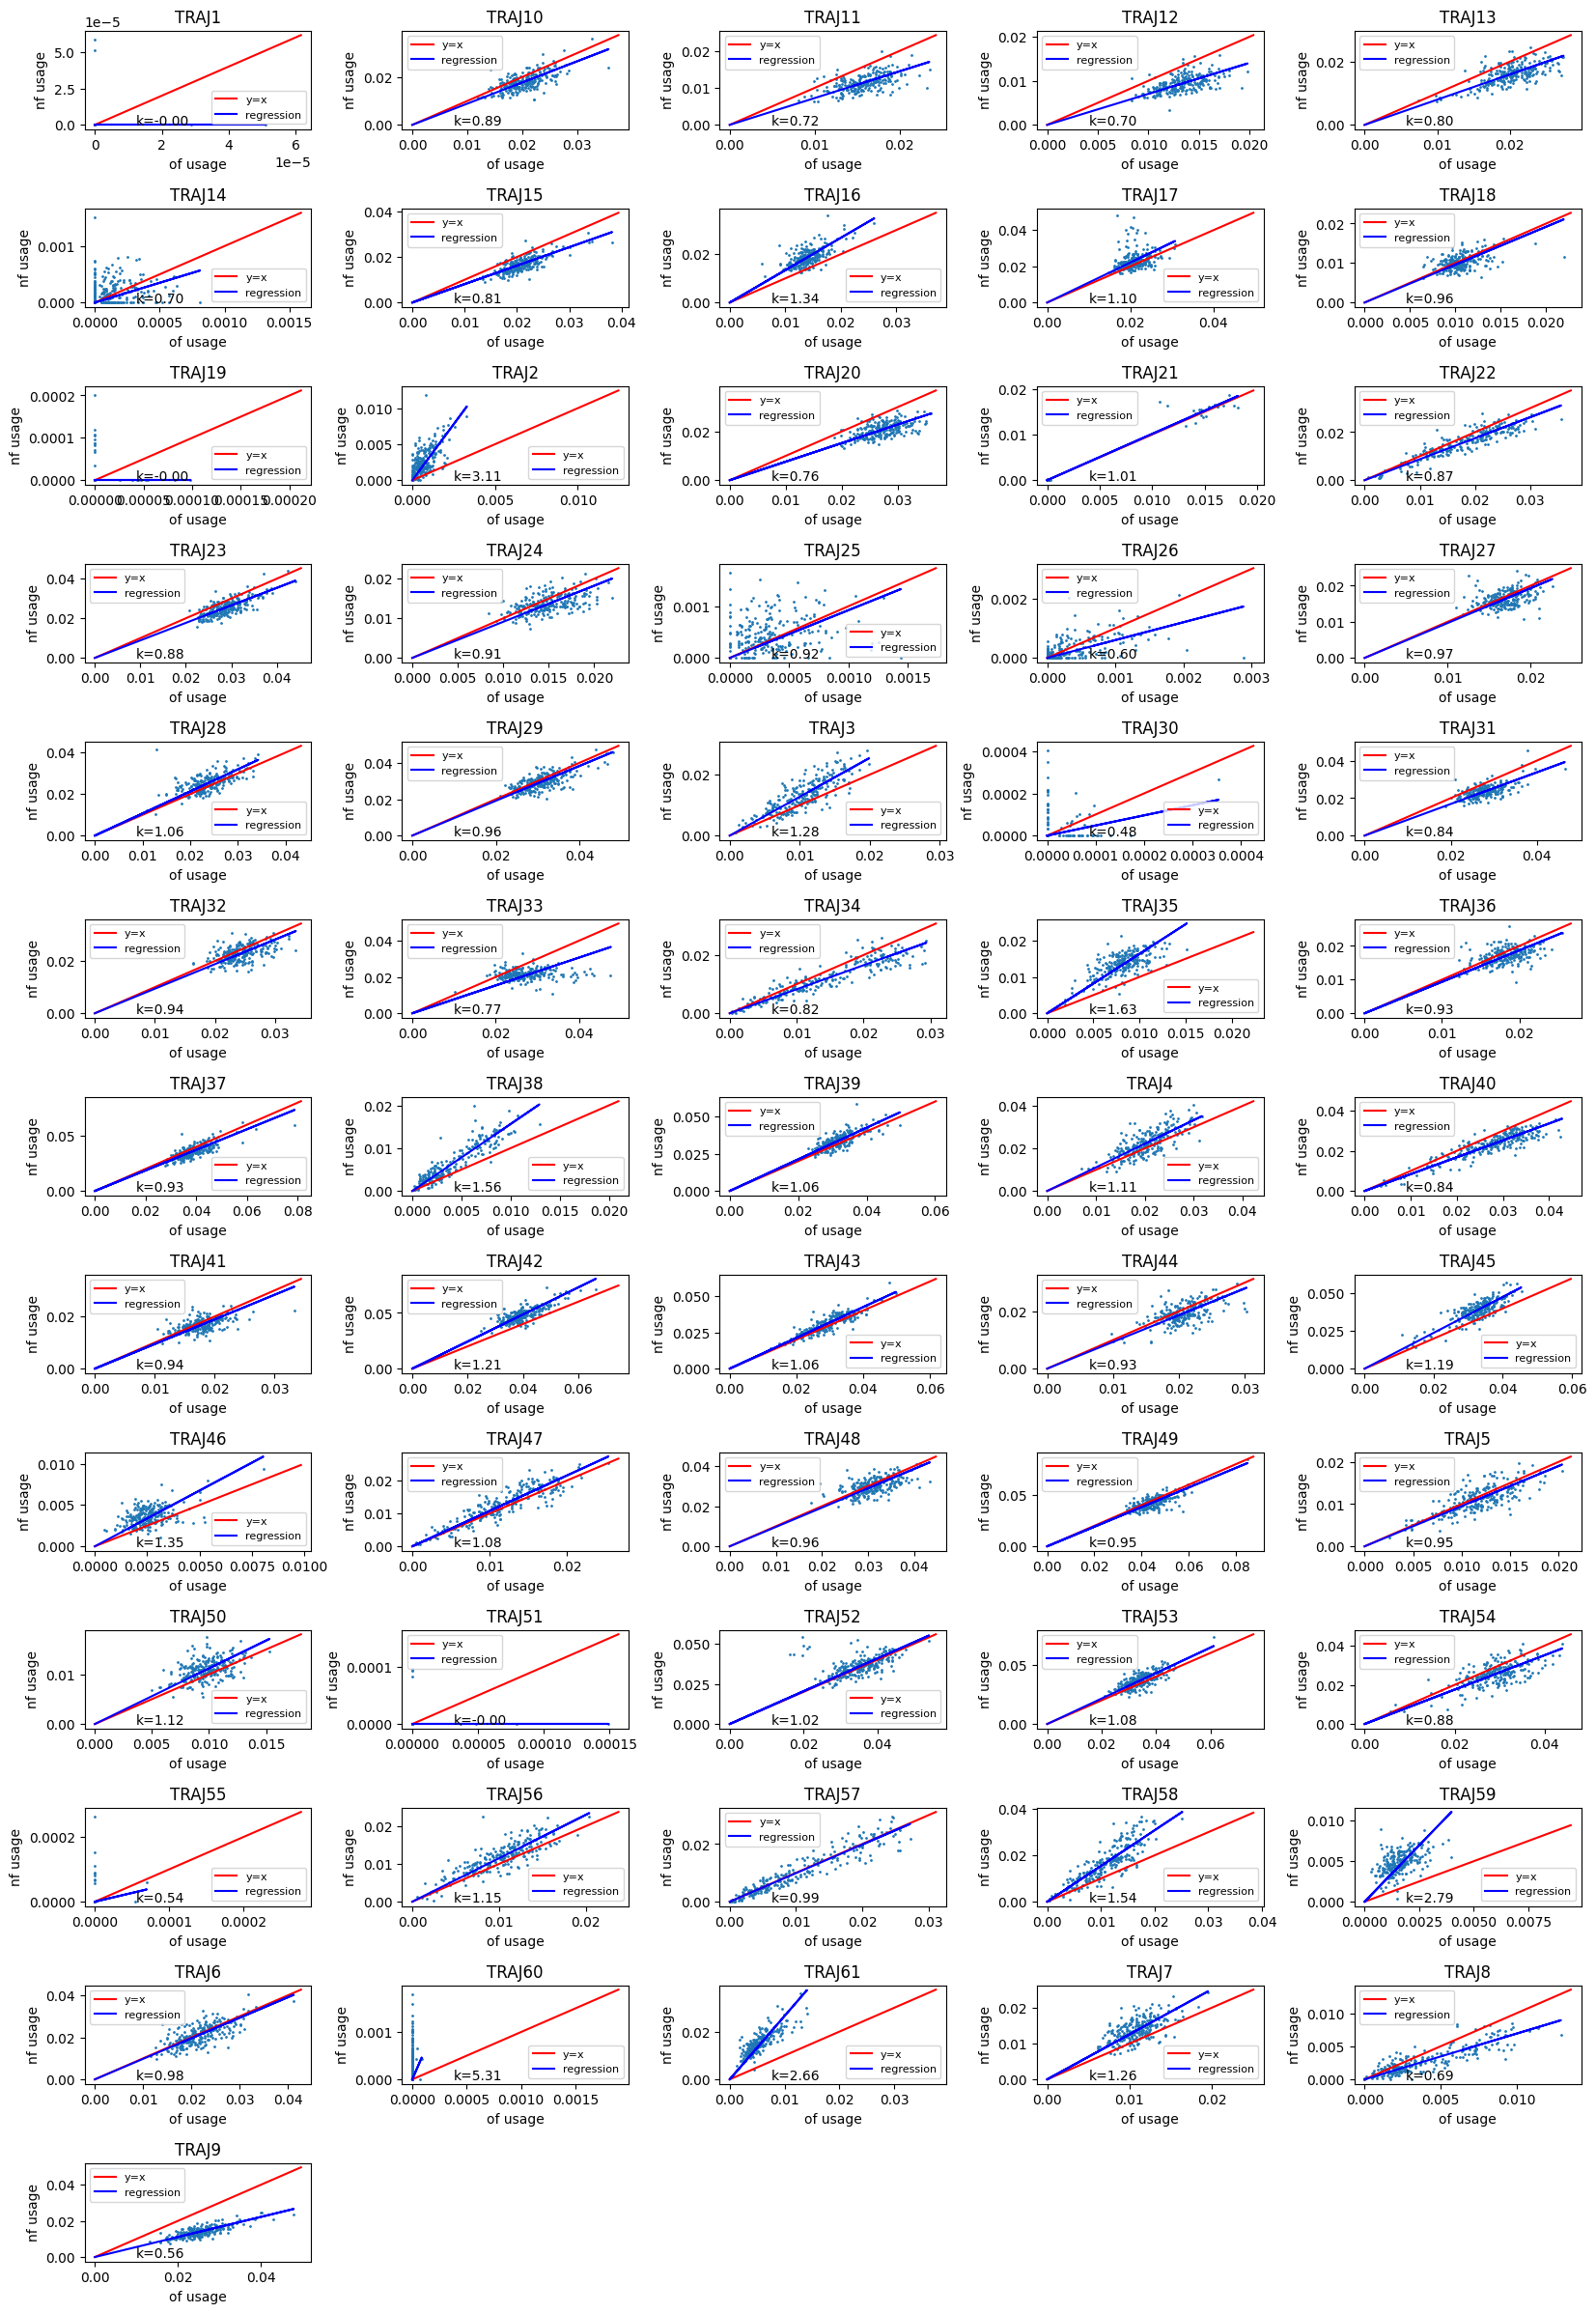

In [37]:
#TRA-J
traj_fit_koef = plot_scatter_of_vs_nf(j_gene_names_set_a, of_traj_matrix, nf_traj_matrix, '../pictures/TRAJ_scatter_of_nf.png')

In [49]:
traj_fit_koef

gene      koef
0    TRAJ1 -0.000000
1   TRAJ10  0.885730
2   TRAJ11  0.724490
3   TRAJ12  0.703753
4   TRAJ13  0.798182
..     ...       ...
56  TRAJ60  5.305465
57  TRAJ61  2.655193
58   TRAJ7  1.256909
59   TRAJ8  0.691966
60   TRAJ9  0.555490

[61 rows x 2 columns]

In [50]:
traj_pseudo = ['TRAJ51', 'TRAJ55', 'TRAJ60']

print('--Mean calculation--')
print(f'For full set of genes (total {len(traj_fit_koef)} genes)  \t{round(np.mean(traj_fit_koef.koef), 2)} \u00B1 {round(np.std(traj_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(traj_fit_koef[~traj_fit_koef["gene"].isin(traj_pseudo)])} genes) \t\t {round(np.mean(traj_fit_koef[~traj_fit_koef["gene"].isin(traj_pseudo)].koef), 2)} \u00B1 {round(np.std(traj_fit_koef[~traj_fit_koef["gene"].isin(traj_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(traj_fit_koef[traj_fit_koef["gene"].isin(traj_pseudo)])} genes) \t\t {round(np.mean(traj_fit_koef[traj_fit_koef["gene"].isin(traj_pseudo)].koef), 2)} \u00B1 {round(np.std(traj_fit_koef[traj_fit_koef["gene"].isin(traj_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 61 genes)  	1.09 ± 0.75
Without preudogenes (total 58 genes) 		 1.05 ± 0.51
Only pseudogenes (total 3 genes) 		 1.95 ± 2.38


# Beta chain: Nonfunctional vs Onlyfunctional sequences

In [38]:
#nonfunc TRB-V
nf_trbv_matrix = pd.read_csv('../data/cohort_I/nonfunctional_corrected/nf_v_clonotypes_TRB.csv')
nf_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trbv_matrix.head(3)

TRBV6-3  TRBV20-1  TRBV21-1  TRBV12-1   TRBV7-2    TRBV27   TRBV3-2  \
0      0.0  0.052126  0.057270  0.003772  0.021262  0.042181  0.020919   
1      0.0  0.070707  0.068837  0.006360  0.028432  0.035166  0.029929   
2      0.0  0.060347  0.057109  0.002944  0.030026  0.037386  0.030321   

   TRBV12-5    TRBV19  TRBV12-4  ...   TRBV7-8   TRBV5-7   TRBV5-8   TRBV6-6  \
0  0.007545  0.037723  0.000343  ...  0.004801  0.002058  0.005144  0.012003   
1  0.009353  0.033670  0.000374  ...  0.008605  0.004115  0.005612  0.015713   
2  0.011186  0.039152  0.000294  ...  0.010009  0.001766  0.004121  0.008537   

   TRBV12-3    TRBV15  TRBV10-2     TRBV2  TRBV11-2   TRBV5-5  
0  0.038066  0.002058  0.001372  0.016461  0.011317  0.007888  
1  0.037037  0.003367  0.001496  0.013094  0.018706  0.009727  
2  0.030321  0.000589  0.002355  0.016191  0.018840  0.005888  

[3 rows x 57 columns]

In [39]:
#nonfunc TRB-J
nf_trbj_matrix = pd.read_csv('../data/cohort_I/nonfunctional_corrected/nf_j_clonotypes_TRB.csv')
nf_trbj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trbj_matrix.head(3)

TRBJ2-2P   TRBJ2-4   TRBJ1-1   TRBJ1-3   TRBJ2-2   TRBJ2-7   TRBJ1-6  \
0       0.0  0.005830  0.200960  0.051783  0.034294  0.195816  0.053841   
1       0.0  0.007108  0.150393  0.041526  0.032548  0.254770  0.054620   
2       0.0  0.017663  0.130998  0.034737  0.057404  0.171622  0.049161   

    TRBJ1-2   TRBJ2-1   TRBJ2-5   TRBJ2-3   TRBJ2-6   TRBJ1-5   TRBJ1-4  
0  0.137174  0.053498  0.027778  0.034294  0.023663  0.116598  0.064472  
1  0.132061  0.073326  0.025814  0.025440  0.020202  0.121212  0.060980  
2  0.119223  0.099794  0.068001  0.079776  0.019723  0.103032  0.048867

In [40]:
#onlyfunc TRB-V
of_trbv_matrix = pd.read_csv('../data/cohort_I/onlyfunctional_corrected/of_v_clonotypes_TRB.csv')
of_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trbv_matrix.head(3)

TRBV6-3  TRBV20-1  TRBV21-1  TRBV12-1   TRBV7-2    TRBV27   TRBV3-2  \
0      0.0  0.068001  0.006920  0.001107  0.041336  0.034231  0.002214   
1      0.0  0.097861  0.006209  0.000394  0.047994  0.029565  0.002661   
2      0.0  0.079443  0.005809  0.000280  0.049766  0.031987  0.002940   

   TRBV12-5    TRBV19  TRBV12-4  ...   TRBV7-8   TRBV5-7   TRBV5-8   TRBV6-6  \
0  0.001753  0.053331  0.000923  ...  0.012548  0.000554  0.007289  0.018546   
1  0.004238  0.056963  0.001183  ...  0.016064  0.000493  0.004928  0.021681   
2  0.003850  0.048366  0.000630  ...  0.018268  0.000350  0.008189  0.019808   

   TRBV12-3    TRBV15  TRBV10-2     TRBV2   TRBV5-5  TRBV11-2  
0  0.044658  0.002860  0.002214  0.036261  0.009227  0.019192  
1  0.052331  0.003548  0.003942  0.033803  0.010348  0.020794  
2  0.046266  0.003710  0.002660  0.038217  0.011269  0.020158  

[3 rows x 58 columns]

In [41]:
#nonfunc TRB-J
of_trbj_matrix = pd.read_csv('../data/cohort_I/onlyfunctional_corrected/of_j_clonotypes_TRB.csv')
of_trbj_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trbj_matrix.head(3)

TRBJ2-2P   TRBJ2-4   TRBJ1-1   TRBJ1-3   TRBJ2-2   TRBJ2-7   TRBJ1-6  \
0       0.0  0.002860  0.210925  0.046964  0.034416  0.182506  0.060436   
1       0.0  0.003449  0.171184  0.055780  0.024835  0.219277  0.066818   
2       0.0  0.009869  0.142227  0.039056  0.055085  0.148247  0.054385   

    TRBJ1-2   TRBJ2-1   TRBJ2-5   TRBJ2-3   TRBJ2-6   TRBJ1-5   TRBJ1-4  
0  0.171434  0.055176  0.025374  0.038383  0.021960  0.091438  0.058129  
1  0.160836  0.073322  0.019415  0.026313  0.023258  0.095201  0.060313  
2  0.139077  0.103381  0.070554  0.087912  0.020368  0.082033  0.047806

In [42]:
v_gene_names_set_b = set(nf_trbv_matrix.columns).intersection(set(of_trbv_matrix.columns)) 
j_gene_names_set_b = set(nf_trbj_matrix.columns).intersection(set(of_trbj_matrix.columns))

v_gene_names_set_b = list(v_gene_names_set_b)
v_gene_names_set_b.sort()
j_gene_names_set_b = list(j_gene_names_set_b)
j_gene_names_set_b.sort()

## Gene usage on population scale histograms

### Nonfunctional

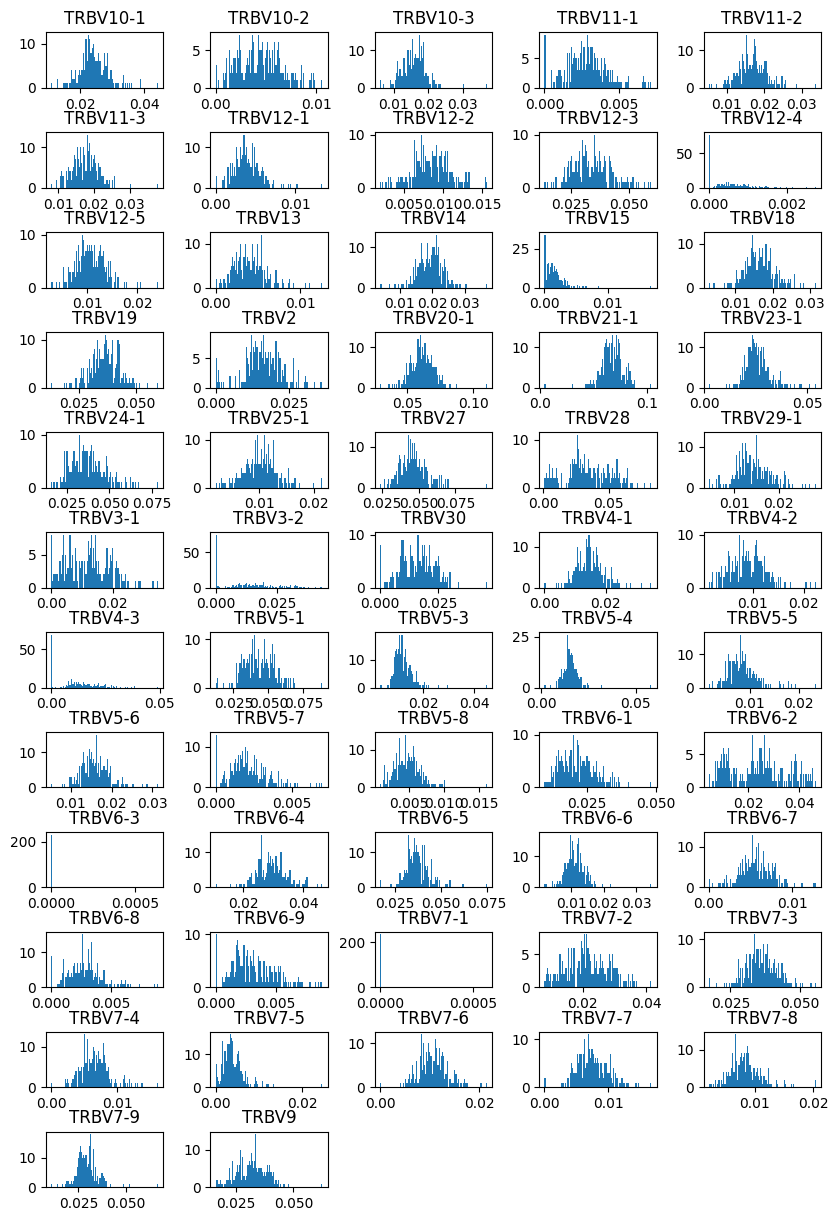

In [43]:
#nonfunc TRB-V
plot_hist_usage(v_gene_names_set_b, nf_trbv_matrix)

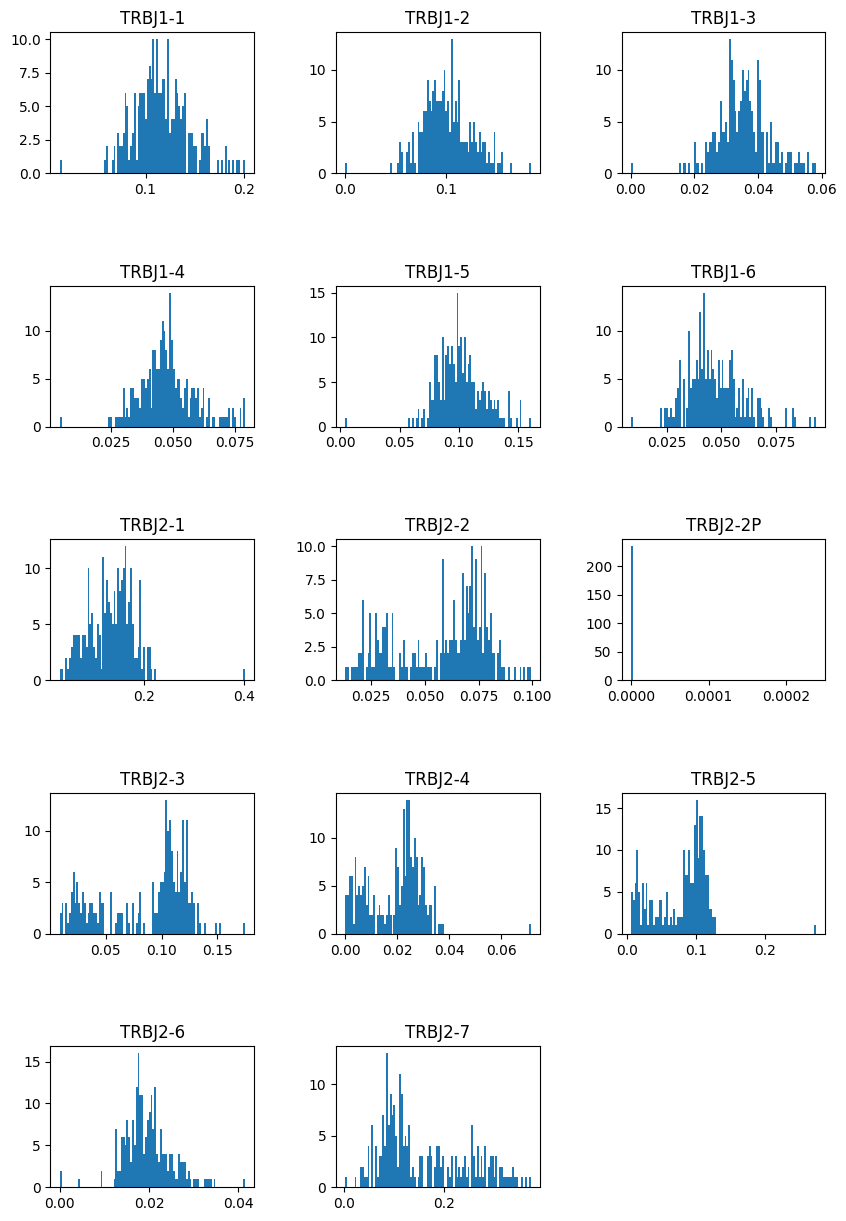

In [44]:
#nonfunc TRB-J
plot_hist_usage(j_gene_names_set_b, nf_trbj_matrix, 3)#plt.figure(figsize=(10,10))

### Onlyfunctional

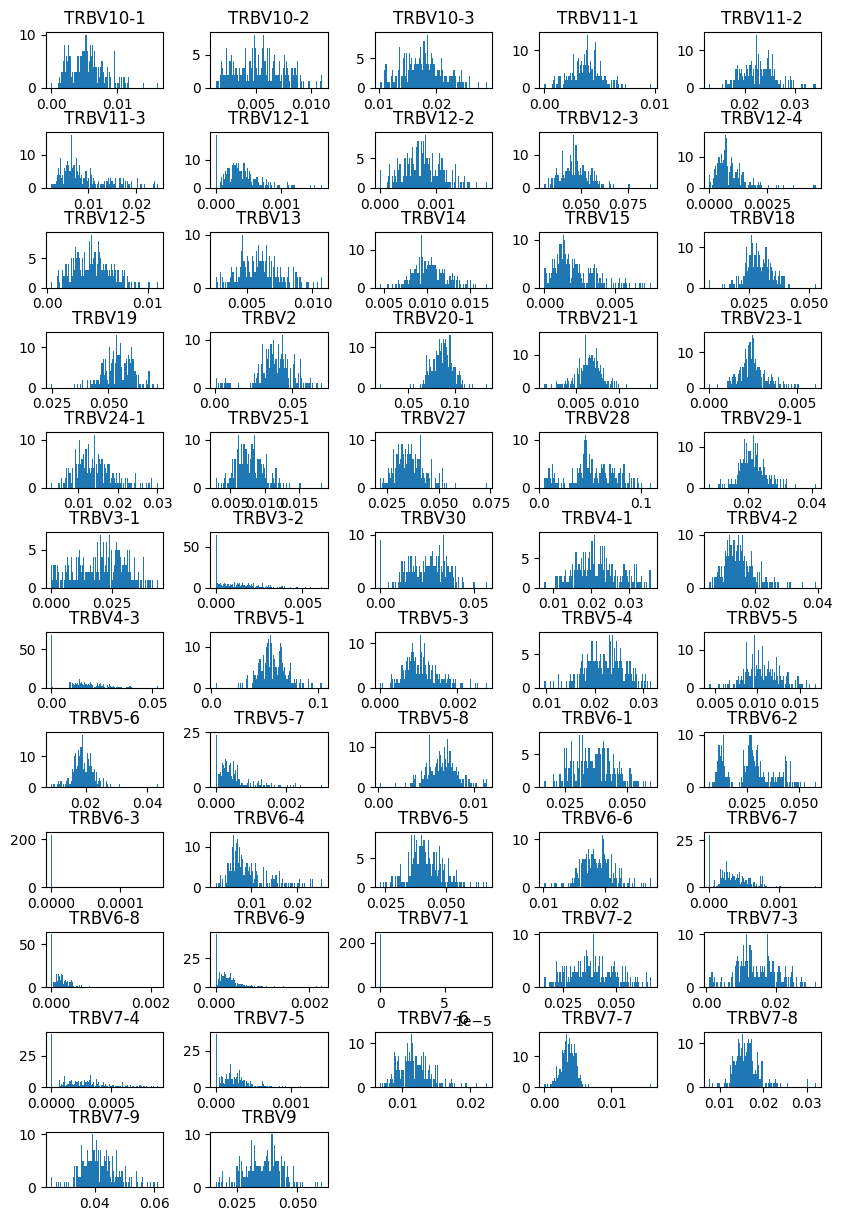

In [45]:
#onlyfunc TRB-V
plot_hist_usage(v_gene_names_set_b, of_trbv_matrix)

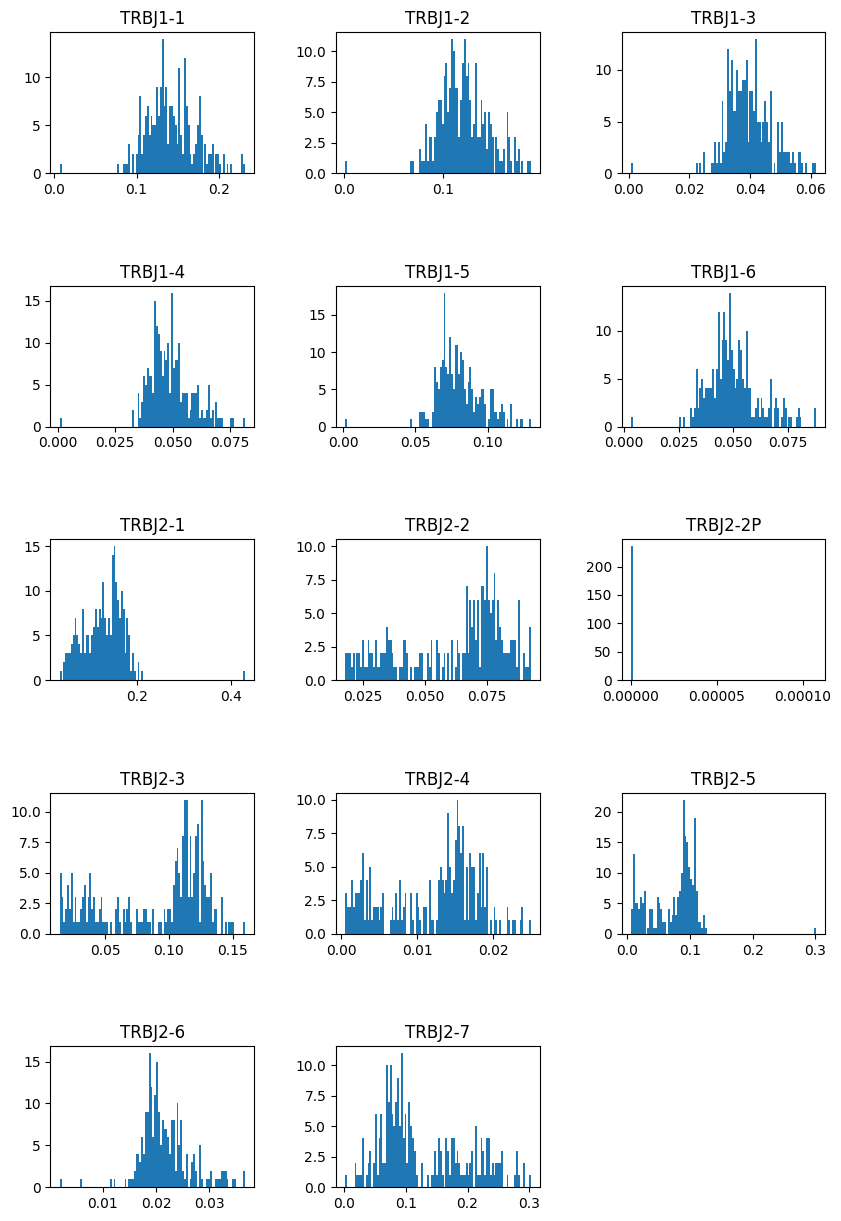

In [46]:
#onlyfunc TRB-J
plot_hist_usage(j_gene_names_set_b, of_trbj_matrix, 3)

## Joint histograms (Nonfunctional vs Onlyfunctional)

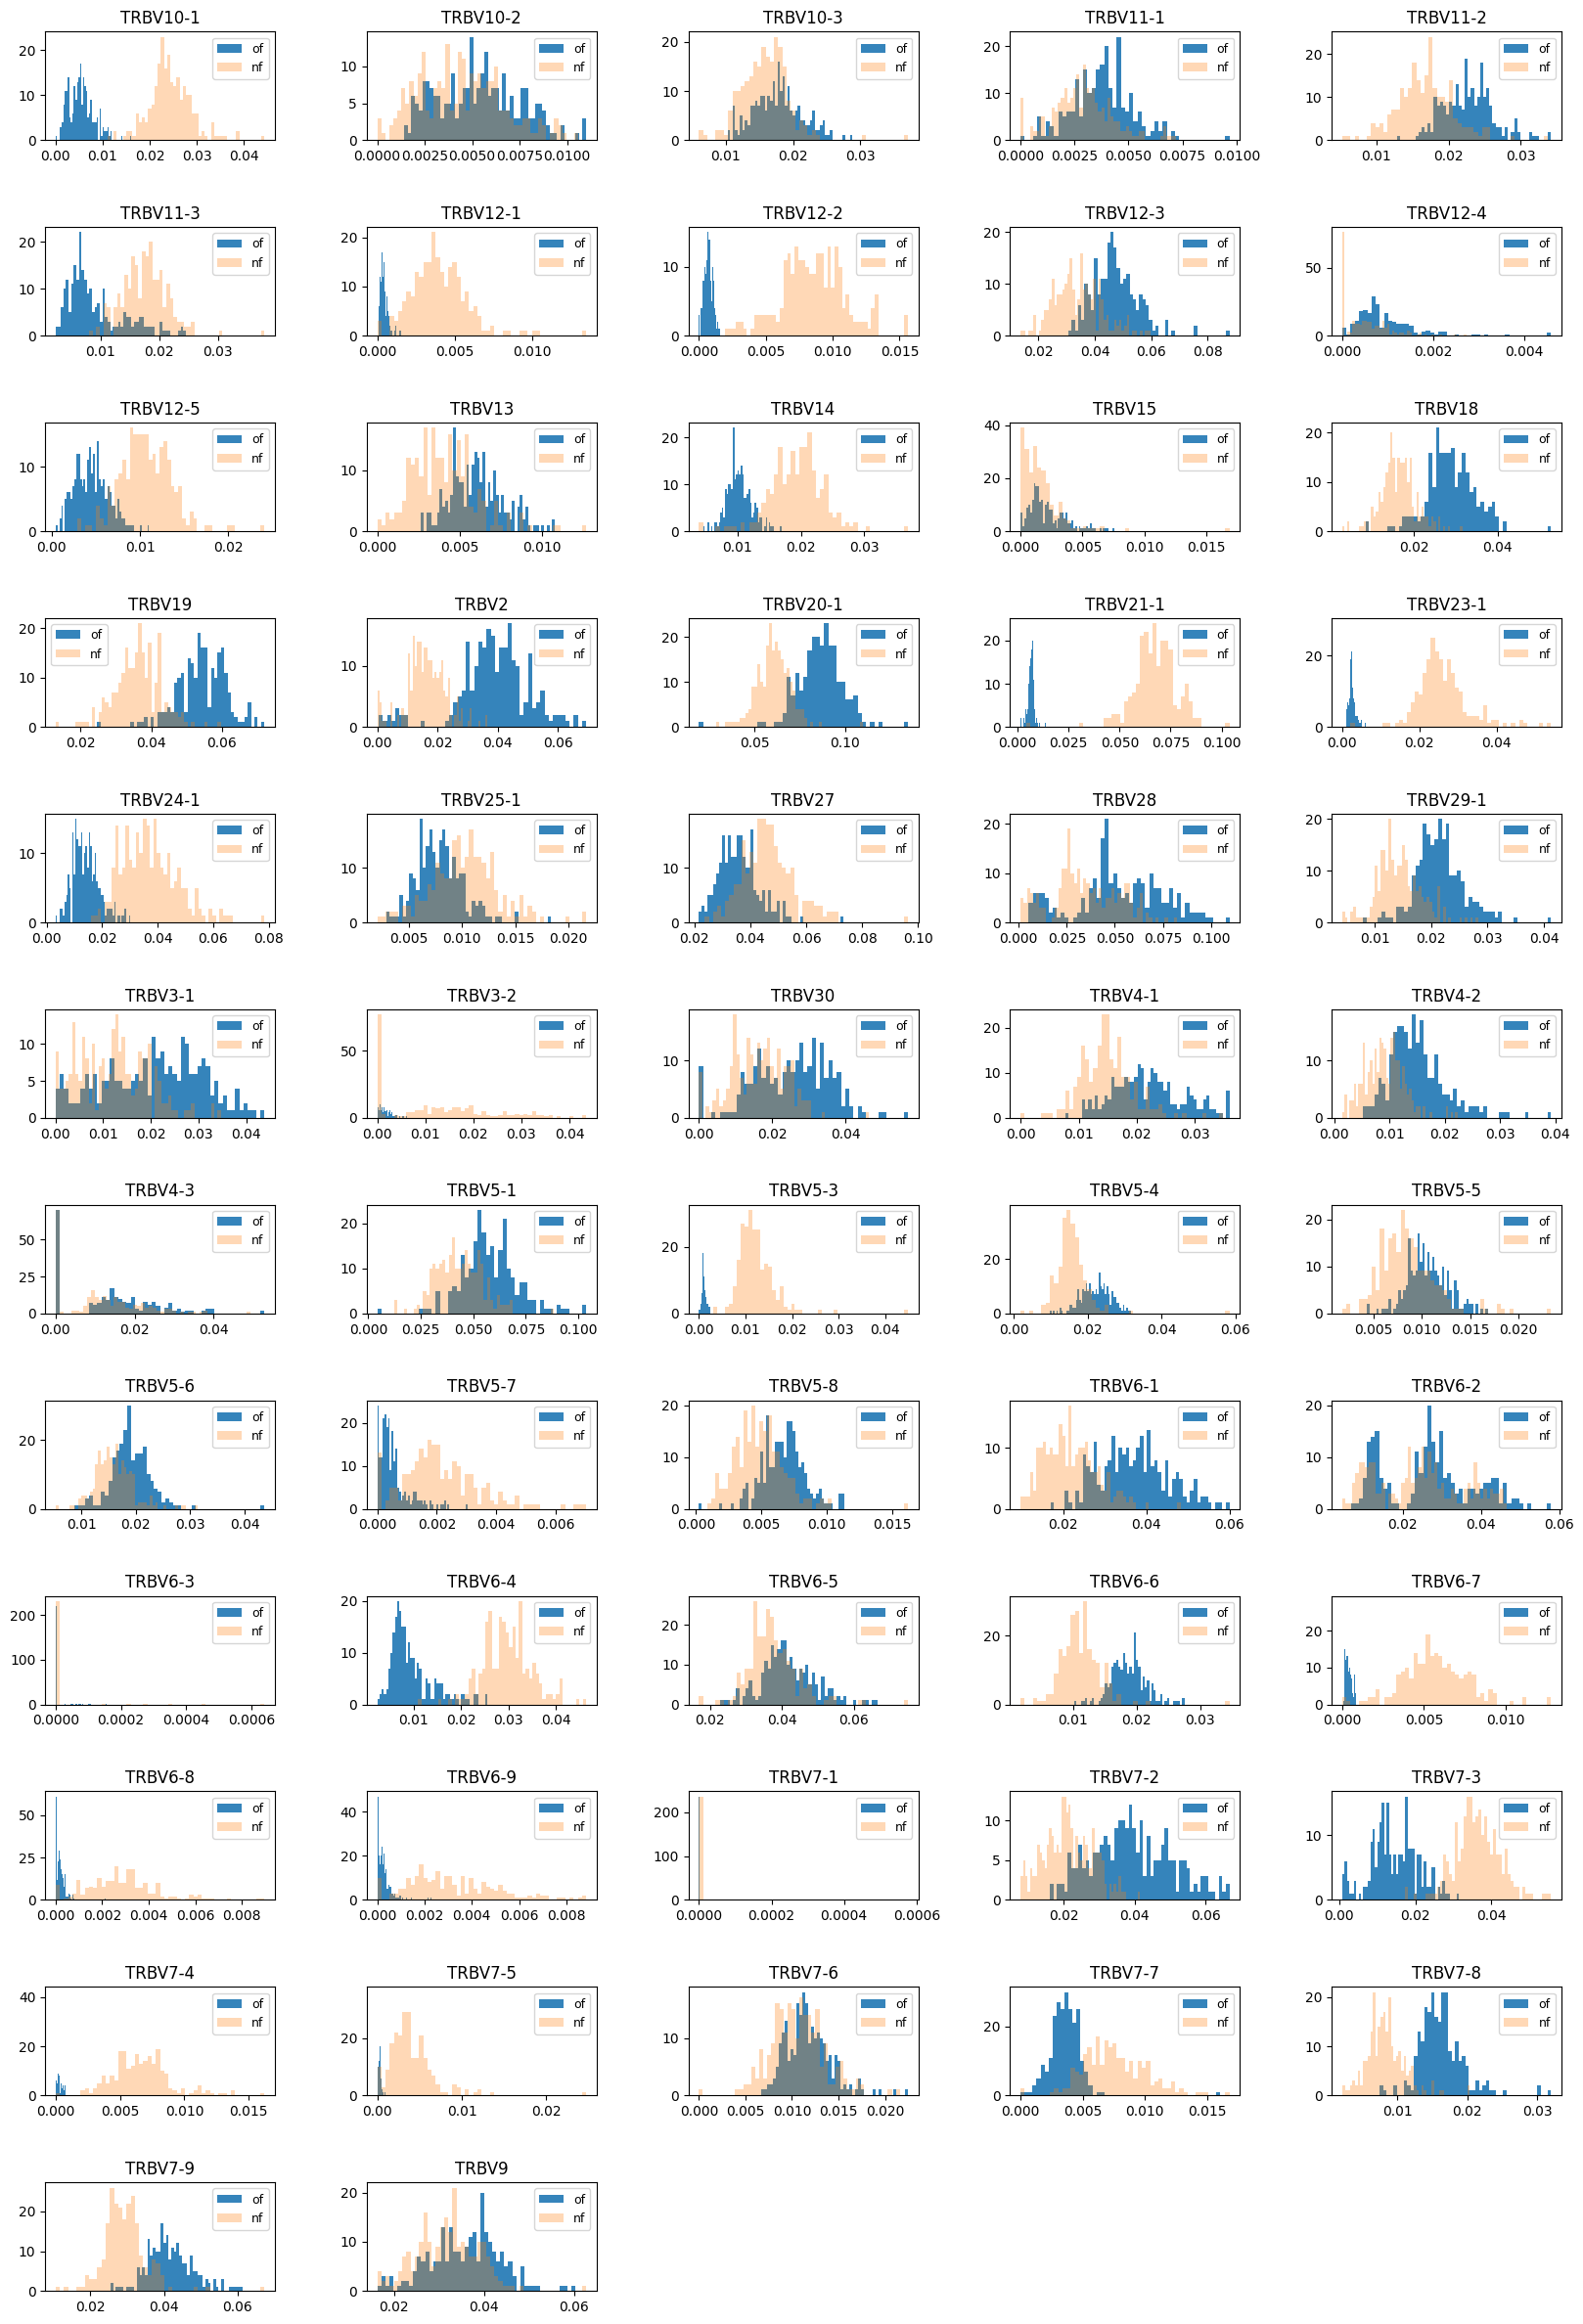

In [47]:
#onlyfunc и nonfunc TRA-V
plot_hist_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, file_name='../pictures/TRBV_hist_of_nf.png')

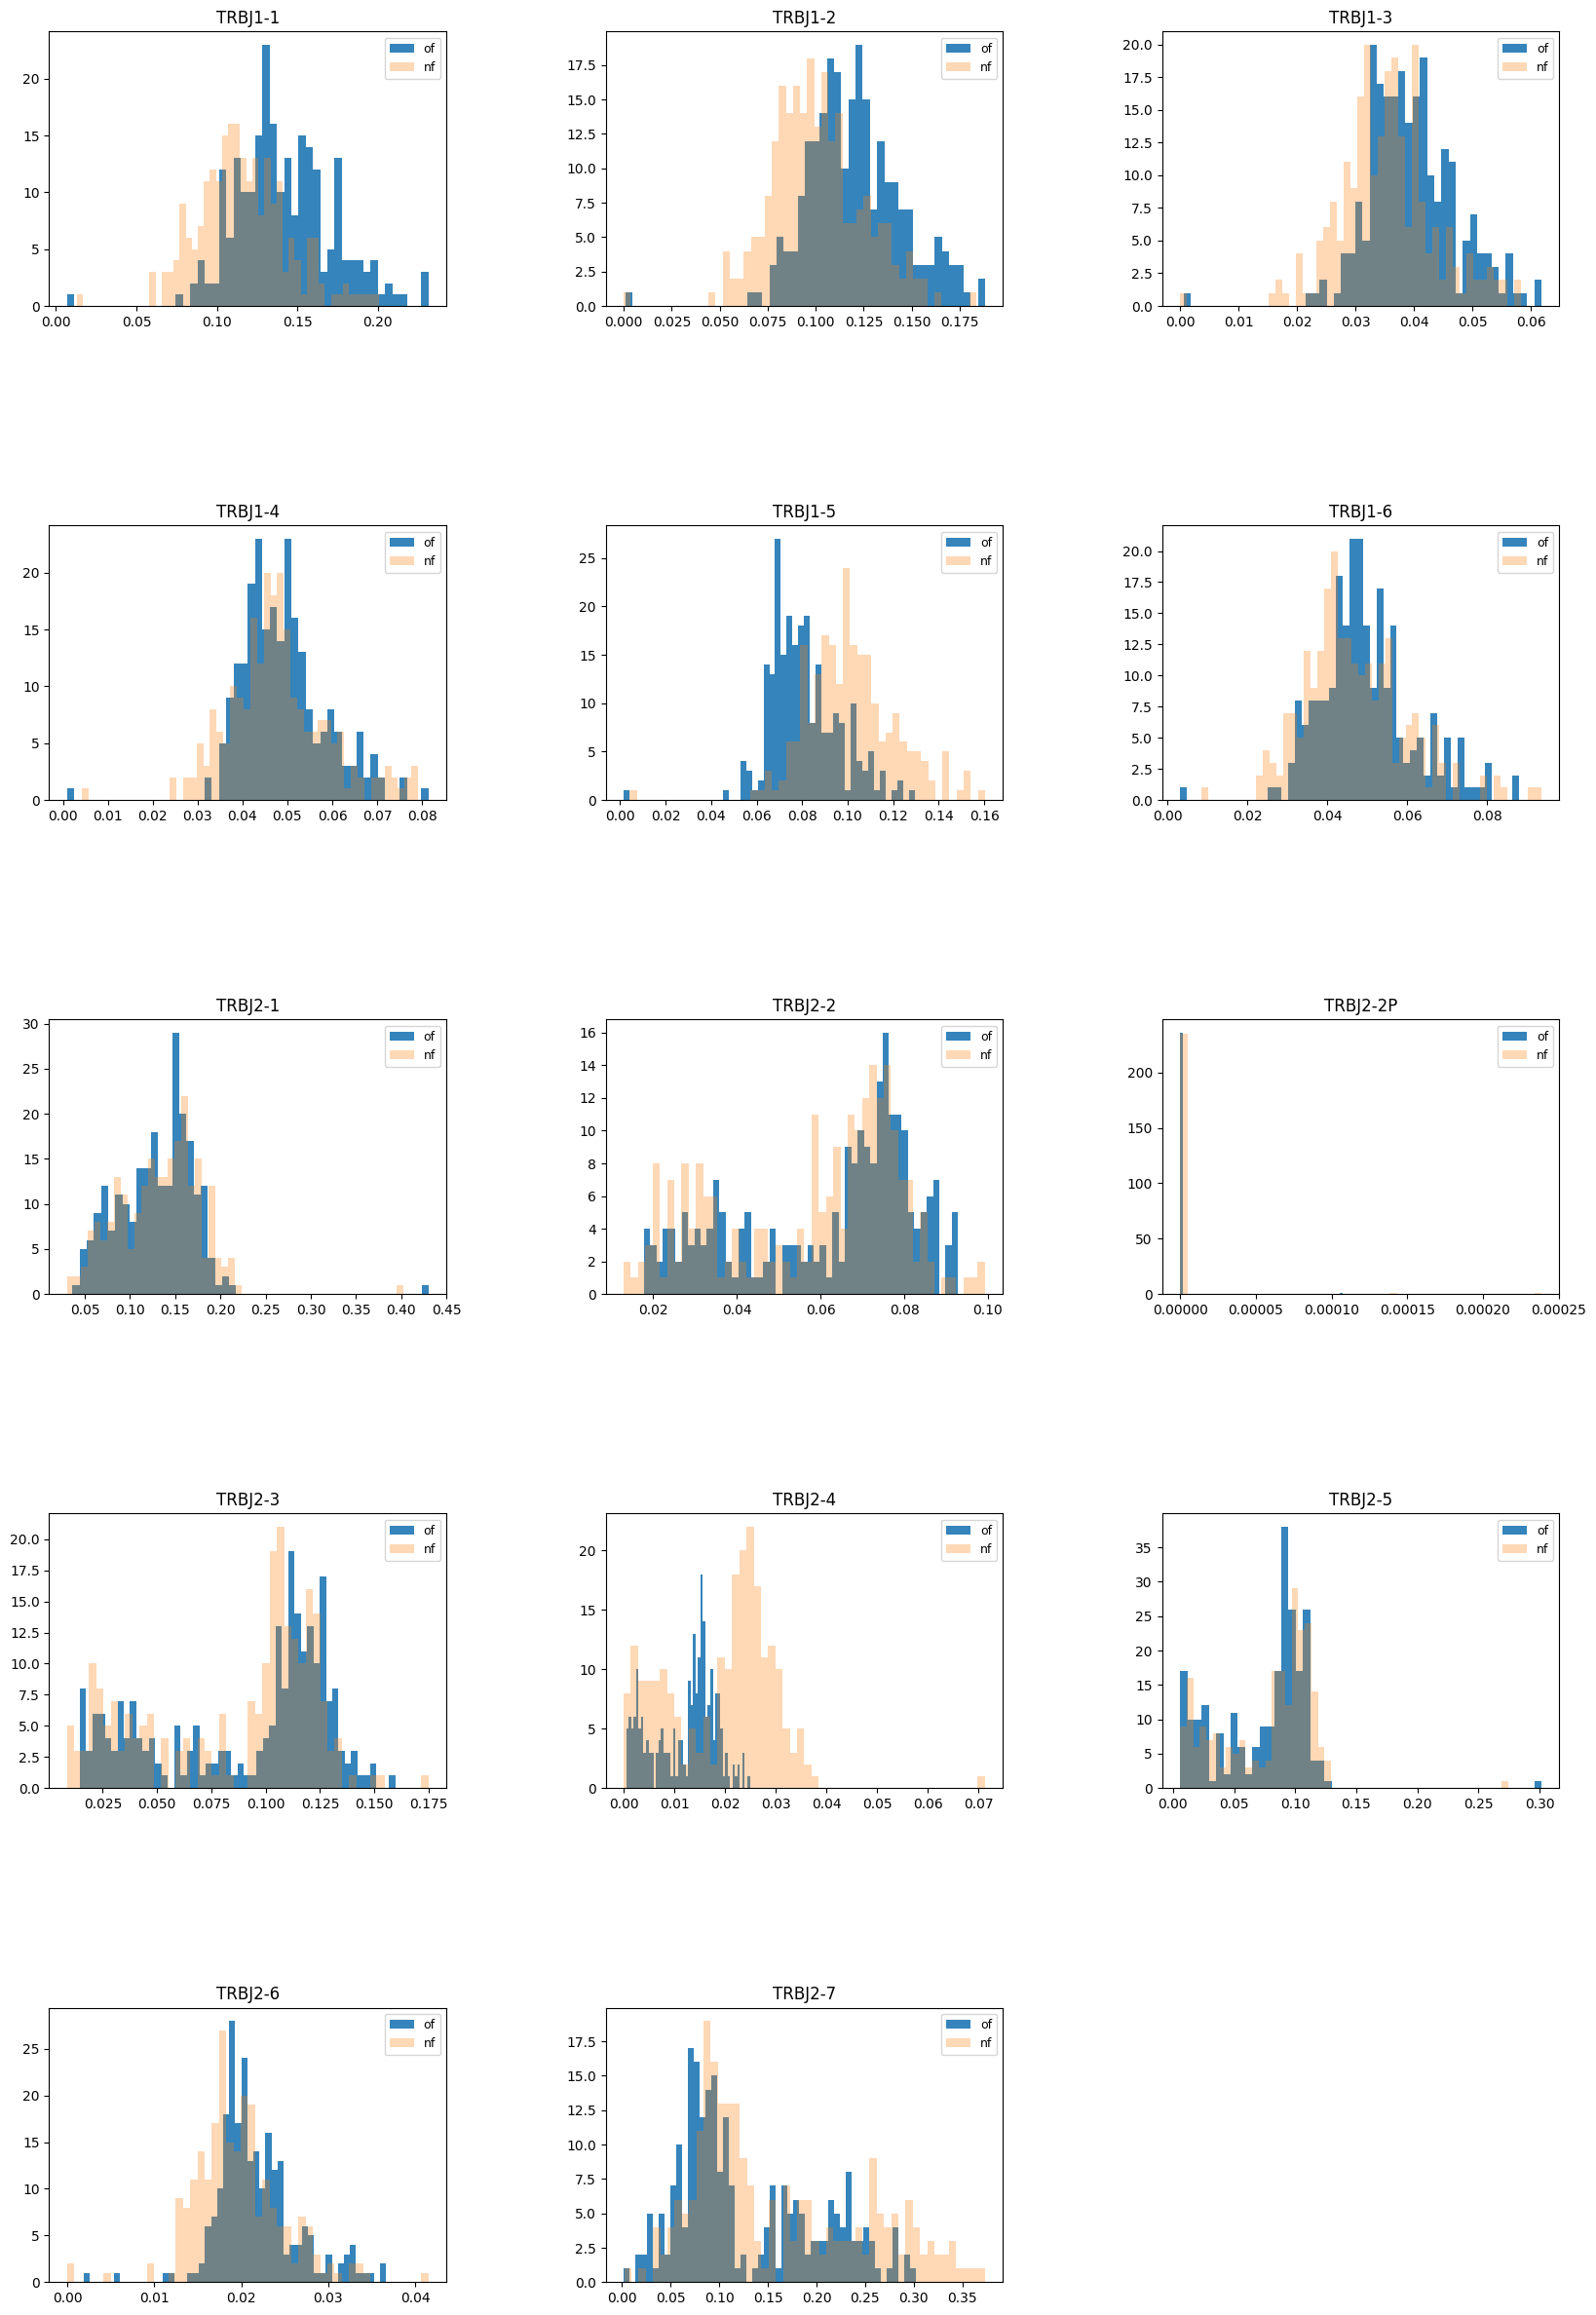

In [48]:
#onlyfunc и nonfunc TRA-J
plot_hist_of_vs_nf(j_gene_names_set_b, of_trbj_matrix, nf_trbj_matrix, 3, file_name='../pictures/TRBJ_hist_of_nf.png')

### Kolmogorov-Smirnov test for nf vs of

In [62]:
#TRB-V
trbv_ks_test_p_values = calculate_p_value_ks_test(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, True)
trbv_sign = {key: val for key, val in trbv_ks_test_p_values.items() if val <= 0.05}
trbv_sign

{'TRBV10-1': 1.125369925193438e-132,
 'TRBV10-2': 0.014555024849951553,
 'TRBV10-3': 0.0001141233412143085,
 'TRBV11-1': 2.6559573632848305e-10,
 'TRBV11-2': 2.433080990666762e-39,
 'TRBV11-3': 8.69034523391905e-56,
 'TRBV12-1': 1.4890242600855826e-116,
 'TRBV12-2': 6.380652222784255e-140,
 'TRBV12-3': 1.4228699408188875e-40,
 'TRBV12-4': 7.427159997111502e-12,
 'TRBV12-5': 1.6862183944343718e-79,
 'TRBV13': 2.320022218585111e-24,
 'TRBV14': 1.6941269052048094e-98,
 'TRBV15': 0.0065258444749843525,
 'TRBV18': 1.2709199469539638e-83,
 'TRBV19': 7.655718387091243e-87,
 'TRBV2': 3.5053655618549656e-90,
 'TRBV20-1': 1.6594100174234914e-77,
 'TRBV21-1': 3.024429153599737e-137,
 'TRBV23-1': 3.024429153599737e-137,
 'TRBV24-1': 1.2377188766486007e-103,
 'TRBV25-1': 3.9127479770159454e-19,
 'TRBV27': 9.848433068313221e-29,
 'TRBV28': 9.103508861771077e-17,
 'TRBV29-1': 1.601362222588463e-53,
 'TRBV3-1': 3.9127479770159454e-19,
 'TRBV3-2': 4.4650081638771776e-45,
 'TRBV30': 2.50770591738656e-18

In [63]:
#TRB-J
trbj_ks_test_p_values = calculate_p_value_ks_test(j_gene_names_set_b, of_trbj_matrix, nf_trbj_matrix, True)
trbj_sign = {key: val for key, val in trbj_ks_test_p_values.items() if val <= 0.05}
trbj_sign

{'TRBJ1-1': 6.900237836345329e-16,
 'TRBJ1-2': 4.0789894720978495e-13,
 'TRBJ1-3': 3.681798550734812e-06,
 'TRBJ1-5': 6.583856027747155e-26,
 'TRBJ1-6': 0.003574918384198627,
 'TRBJ2-3': 0.0321660585831984,
 'TRBJ2-4': 5.020785793909953e-33,
 'TRBJ2-6': 2.376435476834009e-07,
 'TRBJ2-7': 0.01115187075080813}

## Scatterplots (Nonfunctional vs Onlyfunctional)

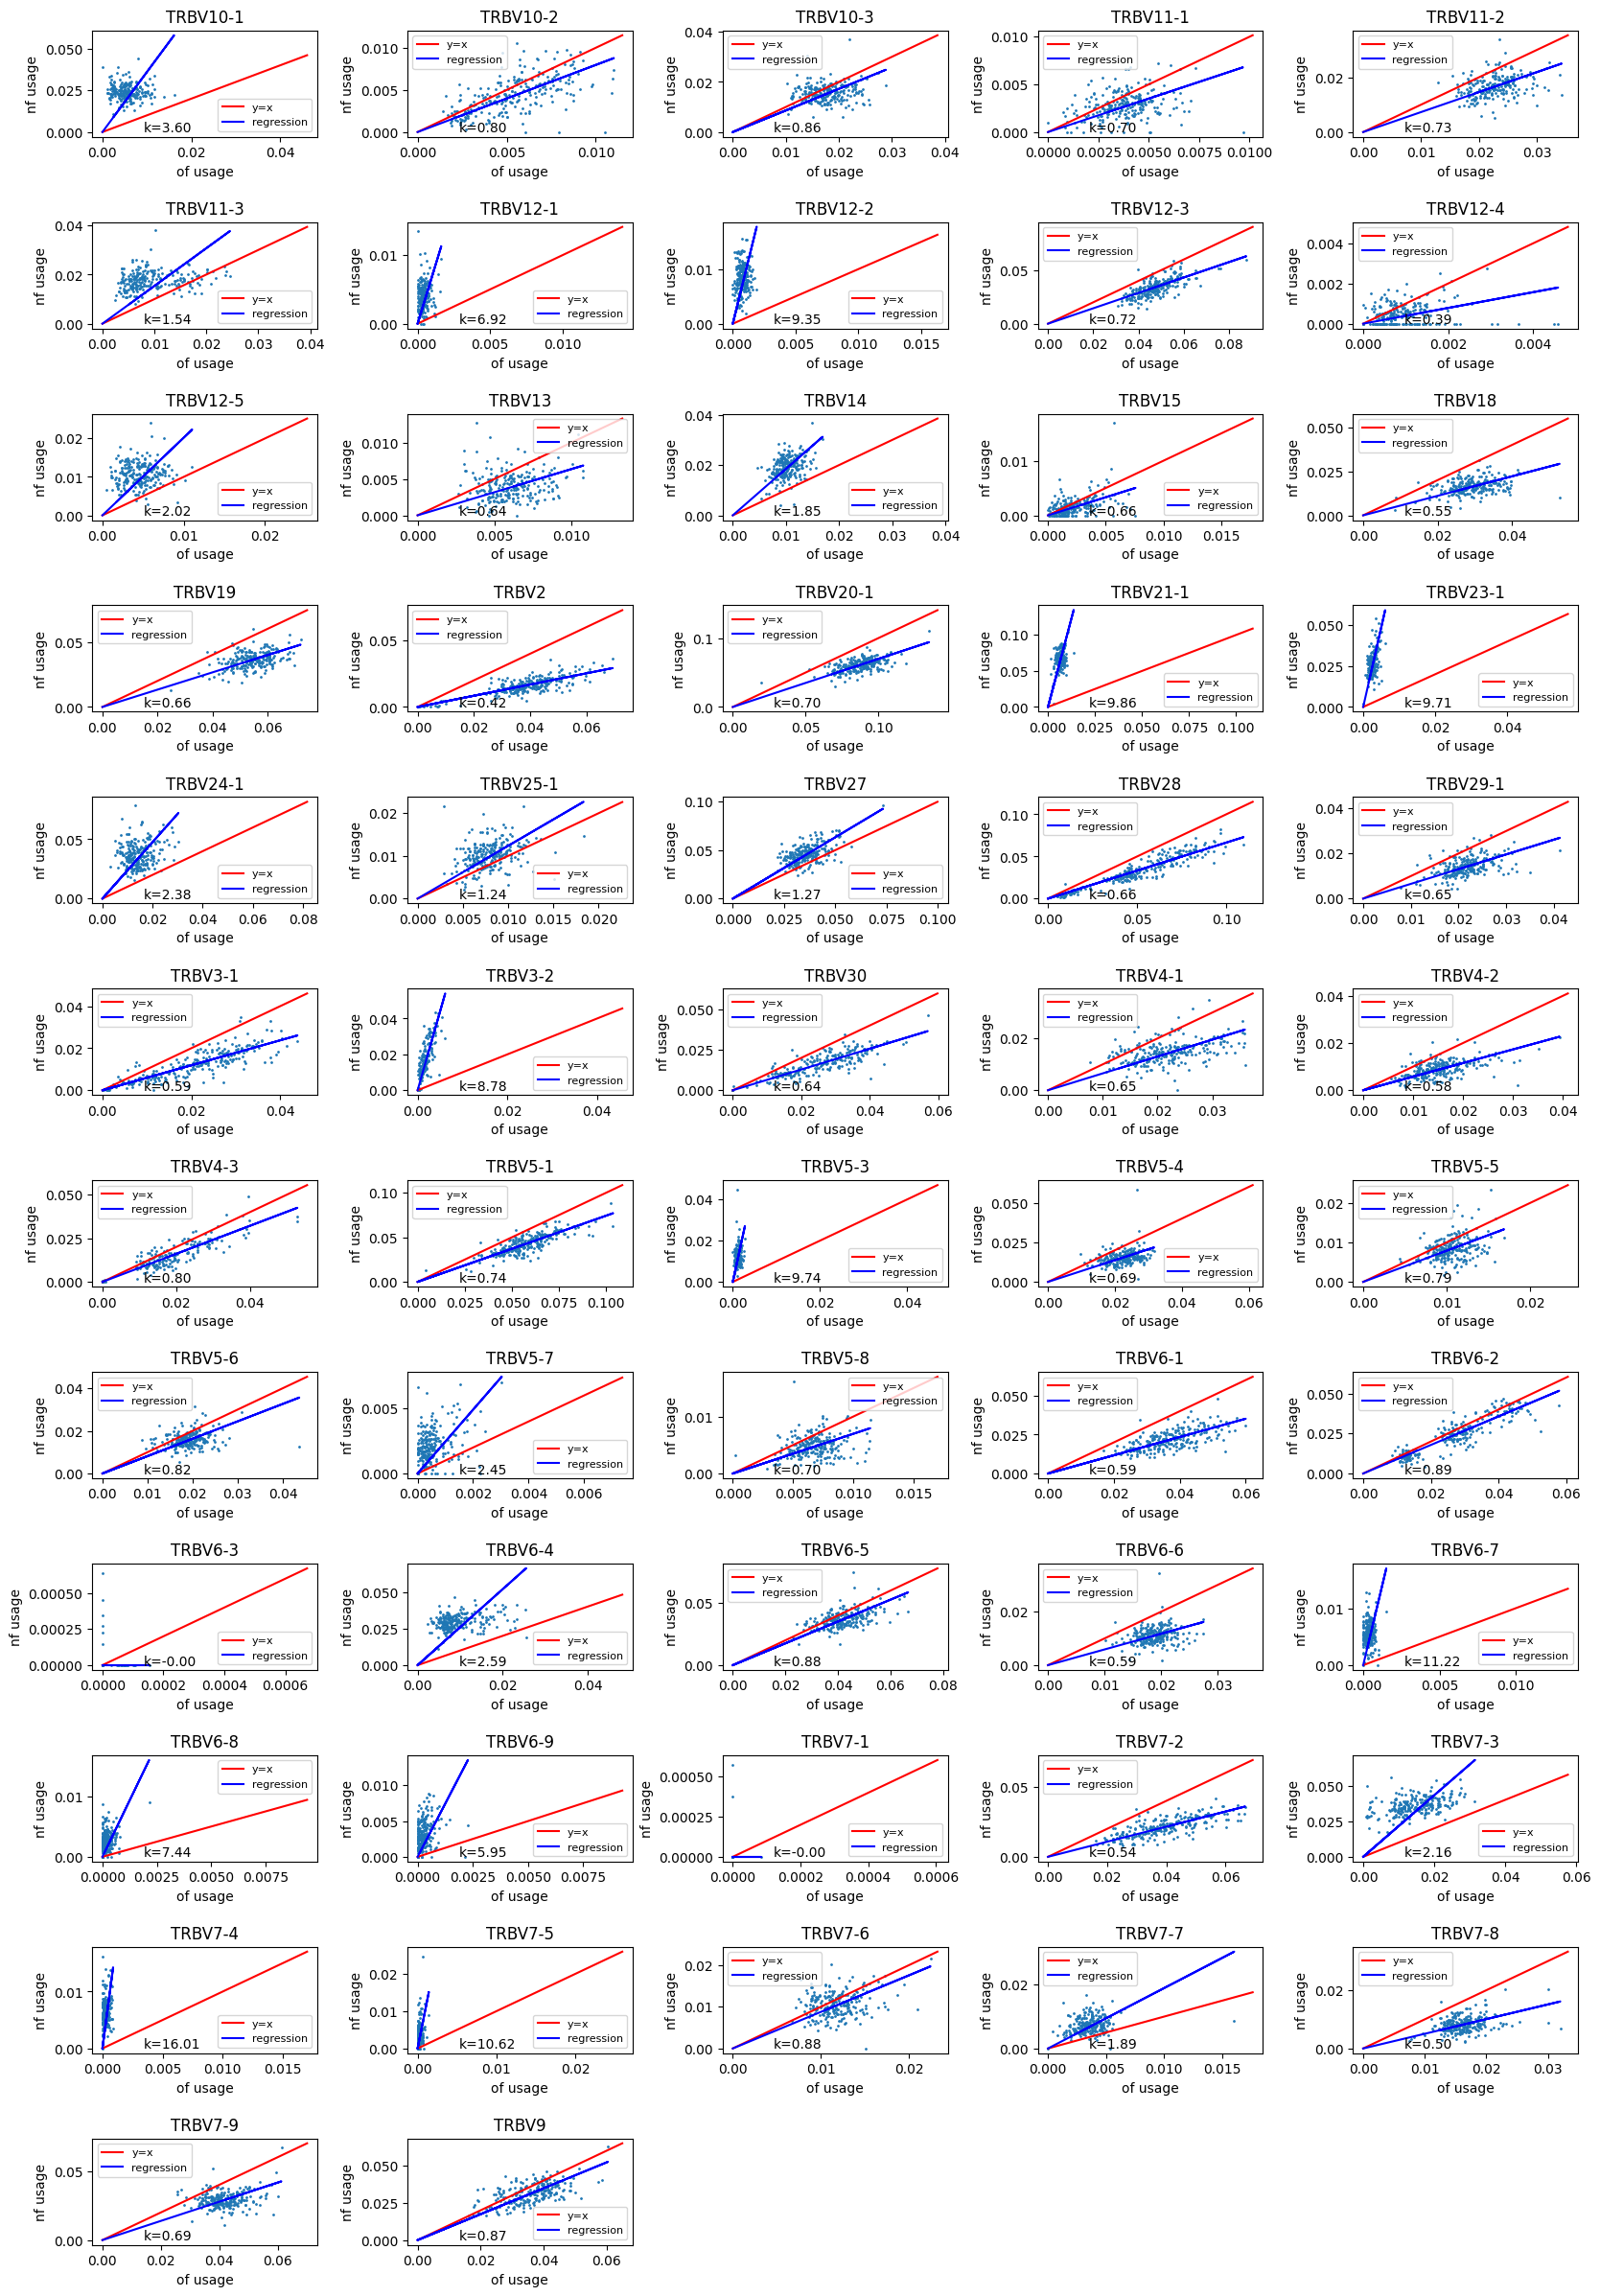

In [49]:
trbv_fit_koef = plot_scatter_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, '../pictures/TRBV_scatter_of_nf.png')

In [65]:
trbv_fit_koef

gene       koef
0   TRBV10-1   3.595639
1   TRBV10-2   0.796507
2   TRBV10-3   0.860695
3   TRBV11-1   0.701702
4   TRBV11-2   0.729521
5   TRBV11-3   1.535916
6   TRBV12-1   6.923425
7   TRBV12-2   9.345823
8   TRBV12-3   0.719439
9   TRBV12-4   0.391928
10  TRBV12-5   2.020248
11    TRBV13   0.635674
12    TRBV14   1.848275
13    TRBV15   0.662018
14    TRBV18   0.554202
15    TRBV19   0.664580
16     TRBV2   0.421513
17  TRBV20-1   0.698401
18  TRBV21-1   9.856480
19  TRBV23-1   9.706914
20  TRBV24-1   2.382184
21  TRBV25-1   1.236129
22    TRBV27   1.265281
23    TRBV28   0.664533
24  TRBV29-1   0.653703
25   TRBV3-1   0.594032
26   TRBV3-2   8.776072
27    TRBV30   0.641187
28   TRBV4-1   0.651375
29   TRBV4-2   0.576469
30   TRBV4-3   0.803786
31   TRBV5-1   0.742728
32   TRBV5-3   9.738919
33   TRBV5-4   0.686853
34   TRBV5-5   0.789731
35   TRBV5-6   0.816019
36   TRBV5-7   2.454858
37   TRBV5-8   0.697384
38   TRBV6-1   0.586194
39   TRBV6-2   0.892920
40   TRBV6-3  -0.000000
41   TRBV6-4   2.593250
42   TRBV6-5   0.878235
43   TRBV6-6   0.587715
44   TRBV6-7  11.217816
45   TRBV6-8   7.439688
46   TRBV6-9   5.945990
47   TRBV7-1  -0.000000
48   TRBV7-2   0.539168
49   TRBV7-3   2.160818
50   TRBV7-4  16.006200
51   TRBV7-5  10.624013
52   TRBV7-6   0.877819
53   TRBV7-7   1.894264
54   TRBV7-8   0.503895
55   TRBV7-9   0.693849
56     TRBV9   0.869636

In [66]:
trbv_pseudo = ['TRBV12-1', 'TRBV12-2', 'TRBV21-1', 'TRBV3-2', 'TRBV7-5']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trbv_fit_koef)} genes)  \t{round(np.mean(trbv_fit_koef.koef), 2)} \u00B1 {round(np.std(trbv_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 57 genes)  	2.65 ± 3.63
Without preudogenes (total 52 genes) 		 2.03 ± 3.15
Only pseudogenes (total 5 genes) 		 9.11 ± 1.25


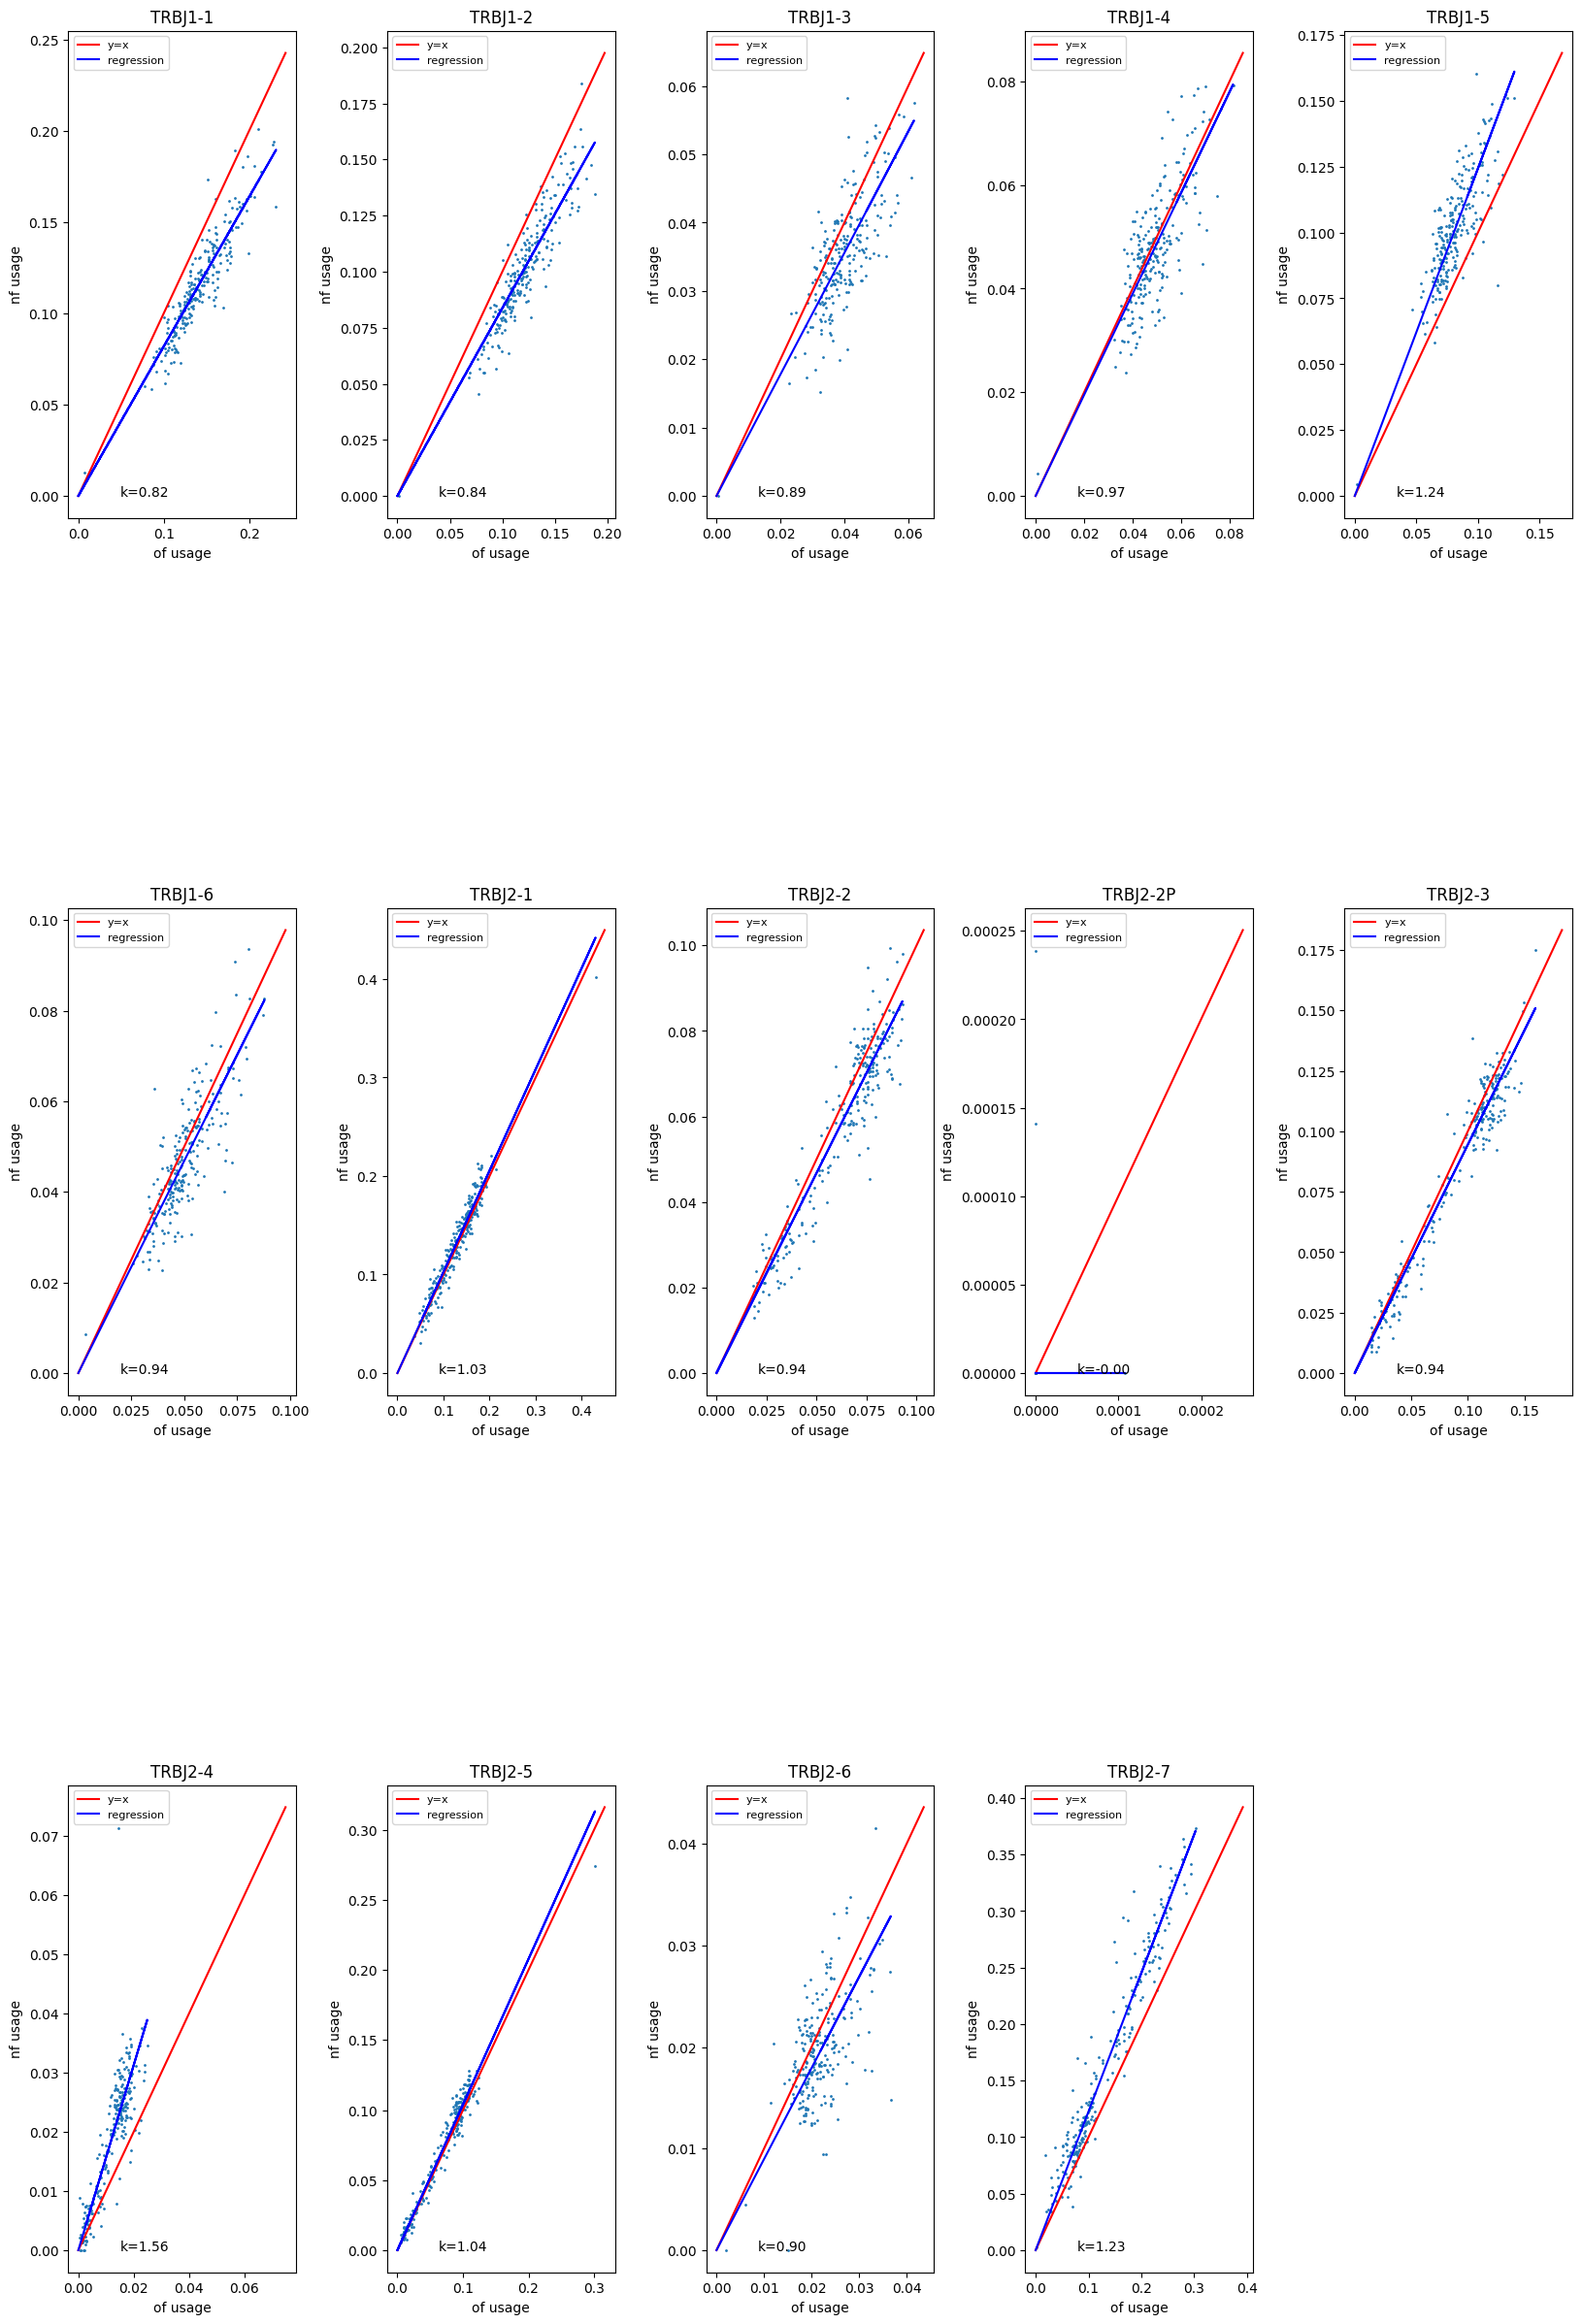

In [50]:
trbj_fit_koef = plot_scatter_of_vs_nf(j_gene_names_set_b, of_trbj_matrix, nf_trbj_matrix, '../pictures/TRBJ_scatter_of_nf.png')

In [68]:
trbj_fit_koef

gene      koef
0    TRBJ1-1  0.818733
1    TRBJ1-2  0.837447
2    TRBJ1-3  0.889316
3    TRBJ1-4  0.974718
4    TRBJ1-5  1.243278
5    TRBJ1-6  0.937241
6    TRBJ2-1  1.027993
7    TRBJ2-2  0.935700
8   TRBJ2-2P -0.000000
9    TRBJ2-3  0.944758
10   TRBJ2-4  1.563128
11   TRBJ2-5  1.039091
12   TRBJ2-6  0.896554
13   TRBJ2-7  1.226538

In [69]:
trbj_pseudo = ['TRBJ2-2P']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trbj_fit_koef)} genes)  \t{round(np.mean(trbj_fit_koef.koef), 2)} \u00B1 {round(np.std(trbj_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trbj_fit_koef[~trbj_fit_koef["gene"].isin(trbj_pseudo)])} genes) \t\t {round(np.mean(trbj_fit_koef[~trbj_fit_koef["gene"].isin(trbj_pseudo)].koef), 2)} \u00B1 {round(np.std(trbj_fit_koef[~trbj_fit_koef["gene"].isin(trbj_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 14 genes)  	0.95 ± 0.33
Without preudogenes (total 13 genes) 		 1.03 ± 0.2
